In this experiment, we incorporate the graph into the loss function. In particular, before the softmax, we consider the existing connections and only care about the connected neighbours not the whole nodes.

Here the data is for 20 MHz of bandwidth and 30 kHz of subcarrier spacing 
we use this data for BW<50 MHz

In [1]:
from platform import python_version
print(python_version())

3.9.18


In [27]:
# Some house-keeping 
import warnings
warnings.filterwarnings("ignore")

## Cell sise
from IPython.core.display import display, HTML, Markdown
display(HTML("<style>.container {width:100% !important; }</style>"))

## Jupyter widget
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [28]:
import os

# data structure dependencies
import pandas as pd
import numpy as np
import math
import random
import time

# Analytics and Visualization dependencies
import scipy
import matplotlib.pyplot as plt
import seaborn as sb
import plotly

# Some Settings
plotly.offline.init_notebook_mode(connected= True)
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 4000

# Machine learning dependencies
import sklearn
from sklearn.model_selection import train_test_split
# import smogn
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, mean_absolute_error, mean_absolute_percentage_error

### 1. Channel Gain:  – Matrix with dimensions 7x50x8

–7 BSs, 50 UEs, 8 Tx & 2 Rx antennas

–MRC per Rx antenna and then Rx Selection diversity for channel gain estimation

 

### 2. •RSRP -- Matrix with dimensions 7x50

                    7 BSs, 50 UEs

 

### 3. SINR -- Matrix with dimensions 7x50

–7 BSs, 50 UEs

–Considering each UE-BS association scenario

 

### 4. UE-BS Association --

–(i,j) = 1 when UE j is served by BS i

 

### 5. Power Consumption – Matrix with dimensions 7x1

–7 BSs

–Max Power consumption per antenna = 150 W

–Max Power consumption per BS = 150 W x 8 = 1200 W

 

### 6. QoS – Matrix with dimensions 7x1

–7 BSs

–Ratio of Max PRBs to PRBs required

–Max QoS = 1

## Loading raw data

In [29]:
# !pip install mat73
# !python -m pip install mat73

In [30]:
40e6/(30e3*12)

111.11111111111111

## Load this for train and test data

In [31]:
import mat73
mat_file = '../data/GNN_PoC_OFDM_freqReuse_1000ISD_50PRBs_30SCS_150UE_Uniform.mat' 
mat_data = mat73.loadmat(mat_file)
mat_data.keys()

UE_rate_req = 0.5e6
# Max_PRB=111

number_of_UE = mat_data['UE_pos'].shape[1]
number_of_BS = mat_data['BS_pos'].shape[1]
number_of_Samples = mat_data['UE_pos'].shape[0]
# number_of_Tx = mat_data['Channel_mtx'].shape[3]

In [32]:
number_of_Samples

1000

In [33]:
mat_data['UE_pos'].shape

(1000, 150, 2)

In [34]:
mat_data['UE_pos'].shape[1]

150

In [35]:
number_of_UE

150

In [36]:
mat_data.keys()

dict_keys(['BS_pos', 'RSRP_mtx', 'RSRQ_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos'])

In [37]:
ls_keys =['BS_pos', 'RSRP_mtx', 'RSRQ_mtx','SINR_mtx', 'UE_Ass_mtx', 'UE_pos']
for keys in ls_keys:
    print(keys+':'+ str(mat_data[keys].shape))

BS_pos:(1000, 7, 2)
RSRP_mtx:(1000, 7, 150)
RSRQ_mtx:(1000, 7, 150)
SINR_mtx:(1000, 7, 150)
UE_Ass_mtx:(1000, 7, 150)
UE_pos:(1000, 150, 2)


In [38]:
data_set= {k: mat_data[k] for k in (['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos'])}
data_set.keys()

dict_keys(['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos'])

In [39]:
data_set['UE_Ass_rsrp_mtx'] = data_set['UE_Ass_mtx']
data_set.keys()

dict_keys(['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos', 'UE_Ass_rsrp_mtx'])

In [40]:
## Random Association of UEs to BS
# number_of_UE = mat_data['Channel_mtx'].shape[2]
# number_of_BS = mat_data['Channel_mtx'].shape[1]
# number_of_Samples = mat_data['Channel_mtx'].shape[0]
# number_of_Tx = mat_data['Channel_mtx'].shape[3]


rand_Ass = np.zeros(data_set['UE_Ass_rsrp_mtx'].shape)
for sample in range(number_of_Samples):
    for ue in range(number_of_UE):
        rand_Ass[sample, random.randint(0, number_of_BS-1), ue] =1

data_set['UE_Ass_rnd_mtx']=rand_Ass

# Data Processing

## SINR distribution and relative distances

In [41]:
len(data_set['SINR_mtx'][2][1].tolist())

150

In [42]:
cell_nom= 3
l=[]
for i in range(number_of_Samples):
    l.extend(data_set['SINR_mtx'][i][cell_nom][np.nonzero(data_set['SINR_mtx'][i][cell_nom]*data_set['UE_Ass_rnd_mtx'][i][cell_nom])].tolist())

type(l)

list

In [43]:
number_of_Samples

1000

In [44]:
l

[5.238039887413776,
 -15.412536939118446,
 -6.949177121520207,
 -26.94469064160502,
 40.06768841426343,
 -21.963401452917193,
 11.448492910196077,
 22.575699805438425,
 5.9415076394196475,
 -12.832424072155469,
 12.836204378231733,
 -29.00684975625927,
 -8.56803938974626,
 -29.200988612276895,
 -26.906523975252426,
 -33.57037078180926,
 -36.6907800328958,
 9.31274763717566,
 -17.66598201734895,
 7.321023840308827,
 -30.66700080483871,
 -38.21546352800186,
 14.570940374487764,
 16.18989079444866,
 0.42467771759270345,
 23.012151946064563,
 -6.732586419534863,
 -16.746441563010073,
 43.6437170638909,
 -16.474792652618987,
 12.806665391424117,
 -54.193810131746375,
 14.153035192879447,
 -37.5738298762396,
 -23.84830078789513,
 -9.219140918470432,
 7.989892759076188,
 3.824743967068164,
 45.27110025788717,
 -23.994373190613082,
 3.576293404439033,
 -4.7527167154919,
 7.7743683004276605,
 1.7404716779084013,
 -2.7763653830006914,
 -5.024695884176102,
 -16.461967767713016,
 -18.3015662393163

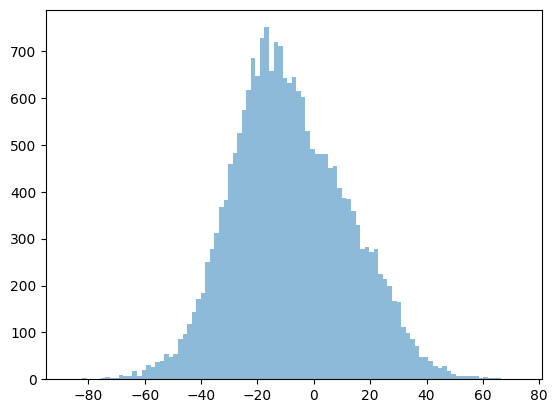

In [45]:
## lets see the histograam of SINR in each cell
## Plot histogram:
bins = np.linspace(math.ceil(np.min(l)), 
                   math.floor(np.max(l)),
                   100) # fixed number of bins
# bins = np.array([-6,-3, 6, 27])
plt.hist(l, bins=bins, alpha=0.5)


plt.show()

In [46]:
#### now we calculate the percentage distribution of SINR in each cell in these buckets bins = np.array([-6,-2, 2, 27]) and then add his to data set

In [47]:
bins = np.array([-40,4, 9, 40])
SINR_Distr=np.zeros([number_of_Samples,number_of_BS,3])
for i in range(number_of_Samples):
    for cell_nom in range(number_of_BS):
        d= data_set['SINR_mtx'][i][cell_nom][np.nonzero(data_set['SINR_mtx'][i][cell_nom]*data_set['UE_Ass_rnd_mtx'][i][cell_nom])].tolist()
        hist, edges = np.histogram(d,bins=bins)
        SINR_Distr[i,cell_nom]= hist/np.sum(hist)
    
SINR_Distr.shape

(1000, 7, 3)

In [48]:
data_set['SINR_Distr_mtx']= SINR_Distr

In [49]:
data_set['SINR_Distr_mtx'].shape

(1000, 7, 3)

## UEs relative distances

In [50]:
#### Now lets calculate new feature, Relative distance of UEs to all RUs, it is going to be (1000, 50, 7)
## sqrt{[x_j-x_i]**2 + [y_j-y_i]**2}

In [51]:
RE_relative_dist=np.zeros([number_of_Samples,number_of_UE,number_of_BS])
for i in range(number_of_Samples):
    for UE_nom in range(number_of_UE):
        ue = data_set['UE_pos'][i][UE_nom]
        bs = data_set['BS_pos'][i]
        dist= np.sqrt((bs[:,0]-ue[0])**2 + (bs[:,1]-ue[1])**2)
        Relative_dist = dist / np.max(dist)
        RE_relative_dist[i,UE_nom]= Relative_dist
    
RE_relative_dist.shape

(1000, 150, 7)

In [52]:
data_set['UE_relative_dist_mtx']= RE_relative_dist

In [53]:
data_set.keys()

dict_keys(['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos', 'UE_Ass_rsrp_mtx', 'UE_Ass_rnd_mtx', 'SINR_Distr_mtx', 'UE_relative_dist_mtx'])

In [54]:
data_set['SINR_Distr_mtx'][1]

array([[0.44444444, 0.27777778, 0.27777778],
       [0.73913043, 0.08695652, 0.17391304],
       [0.66666667, 0.19047619, 0.14285714],
       [0.73913043, 0.13043478, 0.13043478],
       [0.95238095, 0.        , 0.04761905],
       [0.5       , 0.2       , 0.3       ],
       [0.91666667, 0.        , 0.08333333]])

## Calculate PRB allocation

In [55]:
# for each sample and for each RU find the corresponding  UEs SNRs, and then find the MCS level, code rate and mod order

In [56]:
# MCS_SNR_df = pd.read_csv('data/SNR_MCS_Mapping.csv')
MCS_SNR_df = pd.read_csv('../data/SNR_MCS_Mapping.csv', header=None, names=['MCS', 'Code_rate', 'Mod_order', 'SNR'])
power_map_df = pd.read_csv('../data/Power_Model.csv', header=None, names=['PrB', 'Power_cons'])
power_map_df = power_map_df.drop([0]) 
power_map_df = power_map_df.astype(np.float16)
power_map_df

PrB  Power_cons
1     5.0       66.75
2    10.0       74.50
3    15.0       81.25
4    20.0       87.00
5    25.0       92.00
6    30.0       96.50
7    35.0      100.75
8    40.0      104.75
9    45.0      108.50
10   50.0      112.25
11   55.0      115.75
12   60.0      119.50
13   65.0      123.00
14   70.0      126.50
15   75.0      130.25
16   80.0      133.75
17   85.0      137.75
18   90.0      141.50
19   95.0      145.75
20  100.0      150.00

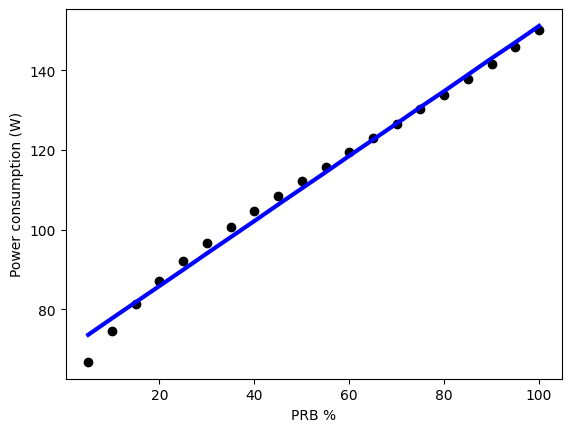

In [57]:
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

regr = linear_model.LinearRegression()
x = [[x] for x in power_map_df['PrB'].values]
y = [[x] for x in power_map_df['Power_cons'].values]
# x= power_map_df[['PrB']].values.reshape(-1,1)
# y= power_map_df[['Power_cons']].values.reshape(-1,1)
regr.fit(x, y)

plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xlabel('PRB %')
plt.ylabel('Power consumption (W)')
plt.show()

In [58]:
print(regr.coef_)
print(regr.intercept_)

[[0.8164]]
[69.5]


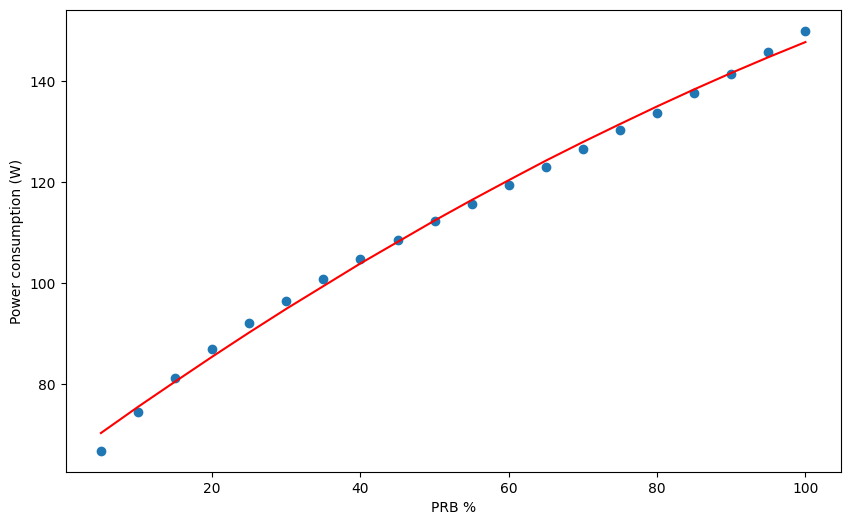

In [59]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2, include_bias=False)
x_ = np.array([i[0] for i in x])
poly_features = poly.fit_transform(x_.reshape(-1,1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)
y_predicted = poly_reg_model.predict(poly_features)

plt.figure(figsize=(10, 6))
plt.scatter(x, y)
plt.plot(x, y_predicted, c="red")
plt.xlabel('PRB %')
plt.ylabel('Power consumption (W)')
plt.show()

In [60]:
import torch
coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float16).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_)

In [61]:
coefs

tensor([[ 1.0664, -0.0024]], dtype=torch.float16)

In [62]:
poly_features

array([[5.000e+00, 2.500e+01],
       [1.000e+01, 1.000e+02],
       [1.500e+01, 2.250e+02],
       [2.000e+01, 4.000e+02],
       [2.500e+01, 6.250e+02],
       [3.000e+01, 9.000e+02],
       [3.500e+01, 1.225e+03],
       [4.000e+01, 1.600e+03],
       [4.500e+01, 2.025e+03],
       [5.000e+01, 2.500e+03],
       [5.500e+01, 3.024e+03],
       [6.000e+01, 3.600e+03],
       [6.500e+01, 4.224e+03],
       [7.000e+01, 4.900e+03],
       [7.500e+01, 5.624e+03],
       [8.000e+01, 6.400e+03],
       [8.500e+01, 7.224e+03],
       [9.000e+01, 8.100e+03],
       [9.500e+01, 9.024e+03],
       [1.000e+02, 1.000e+04]], dtype=float16)

In [63]:
# We add one row at the end for no connection case forcing PRBs and power to inf
MCS_SNR_df.loc[29] =[0, 1e-3, 1, -80]
MCS_SNR_df



MCS  Code_rate  Mod_order    SNR
0   28.0   0.925781        6.0  20.45
1   27.0   0.888672        6.0  18.55
2   26.0   0.852539        6.0  17.66
3   25.0   0.802704        6.0  16.55
4   24.0   0.753906        6.0  15.98
5   23.0   0.702148        6.0  14.80
6   22.0   0.650391        6.0  13.79
7   21.0   0.601562        6.0  12.66
8   20.0   0.553711        6.0  12.11
9   19.0   0.504883        6.0  11.65
10  18.0   0.455078        6.0  10.17
11  17.0   0.427734        6.0   9.55
12  16.0   0.642578        4.0   8.77
13  15.0   0.601562        4.0   7.92
14  14.0   0.540039        4.0   7.27
15  13.0   0.478516        4.0   6.09
16  12.0   0.423828        4.0   5.50
17  11.0   0.369141        4.0   4.65
18   9.0   0.663086        2.0   3.81
19  10.0   0.332031        4.0   3.79
20   8.0   0.587891        2.0   2.68
21   7.0   0.513672        2.0   1.70
22   6.0   0.438477        2.0   0.62
23   5.0   0.370117        2.0  -0.50
24   4.0   0.300781        2.0  -1.48
25   3.0   0.245117        2.0  -1.54
26   2.0   0.188477        2.0  -3.23
27   1.0   0.153320        2.0  -3.96
28   0.0   0.117188        2.0  -5.11
29   0.0   0.001000        1.0 -80.00

### Save data 

In [39]:
# import pickle 

# # with open('../data/Exterem_Test1_Data_processed_Correct_SINR_NewData_ODFM.pkl', 'wb') as f:
# #     pickle.dump(data_set, f)

# with open('data/Data_processed_NarrowBand_freqReuse_UniformData_SINR_OFDM_1000ISD_BW20_PRB50_200UE.pkl', 'wb') as f:
#     pickle.dump(data_set, f)

# Load data

In [64]:
import pickle 
name = '../data/Data_processed_NarrowBand_freqReuse_UniformData_SINR_OFDM_1000ISD_BW20_PRB50_150UE.pkl'
# name = 'data/Data_processed.pkl'

with open(name, 'rb') as f:
    data_set_processed = pickle.load(f)
    
data_set_processed.keys()


dict_keys(['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos', 'UE_Ass_rsrp_mtx', 'UE_Ass_rnd_mtx', 'SINR_Distr_mtx', 'UE_relative_dist_mtx', 'BS_PRB_total', 'BS_PRB_Percent', 'SNR_mtx_norm', 'UE_SNR_RU_norm', 'RSRP_mtx_norm', 'Edge_UE_indicator', 'Adj_mtx', 'connection_mtx', 'UE_aggPRB_norm', 'UE_Ass_sinr_mtx', 'UE_PRB_Feature_mtx'])

# Build Homo Graph

 here we create a graph:
 - The Ue features are 
 \begin{equation}
UE\, features = [(d_1,d_2, \cdots, d_K), \,\,\, (SNR_1, SNR_2, \cdots ,SNR_K),\,\,\, (PRB_1, PRB_2, PRB_K)]
 \end{equation}
 and 
 
  \begin{equation}
BS\, features = [PRB, \,\,\, (H, M, L)]
 \end{equation}
 wher H, M, L are the number of UEs with high, medium and low SNR in that cell (a measure on the distribution of UEs in that cell)

## Test: create graph of data for one sample

In [65]:
# sample =0 
# number_of_UE= 50
# number_of_BS= 7
# UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample],  data_set_processed['UE_aggPRB_norm'][sample]), axis=1)
# BS_feature_mtx = np.concatenate((data_set_processed['BS_PRB_Percent'][sample], data_set_processed['SINR_Distr_mtx'][sample]), axis=1)
# RSRP_matrix = data_set_processed['RSRP_mtx_norm'][sample]
# link_features = np.reshape(RSRP_matrix, number_of_BS*number_of_UE, order='F')
# link_features

In [66]:
# import torch
# from torch_geometric.data import HeteroData
# from torch_geometric.data import Data

# import itertools
# import torch_geometric.transforms as T

# UE_id = list(range(number_of_UE))
# BS_id = list(range(number_of_BS))

# data = HeteroData()

# conn_idx = torch.tensor(list(itertools.product(UE_id, BS_id)))
# edge_idx = torch.transpose(conn_idx,0, 1)

# data['UE'].node_id = torch.arange(len(UE_id))
# data['BS'].node_id = torch.arange(len(BS_id))

# data['UE'].x = torch.from_numpy(UE_feature_mtx).to(torch.float) # [num_UE, num_features_UE]
# data['BS'].x = torch.from_numpy(BS_feature_mtx).to(torch.float) # [num_BS, num_features_BS]
# data['UE', 'BS'].edge_index = edge_idx # [2, num_edges]
# data['UE', 'BS'].edge_attr = torch.from_numpy(link_features).to(torch.float) # [num_edges, num_features]

# # We also need to make sure to add the reverse edges from BS to UE
# # in order to let a GNN be able to pass messages in both directions.
# # We can leverage the `T.ToUndirected()` transform for this from PyG:
# data = T.ToUndirected()(data)



# UE_id = list(range(number_of_UE))
# conn_idx = torch.tensor(list(itertools.product(UE_id, UE_id)))
# edge_index = torch.transpose(conn_idx,0, 1)
# x= torch.from_numpy(UE_feature_mtx).to(torch.float) # [num_UE, num_features_UE]
# Homodata = Data(x=x, edge_index=edge_index)
# Homodata['cc']=1


# Create a list of graphs for all data set

In [67]:
data_set_processed['UE_aggPRB_norm'][sample]

array([[1.000e+00, 2.977e+03, 2.977e+03, ..., 2.000e+00, 5.000e+00,
        2.977e+03],
       [1.000e+01, 1.000e+00, 2.977e+03, ..., 2.977e+03, 2.977e+03,
        2.000e+00],
       [1.000e+00, 2.977e+03, 2.977e+03, ..., 2.977e+03, 1.000e+00,
        2.000e+00],
       ...,
       [1.000e+00, 2.977e+03, 2.977e+03, ..., 1.000e+00, 2.000e+00,
        2.977e+03],
       [5.000e+00, 2.000e+00, 1.000e+00, ..., 2.977e+03, 2.977e+03,
        2.977e+03],
       [3.000e+00, 2.977e+03, 2.977e+03, ..., 2.977e+03, 3.000e+00,
        1.000e+00]])

In [68]:
adj_t= data_set_processed['Adj_mtx'][1]
edge_index = torch.tensor(adj_t.nonzero())
edge_index

tensor([[  0,   0,   0,  ..., 149, 149, 149],
        [  0,   1,   2,  ..., 147, 148, 149]])

In [69]:
np.nonzero(data_set_processed['Edge_UE_indicator'][sample])[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

In [70]:

import torch_geometric.transforms as T

def create_Homo_graph(data_set_processed, sample):
    
    
    adj_t= data_set_processed['Adj_mtx'][sample]
    edge_index = torch.tensor(adj_t.nonzero())
#     x= torch.from_numpy(UE_feature_mtx).to(torch.float) # [num_UE, num_features_UE]
#     UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample], data_set_processed['Edge_UE_indicator'][sample]), axis=1)
    UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample], data_set_processed['UE_PRB_Feature_mtx'][sample]), axis=1)



    x = torch.tensor(UE_feature_mtx, dtype=torch.float32) 
    Homodata = Data(x=x, edge_index=edge_index)
    
    Homodata = T.AddSelfLoops()(Homodata)
#     Homodata = T.NormalizeFeatures()(Homodata)
    
    Homodata['SINR_mtx'] =torch.from_numpy(data_set_processed['SINR_mtx'][sample]).to(torch.float)
    Homodata['UE_PRB_All_cells'] =torch.from_numpy(data_set_processed['UE_aggPRB_norm'][sample]).to(torch.float)
    Homodata['UE_Ass_rsrp_mtx'] =torch.from_numpy(data_set_processed['UE_Ass_rsrp_mtx'][sample]).to(torch.float)
    Homodata['UE_Ass_sinr_mtx'] =torch.from_numpy(data_set_processed['UE_Ass_sinr_mtx'][sample]).to(torch.float)
    Homodata['Conn_mtx'] =  torch.from_numpy(np.transpose(data_set_processed['connection_mtx'][sample])).to(torch.float) 
    Homodata['Cell_Edge_id'] =  torch.from_numpy(np.nonzero(data_set_processed['Edge_UE_indicator'][sample])[0]).to(torch.float) 
    
    
    return Homodata

In [71]:
sample=1
UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample], data_set_processed['UE_PRB_Feature_mtx'][sample]), axis=1)
# print(UE_feature_mtx[sample])
x = torch.tensor(UE_feature_mtx, dtype=torch.float32) 
Homodata = Data(x=x, edge_index=edge_index)
# Homodata = T.NormalizeFeatures()(Homodata)
# Homodata = T.AddSelfLoops()(Homodata)
print(Homodata.x[10])

tensor([ 0.4410,  0.1594,  0.5967,  0.9183,  1.0000,  0.8181,  0.4267, -1.1558,
         1.5420,  0.2621, -0.5712, -0.3042, -1.4102,  0.4744,  0.0000,  1.0000,
        13.0000,  0.0000,  0.0000,  0.0000,  3.0000])


In [72]:
print(Homodata.x[30])

tensor([ 0.5011,  0.8809,  1.0000,  0.8512,  0.4743,  0.0297,  0.5257,  1.4933,
        -1.7631, -0.4800, -2.0810, -0.4227,  2.3849,  1.0276,  1.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  1.0000])


In [73]:
data_set_processed['UE_aggPRB_norm'][sample]

array([[1.000e+00, 2.977e+03, 2.977e+03, ..., 1.000e+00, 2.977e+03,
        2.977e+03],
       [1.000e+00, 2.977e+03, 3.000e+00, ..., 1.300e+01, 2.977e+03,
        2.977e+03],
       [8.000e+00, 2.977e+03, 2.977e+03, ..., 2.977e+03, 3.000e+00,
        1.000e+00],
       ...,
       [2.977e+03, 2.977e+03, 2.977e+03, ..., 2.977e+03, 2.000e+00,
        1.000e+00],
       [4.000e+00, 2.977e+03, 1.000e+00, ..., 2.977e+03, 2.977e+03,
        2.977e+03],
       [1.000e+00, 2.977e+03, 2.977e+03, ..., 1.000e+00, 2.000e+00,
        2.977e+03]])

In [74]:
# Graph_data_UE_dict = dict() ## the key is UE numbers and the value is the list of HeteroData graphs defined over each time stamp
Graph_list = []
number_of_Samples=1000
for sample in range(number_of_Samples):

    print('Sample = {}'.format(sample))
    Sample_homo_graph = create_Homo_graph(data_set_processed, sample)
    Graph_list.append(Sample_homo_graph)
        

Sample = 0
Sample = 1
Sample = 2
Sample = 3
Sample = 4
Sample = 5
Sample = 6
Sample = 7
Sample = 8
Sample = 9
Sample = 10
Sample = 11
Sample = 12
Sample = 13
Sample = 14
Sample = 15
Sample = 16
Sample = 17
Sample = 18
Sample = 19
Sample = 20
Sample = 21
Sample = 22
Sample = 23
Sample = 24
Sample = 25
Sample = 26
Sample = 27
Sample = 28
Sample = 29
Sample = 30
Sample = 31
Sample = 32
Sample = 33
Sample = 34
Sample = 35
Sample = 36
Sample = 37
Sample = 38
Sample = 39
Sample = 40
Sample = 41
Sample = 42
Sample = 43
Sample = 44
Sample = 45
Sample = 46
Sample = 47
Sample = 48
Sample = 49
Sample = 50
Sample = 51
Sample = 52
Sample = 53
Sample = 54
Sample = 55
Sample = 56
Sample = 57
Sample = 58
Sample = 59
Sample = 60
Sample = 61
Sample = 62
Sample = 63
Sample = 64
Sample = 65
Sample = 66
Sample = 67
Sample = 68
Sample = 69
Sample = 70
Sample = 71
Sample = 72
Sample = 73
Sample = 74
Sample = 75
Sample = 76
Sample = 77
Sample = 78
Sample = 79
Sample = 80
Sample = 81
Sample = 82
Sample = 83
Sa

Sample = 673
Sample = 674
Sample = 675
Sample = 676
Sample = 677
Sample = 678
Sample = 679
Sample = 680
Sample = 681
Sample = 682
Sample = 683
Sample = 684
Sample = 685
Sample = 686
Sample = 687
Sample = 688
Sample = 689
Sample = 690
Sample = 691
Sample = 692
Sample = 693
Sample = 694
Sample = 695
Sample = 696
Sample = 697
Sample = 698
Sample = 699
Sample = 700
Sample = 701
Sample = 702
Sample = 703
Sample = 704
Sample = 705
Sample = 706
Sample = 707
Sample = 708
Sample = 709
Sample = 710
Sample = 711
Sample = 712
Sample = 713
Sample = 714
Sample = 715
Sample = 716
Sample = 717
Sample = 718
Sample = 719
Sample = 720
Sample = 721
Sample = 722
Sample = 723
Sample = 724
Sample = 725
Sample = 726
Sample = 727
Sample = 728
Sample = 729
Sample = 730
Sample = 731
Sample = 732
Sample = 733
Sample = 734
Sample = 735
Sample = 736
Sample = 737
Sample = 738
Sample = 739
Sample = 740
Sample = 741
Sample = 742
Sample = 743
Sample = 744
Sample = 745
Sample = 746
Sample = 747
Sample = 748
Sample = 749

## Create Train and Test data set

In [75]:
from random import shuffle
import math 
import torch
test_percentage= .2

# torch.manual_seed(12345)
shuffle(Graph_list)

test_size = math.ceil(len(Graph_list)*test_percentage)
train_size = len(Graph_list) - test_size

Graph_list_train = Graph_list[:train_size]
Graph_list_test = Graph_list[train_size:]

print(f'Number of training graphs: {len(Graph_list_train)}')
print(f'Number of test graphs: {len(Graph_list_test)}')

Number of training graphs: 800
Number of test graphs: 200


In [76]:
from torch_geometric.loader import DataLoader
batch_size_train =1
batch_size_test =1

train_loader = DataLoader(Graph_list_train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(Graph_list_test, batch_size=batch_size_test, shuffle=False)
# Extereme_test_loader = DataLoader(Extereme_Test_Graph_list, batch_size=batch_size_test, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data.x)
    print()
    

Step 1:
Number of graphs in the current batch: 1
tensor([[ 0.2997,  0.8259,  0.5266,  ...,  8.0000,  0.0000,  0.0000],
        [ 0.4855,  0.7998,  1.0000,  ...,  0.0000,  1.0000,  1.0000],
        [ 0.5275,  1.0000,  0.7842,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.6156,  0.2373,  0.4911,  ...,  0.0000,  0.0000, 13.0000],
        [ 0.5521,  0.9294,  1.0000,  ...,  1.0000,  1.0000,  0.0000],
        [ 0.5589,  0.5655,  0.9005,  ...,  0.0000,  2.0000,  1.0000]])

Step 2:
Number of graphs in the current batch: 1
tensor([[ 0.5682,  0.7746,  0.3534,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3786,  1.0000,  0.9416,  ...,  1.0000,  8.0000,  0.0000],
        [ 0.5751,  0.1598,  0.4674,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 0.6004,  0.8476,  1.0000,  ..., 10.0000, 10.0000,  4.0000],
        [ 0.6274,  0.8519,  0.5090,  ...,  2.0000,  0.0000,  0.0000],
        [ 0.4022,  0.5497,  0.1977,  ...,  0.0000,  0.0000,  0.0000]])

Step 3:
Number of graphs in the 

Step 54:
Number of graphs in the current batch: 1
tensor([[0.5580, 0.2266, 0.3335,  ..., 0.0000, 0.0000, 0.0000],
        [0.4202, 1.0000, 0.8864,  ..., 1.0000, 1.0000, 0.0000],
        [0.5214, 0.9667, 1.0000,  ..., 1.0000, 2.0000, 0.0000],
        ...,
        [0.5461, 1.0000, 0.7362,  ..., 1.0000, 0.0000, 0.0000],
        [0.5422, 0.2843, 0.2594,  ..., 0.0000, 0.0000, 0.0000],
        [0.5065, 0.6418, 0.9479,  ..., 0.0000, 2.0000, 1.0000]])

Step 55:
Number of graphs in the current batch: 1
tensor([[0.5892, 0.1861, 0.4759,  ..., 0.0000, 0.0000, 0.0000],
        [0.5286, 1.0000, 0.8150,  ..., 1.0000, 5.0000, 0.0000],
        [0.4698, 0.1628, 0.6296,  ..., 0.0000, 0.0000, 2.0000],
        ...,
        [0.4581, 0.9831, 0.7068,  ..., 1.0000, 0.0000, 0.0000],
        [0.5796, 0.9033, 1.0000,  ..., 2.0000, 1.0000, 0.0000],
        [0.5982, 0.8193, 0.4418,  ..., 3.0000, 0.0000, 0.0000]])

Step 56:
Number of graphs in the current batch: 1
tensor([[0.5734, 0.1584, 0.4623,  ..., 0.0000, 0.000

Step 140:
Number of graphs in the current batch: 1
tensor([[0.5015, 1.0000, 0.9437,  ..., 1.0000, 3.0000, 0.0000],
        [0.4282, 0.7846, 1.0000,  ..., 0.0000, 1.0000, 2.0000],
        [0.5570, 0.6770, 0.9664,  ..., 0.0000, 1.0000, 1.0000],
        ...,
        [0.3357, 0.6316, 0.3401,  ..., 0.0000, 0.0000, 0.0000],
        [0.5599, 0.1652, 0.4078,  ..., 0.0000, 0.0000, 2.0000],
        [0.5322, 0.4213, 0.8193,  ..., 0.0000, 0.0000, 1.0000]])

Step 141:
Number of graphs in the current batch: 1
tensor([[ 0.5174,  0.1835,  0.3422,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3881,  0.6471,  0.2695,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5647,  0.2329,  0.3365,  ...,  0.0000,  0.0000,  4.0000],
        ...,
        [ 0.5904,  0.8650,  1.0000,  ...,  1.0000,  1.0000,  0.0000],
        [ 0.5343,  0.6876,  0.2203,  ...,  0.0000,  8.0000,  0.0000],
        [ 0.3760,  0.9715,  0.7066,  ...,  0.0000, 13.0000,  0.0000]])

Step 142:
Number of graphs in the current batch: 1
tensor([[ 0.2

tensor([[0.5401, 0.2793, 0.2631,  ..., 0.0000, 0.0000, 0.0000],
        [0.2185, 1.0000, 0.9571,  ..., 3.0000, 0.0000, 0.0000],
        [0.5532, 0.9246, 0.6055,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.3685, 0.8504, 0.5095,  ..., 2.0000, 0.0000, 0.0000],
        [0.4714, 0.8144, 0.4131,  ..., 0.0000, 0.0000, 0.0000],
        [0.5780, 1.0000, 0.9466,  ..., 2.0000, 2.0000, 0.0000]])

Step 201:
Number of graphs in the current batch: 1
tensor([[ 0.5733,  1.0000,  0.9522,  ...,  2.0000,  3.0000,  0.0000],
        [ 0.5589,  0.7696,  0.3415,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5872,  0.8045,  0.4121,  ...,  4.0000,  0.0000,  0.0000],
        ...,
        [ 0.5425,  0.7353,  0.2766,  ...,  0.0000, 10.0000,  0.0000],
        [ 0.3842,  0.7254,  0.9838,  ...,  0.0000,  3.0000,  2.0000],
        [ 0.5940,  0.1910,  0.5554,  ...,  0.0000,  0.0000,  0.0000]])

Step 202:
Number of graphs in the current batch: 1
tensor([[0.3591, 0.9487, 0.6737,  ..., 5.0000, 0.0000, 0.0000],


tensor([[ 0.5431,  0.7317,  0.9993,  ...,  0.0000,  2.0000,  1.0000],
        [ 0.5607,  0.9682,  0.6805,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.5648,  1.0000,  0.9545,  ...,  1.0000,  2.0000,  0.0000],
        ...,
        [ 0.5614,  0.2243,  0.3408,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2505,  1.0000,  0.9826,  ...,  0.0000, 13.0000, 13.0000],
        [ 0.5504,  0.1037,  0.4854,  ...,  8.0000,  0.0000,  0.0000]])

Step 287:
Number of graphs in the current batch: 1
tensor([[ 0.5057,  0.9288,  1.0000,  ...,  1.0000,  1.0000,  0.0000],
        [ 0.2577,  0.4850,  0.6629,  ...,  0.0000,  0.0000,  8.0000],
        [ 0.1269,  0.9279,  0.8011,  ..., 13.0000,  5.0000,  0.0000],
        ...,
        [ 0.4140,  0.7641,  0.3572,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5937,  0.8469,  0.4856,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4042,  0.5225,  0.8687,  ...,  0.0000,  0.0000,  1.0000]])

Step 288:
Number of graphs in the current batch: 1
tensor([[0.5008, 0.8490, 0.4

Step 346:
Number of graphs in the current batch: 1
tensor([[ 0.3550,  1.0000,  0.8142,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.3394,  0.7473,  0.9868,  ...,  2.0000,  3.0000,  0.0000],
        [ 0.5910,  0.6165,  0.9264,  ...,  0.0000,  1.0000,  1.0000],
        ...,
        [ 0.5816,  0.2074,  0.4038,  ...,  0.0000,  0.0000, 10.0000],
        [ 0.6133,  1.0000,  0.9079,  ...,  1.0000,  2.0000,  0.0000],
        [ 0.5355,  0.5700,  0.1032,  ...,  0.0000,  0.0000,  0.0000]])

Step 347:
Number of graphs in the current batch: 1
tensor([[0.5970, 1.0000, 0.9178,  ..., 1.0000, 2.0000, 0.0000],
        [0.4458, 0.7491, 0.3164,  ..., 0.0000, 4.0000, 0.0000],
        [0.6038, 0.2252, 0.4530,  ..., 0.0000, 0.0000, 3.0000],
        ...,
        [0.5774, 0.8010, 0.4021,  ..., 5.0000, 0.0000, 0.0000],
        [0.5568, 0.2621, 0.2949,  ..., 0.0000, 0.0000, 0.0000],
        [0.5618, 0.8573, 1.0000,  ..., 0.0000, 1.0000, 2.0000]])

Step 348:
Number of graphs in the current batch: 1
tensor([[0.57

Step 432:
Number of graphs in the current batch: 1
tensor([[0.3805, 0.4883, 0.8407,  ..., 0.0000, 0.0000, 1.0000],
        [0.3424, 0.9050, 1.0000,  ..., 0.0000, 1.0000, 1.0000],
        [0.5350, 0.9912, 0.7172,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.5817, 0.6216, 0.9309,  ..., 0.0000, 8.0000, 1.0000],
        [0.5368, 0.9929, 0.7203,  ..., 1.0000, 0.0000, 0.0000],
        [0.5642, 1.0000, 0.8675,  ..., 1.0000, 5.0000, 0.0000]])

Step 433:
Number of graphs in the current batch: 1
tensor([[ 0.5000,  1.0000,  0.8325,  ...,  1.0000,  2.0000,  0.0000],
        [ 0.5518,  0.2419,  0.7012,  ...,  0.0000, 13.0000,  2.0000],
        [ 0.5641,  0.2378,  0.3302,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.4686,  0.5757,  0.1073,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5820,  0.7960,  0.3955,  ..., 13.0000,  0.0000,  3.0000],
        [ 0.3790,  0.2904,  0.4391,  ...,  0.0000,  0.0000,  5.0000]])

Step 434:
Number of graphs in the current batch: 1
tensor([[0.27

Step 494:
Number of graphs in the current batch: 1
tensor([[0.5128, 0.9535, 1.0000,  ..., 2.0000, 7.0000, 0.0000],
        [0.5158, 1.0000, 0.7850,  ..., 5.0000, 2.0000, 5.0000],
        [0.5393, 0.2857, 0.2559,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5103, 1.0000, 0.8227,  ..., 1.0000, 0.0000, 0.0000],
        [0.3224, 1.0000, 0.8997,  ..., 5.0000, 0.0000, 5.0000],
        [0.5497, 0.4874, 0.8558,  ..., 0.0000, 2.0000, 1.0000]])

Step 495:
Number of graphs in the current batch: 1
tensor([[0.5993, 1.0000, 0.8941,  ..., 1.0000, 0.0000, 0.0000],
        [0.3413, 0.9533, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.4638, 1.0000, 0.8488,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.4823, 0.7383, 0.2839,  ..., 0.0000, 0.0000, 0.0000],
        [0.2980, 0.8397, 1.0000,  ..., 0.0000, 0.0000, 2.0000],
        [0.6050, 0.2216, 0.4685,  ..., 0.0000, 0.0000, 0.0000]])

Step 496:
Number of graphs in the current batch: 1
tensor([[ 0.4375,  0.8014,  0.4007,  ...,  0.0000

Step 580:
Number of graphs in the current batch: 1
tensor([[0.5067, 0.2520, 0.7178,  ..., 0.0000, 0.0000, 0.0000],
        [0.5639, 1.0000, 0.8663,  ..., 1.0000, 1.0000, 0.0000],
        [0.5129, 0.9540, 0.6524,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.5885, 0.8415, 1.0000,  ..., 0.0000, 1.0000, 2.0000],
        [0.6194, 0.5894, 0.9041,  ..., 0.0000, 3.0000, 1.0000],
        [0.4586, 1.0000, 0.7925,  ..., 1.0000, 4.0000, 0.0000]])

Step 581:
Number of graphs in the current batch: 1
tensor([[ 0.5036,  1.0000,  0.9715,  ...,  1.0000,  2.0000,  0.0000],
        [ 0.3383,  0.5314,  0.3308,  ..., 10.0000,  0.0000,  0.0000],
        [ 0.5826,  0.2019,  0.4149,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3374,  0.4754,  0.8104,  ...,  0.0000,  0.0000,  2.0000],
        [ 0.5937,  0.1887,  0.5059,  ...,  0.0000,  0.0000,  8.0000],
        [ 0.3930,  0.3936,  0.7803,  ...,  0.0000,  8.0000,  2.0000]])

Step 582:
Number of graphs in the current batch: 1
tensor([[0.52

Step 642:
Number of graphs in the current batch: 1
tensor([[0.6008, 0.8501, 1.0000,  ..., 3.0000, 1.0000, 8.0000],
        [0.5170, 0.7691, 1.0000,  ..., 0.0000, 2.0000, 0.0000],
        [0.5400, 0.2641, 0.7260,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.5240, 0.3208, 0.2096,  ..., 0.0000, 0.0000, 0.0000],
        [0.5257, 0.3088, 0.2236,  ..., 0.0000, 0.0000, 0.0000],
        [0.2650, 0.6325, 0.8884,  ..., 0.0000, 2.0000, 1.0000]])

Step 643:
Number of graphs in the current batch: 1
tensor([[0.1900, 0.8759, 0.6874,  ..., 0.0000, 0.0000, 8.0000],
        [0.5650, 0.2068, 0.3666,  ..., 0.0000, 0.0000, 5.0000],
        [0.4878, 0.4197, 0.8193,  ..., 0.0000, 3.0000, 1.0000],
        ...,
        [0.4783, 0.9389, 0.6273,  ..., 2.0000, 3.0000, 0.0000],
        [0.5239, 0.7590, 1.0000,  ..., 0.0000, 1.0000, 1.0000],
        [0.5779, 0.2078, 0.3932,  ..., 0.0000, 0.0000, 0.0000]])

Step 644:
Number of graphs in the current batch: 1
tensor([[0.5127, 0.3598, 0.1626,  ..., 0.0000, 0.

Step 726:
Number of graphs in the current batch: 1
tensor([[0.5755, 0.2117, 0.3822,  ..., 0.0000, 0.0000, 0.0000],
        [0.5436, 0.8866, 0.5390,  ..., 2.0000, 0.0000, 0.0000],
        [0.4820, 0.3010, 0.2448,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5888, 0.9313, 0.6242,  ..., 4.0000, 0.0000, 8.0000],
        [0.1813, 0.9516, 0.7833,  ..., 4.0000, 8.0000, 8.0000],
        [0.4901, 0.7519, 1.0000,  ..., 0.0000, 5.0000, 2.0000]])

Step 727:
Number of graphs in the current batch: 1
tensor([[ 0.3845,  0.4657,  0.2549,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4970,  1.0000,  0.7493,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.5887,  0.1822,  0.4858,  ...,  0.0000,  0.0000, 13.0000],
        ...,
        [ 0.3324,  0.8300,  0.5039,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4039,  0.4777,  0.8410,  ...,  0.0000, 13.0000,  1.0000],
        [ 0.5753,  1.0000,  0.9409,  ...,  1.0000,  1.0000,  0.0000]])

Step 728:
Number of graphs in the current batch: 1
tensor([[0.60

tensor([[ 0.4644,  0.7659,  0.3342,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4464,  1.0000,  0.7957,  ...,  1.0000, 10.0000,  0.0000],
        [ 0.4893,  0.8154,  0.4128,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.2178,  0.7236,  0.5673,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4709,  0.6175,  0.9329,  ...,  0.0000,  1.0000,  1.0000],
        [ 0.4964,  0.5997,  0.1159,  ...,  0.0000,  0.0000,  0.0000]])

Step 787:
Number of graphs in the current batch: 1
tensor([[ 0.3884,  0.4944,  0.8472,  ...,  0.0000,  2.0000,  1.0000],
        [ 0.6149,  0.8431,  0.4887,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5962,  0.2147,  0.4410,  ...,  0.0000,  0.0000, 13.0000],
        ...,
        [ 0.4798,  0.9412,  0.6313,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.5015,  0.7539,  1.0000,  ..., 13.0000,  1.0000,  3.0000],
        [ 0.5858,  0.5011,  0.1731,  ...,  0.0000,  0.0000,  0.0000]])

Step 788:
Number of graphs in the current batch: 1
tensor([[0.2946, 0.9395, 0.6

In [77]:
test_list_graph = list(enumerate(test_loader))
test_list_graph[1][1]

DataBatch(x=[150, 21], edge_index=[2, 19236], SINR_mtx=[7, 150], UE_PRB_All_cells=[150, 7], UE_Ass_rsrp_mtx=[150, 7], UE_Ass_sinr_mtx=[150, 7], Conn_mtx=[150, 7], Cell_Edge_id=[150], batch=[150], ptr=[2])

In [78]:
Training_list_graph = list(enumerate(train_loader))
Training_list_graph[1][1]

DataBatch(x=[150, 21], edge_index=[2, 19406], SINR_mtx=[7, 150], UE_PRB_All_cells=[150, 7], UE_Ass_rsrp_mtx=[150, 7], UE_Ass_sinr_mtx=[150, 7], Conn_mtx=[150, 7], Cell_Edge_id=[150], batch=[150], ptr=[2])

In [79]:
for d in Graph_list_train:
    print(d.x)

tensor([[0.3591, 0.9487, 0.6737,  ..., 5.0000, 0.0000, 0.0000],
        [0.5785, 1.0000, 0.8053,  ..., 3.0000, 0.0000, 0.0000],
        [0.4533, 0.8944, 1.0000,  ..., 0.0000, 1.0000, 2.0000],
        ...,
        [0.3586, 1.0000, 0.9983,  ..., 1.0000, 1.0000, 0.0000],
        [0.5694, 0.5156, 0.1388,  ..., 0.0000, 0.0000, 0.0000],
        [0.5507, 0.6049, 0.1491,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[0.5695, 0.4442, 0.8274,  ..., 0.0000, 0.0000, 1.0000],
        [0.5211, 0.9347, 0.6194,  ..., 4.0000, 0.0000, 0.0000],
        [0.3051, 0.9420, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.4299, 1.0000, 0.8722,  ..., 1.0000, 0.0000, 0.0000],
        [0.5456, 0.2335, 0.6960,  ..., 0.0000, 0.0000, 5.0000],
        [0.5325, 0.8042, 0.3951,  ..., 0.0000, 0.0000, 4.0000]])
tensor([[ 0.5637,  0.1279,  0.5025,  ...,  0.0000,  0.0000,  2.0000],
        [ 0.5834,  0.8235,  1.0000,  ...,  0.0000,  1.0000,  1.0000],
        [ 0.4964,  0.9494,  1.0000,  ...,  0.0000,  1.0000,  1.0

tensor([[0.6091, 0.2308, 0.4671,  ..., 0.0000, 0.0000, 8.0000],
        [0.4928, 0.5687, 0.0811,  ..., 0.0000, 0.0000, 0.0000],
        [0.6003, 0.6089, 0.9201,  ..., 0.0000, 5.0000, 2.0000],
        ...,
        [0.2681, 0.4967, 0.5685,  ..., 3.0000, 1.0000, 0.0000],
        [0.3874, 0.9159, 1.0000,  ..., 0.0000, 1.0000, 2.0000],
        [0.5118, 1.0000, 0.8992,  ..., 1.0000, 1.0000, 0.0000]])
tensor([[0.5349, 0.9499, 0.6463,  ..., 1.0000, 0.0000, 0.0000],
        [0.4967, 0.1617, 0.6393,  ..., 0.0000, 0.0000, 5.0000],
        [0.5340, 0.9869, 1.0000,  ..., 1.0000, 2.0000, 0.0000],
        ...,
        [0.5928, 0.8120, 0.4272,  ..., 0.0000, 0.0000, 0.0000],
        [0.5526, 1.0000, 0.7499,  ..., 1.0000, 2.0000, 0.0000],
        [0.5612, 0.2172, 0.3483,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[0.2703, 0.4609, 0.6216,  ..., 0.0000, 0.0000, 0.0000],
        [0.5546, 0.2600, 0.2947,  ..., 0.0000, 0.0000, 0.0000],
        [0.4778, 0.2162, 0.3271,  ..., 0.0000, 0.0000, 8.0000],
        ...,

# Modeling

Hete to design the loss function 

$loss = \displaystyle \sum_k \, p_k = \sum_k \, a  PRB_k + b  =a  \sum_k \,  PRB_k + b  $ so the loss can be written as

$loss = \displaystyle  \sum_k \,  PRB_k   $, where $ PRB_k = \sum_i PRB_{ik}$, the summation of PRBs for the UEs in that cell

Alternatively, what we get out of the GNN is the probability of each UE to be assigned to each BS, and the goal is such assignment to minimize the total energy consumption or total PRBs

GNN output for the $i$-th UE: $[\alpha_{i1},\,\,\, \alpha_{i2}, \,\,\,\cdots , \,\,\,\alpha_{iK}]$ where ideally only one of them has to be $1$ and the rest to be $0$

therefore we need to enforce the sparsity in the outcome of GNN while we minimize the sum of PRBs (i.e., the energy consumption)

So we define the loss function as

$loss = \displaystyle  \sum_k \left( \sum_i\,  \alpha_{ik} PRB_{ik}  + \lambda \sum_i |\alpha_{ik}|_1\right)$


Note that in the above Loss the 2nd term is always fixed, since they are comming out of softmax

Instead we relplace this term by $Trace (S*S^T)$, where S is the selection matrix of size (50 x 7), where indicates the which UE is assigned to which BS

$S = [ \alpha_{i1}; \alpha_{i2}; \cdots; \alpha_{iK}]$

In [80]:
def Calc_UE_Association(out):
    t = out['UE']
    a = t.argmax (1)
    UE_Ass_tensor = torch.zeros (t.shape).scatter (1, a.unsqueeze (1), 1.0)
    return UE_Ass_tensor


def Calc_BS_PrB_percentage(SNR_mtx_tensor, UE_Ass_tensor, Max_PRB, number_of_BS, MCS_SNR_df):
    BS_PRB_Percentage=[]
    takeClosest = lambda num,collection:min(collection,key=lambda x:abs(x-num))
    for cell_nom in range(number_of_BS):
        d= SNR_mtx_tensor[cell_nom,:][np.nonzero(SNR_mtx_tensor[cell_nom,:]*UE_Ass_tensor[:,cell_nom])]
        SNR_mapss = [takeClosest(val,MCS_SNR_df['SNR'].tolist()) for val in d]
        Mod_order = [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Mod_order'].item() for val in SNR_mapss]
        Code_rate =  [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Code_rate'].item() for val in SNR_mapss]
        kbps = np.multiply(Mod_order , Code_rate)
        rate_PRB = 1000*12*14* kbps # Kbps
        UE_PRB = np.ceil(UE_rate_req/rate_PRB)
        BS_PRB_Percentage.append((sum(UE_PRB)/Max_PRB)*100)   
    return torch.tensor(BS_PRB_Percentage)
# =====================================================================================================

def Calc_Energy(BS_PRB_Percentage, regr):
    energy_vec =torch.tensor( regr.predict(BS_PRB_Percentage.reshape(-1, 1)))
    return energy_vec


def Linear_combinaton_PRB(S, data, lambda1_, lambda2_, lambda3_):

    PrB_avg = torch.diag(torch.matmul(S,torch.t(data['UE_PRB_All_cells']).to(device)))
    frames= torch.div(PrB_avg,Max_PRB)
    partial_percentage = torch.fmod(frames,1)*100
    full_OFDM_frame_nom = frames-torch.fmod(frames,1)

    poly_features_test = torch.tensor([[x.item() , x.item()**2] for x in partial_percentage], dtype= torch.float32, device= device)
    partial_frame_power = torch.matmul(coefs[0],torch.t(poly_features_test))+intercepts*torch.where(partial_percentage > 0, 1, 0)
    full_frame_power = Max_power_per_OFDM_frame *full_OFDM_frame_nom 
    Net_Consumption_power = full_frame_power+ partial_frame_power
    
    

#     Reg1 = torch.mul(lambda1_,torch.trace(torch.matmul(S,S.T))- torch.tensor(number_of_UE).to(device)) 
    Reg1 = lambda1_ * (torch.tensor(number_of_UE).to(device) - torch.trace(torch.matmul(S,S.T)))
#     Reg2 = lambda2_ *torch.norm(F.relu((S*data['UE_PRB_All_cells'].to(device)).sum(dim=0)-50*torch.ones(number_of_BS).to(device)),2)# F.relu((out_test*data_test['UE_PRB_All_cells']).sum(dim=0)-100*torch.ones(7))
    Reg2 = lambda2_ * Net_Consumption_power.sum()
    Reg3 = lambda3_ * torch.norm(PrB_avg, p=2)
    
    loss_val = Reg1+ Reg2 + Reg3
#     print(loss_val)
    return loss_val, PrB_avg.sum() , Reg1, Reg2, Reg3




In [81]:
from torch.nn import Linear
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATv2Conv
from torch_geometric.nn import global_mean_pool, avg_pool

class GCN(torch.nn.Module):
    def __init__(self,in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
#         print('=====================')
#         print(x)

        x = self.conv1(x, edge_index)
#         print(x)
#         print('------------------')
        x = F.relu(x)
#         x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.lin(x)

        return F.softmax(x, dim=1)

    
# class GAT(torch.nn.Module):
#   """Graph Attention Network"""
#   def __init__(self, dim_in, dim_h, dim_out, heads):
#     super().__init__()
#     self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
#     self.gat2 = GATv2Conv(dim_h*heads, dim_h, heads=heads)
#     self.gat3 = GATv2Conv(dim_h*heads, dim_h, heads=heads)
#     self.lin1 = Linear(dim_h*heads, dim_h)
#     self.lin2 = Linear(dim_h, dim_out)
# #     self.optimizer = torch.optim.Adam(self.parameters(),
# #                                       lr=0.005,
# #                                       weight_decay=5e-4)

#   def forward(self, data):
#         x, edge_index = data.x.to(device), data.edge_index.to(device)
#         x = self.gat1(x, edge_index)
#         x = F.relu(x)
#         x = self.gat2(x, edge_index)
#         x = F.relu(x)
#         x = self.gat3(x, edge_index)
#         x = F.relu(x)
#         x = self.lin1(x)
#         x = F.relu(x)
#         x = self.lin2(x)

#         return F.softmax(x, dim=1)

# class GAT(torch.nn.Module):
#   """Graph Attention Network"""
#   def __init__(self, dim_in, dim_h, dim_out, heads):
#     super().__init__()
#     self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
#     self.gat2 = GATv2Conv(dim_h*heads, dim_h, heads=heads)
#     self.lin1 = Linear(dim_h*heads, dim_out)
  
#   def forward(self, data):
#         x, edge_index, Conn_mtx = data.x.to(device), data.edge_index.to(device), data.Conn_mtx.to(device) 
#         x = self.gat1(x, edge_index)
#         x = F.relu(x)
#         x = self.gat2(x, edge_index)
#         x = F.relu(x)
#         x = self.lin1(x)

#         return F.softmax(x, dim=1)

class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_h, heads=heads)
    self.lin1 = Linear(dim_h*heads, dim_out)
    
  def forward(self, data):
        x, edge_index, Conn_mtx = data.x.to(device), data.edge_index.to(device), data.Conn_mtx.to(device)
        h = F.dropout(x, p=0.01, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.01, training=self.training)
        h = self.gat2(h, edge_index)
        h = F.elu(h)
        h = self.lin1(h)

        return F.softmax(h, dim=1)

# class GAT(torch.nn.Module):
#     """Graph Attention Network"""
#     def __init__(self, dim_in, dim_h, dim_out, heads=8):
#         super().__init__()
#         self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
#         self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
#         self.optimizer = torch.optim.Adam(self.parameters(),
#                                           lr=0.005,
#                                           weight_decay=5e-4)

#     def forward(self, x, edge_index):
#         h = F.dropout(x, p=0.6, training=self.training)
#         h = self.gat1(h, edge_index)
#         h = F.elu(h)
#         h = F.dropout(h, p=0.6, training=self.training)
#         h = self.gat2(h, edge_index)
#         return h, F.log_softmax(h, dim=1)
    
    
# model = GCN(in_channels=21, hidden_channels=32,out_channels=7)
model = GAT(dim_in=22, dim_h=128, dim_out=7, heads=7)

print(model)

GAT(
  (gat1): GATv2Conv(22, 128, heads=7)
  (gat2): GATv2Conv(896, 128, heads=7)
  (lin1): Linear(in_features=896, out_features=7, bias=True)
)


In [82]:

    
    
def train(loader, model, optimizer):
#     Avg_PrB_ls=[]
#     loss_ls = []
#     Reg1_ls=[]
#     Reg2_ls=[]
#     Reg3_ls=[]
    model.train()
    for graph in loader:  # Iterate in batches over the training dataset.
        out = model(graph)  # Perform a single forward pass.

        loss, Avg_PrB , Reg1, Reg2, Reg3 = Linear_combinaton_PRB(out, graph, lambda1_, lambda2_, lambda3_)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)  # Derive gradients.
        
        optimizer.step()  # Update parameters based on gradients.
#         Avg_PrB_ls.append(Avg_PrB)
#         Reg1_ls.append(Reg1)
#         Reg2_ls.append(Reg2)
#         Reg3_ls.append(Reg3)
#         loss_ls.append(loss)
        
    return #loss_ls, Avg_PrB_ls, Reg1_ls, Reg2_ls, Reg3_ls


def test(loader, model):
    model.eval()
    loss=[]
    Avg_PrB=[]
    Reg1=[]
    Reg2=[]
    Reg3=[]
    for graph in loader:  # Iterate in batches over the training/test dataset.
        out = model(graph)  # Perform a single forward pass.
        sample_loss, sample_Avg_PrB, sample_Reg1, sample_Reg2, sample_Reg3 = Linear_combinaton_PRB(out, graph, lambda1_, lambda2_, lambda3_)
#         print(sample_Prb_edge)
#         sample_loss, sample_Avg_PrB, sample_Reg = Linear_combinaton_PRB(out, graph, lambda_)
        loss.append(sample_loss)
        Avg_PrB.append(sample_Avg_PrB)
        Reg1.append(sample_Reg1)
        Reg2.append(sample_Reg2)
        Reg3.append(sample_Reg3)
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         correct += int((pred == Graph_data.y).sum())  # Check against ground-truth labels.
    return loss, Avg_PrB, Reg1, Reg2 , Reg3

### Train loop per Epoch 

 #### We ignor the norm2 PRB in the loss fnction- only the energy loss and S diagonality

In [63]:
import torch
# loss, Avg_PrB, loss_ls, Avg_PrB, Reg_ls  = train(train_loader, GNN_homo_model, optimizer)
#test_acc = test(test_loader, GNN_hetro_model)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = "cpu"

## Power calculation parameters adjustment
## Enerfgy model as E = ax+bx^2+c
coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)
## Full Energy consumption in one OFDM frame
max_PrB_percentage= 100
poly_features_max = torch.tensor([[x , x**2] for x in [max_PrB_percentage]], dtype= torch.float32, device= device)
Max_power_per_OFDM_frame = torch.matmul(coefs[0],torch.t(poly_features_max))+intercepts
##



# GNN_homo_model = GCN(in_channels=21, hidden_channels=128,out_channels=7)
GNN_homo_model = GAT(dim_in=21, dim_h=64, dim_out=7, heads=8)
GNN_homo_model = GNN_homo_model.to(device=device)

# GNN_homo_model = GCN(in_channels=21, hidden_channels=128,out_channels=7)
# GNN_homo_model = GAT(dim_in=22, dim_h=128, dim_out=7, heads=5)

# GNN_hetro_model = to_hetero(GNN_homo_model, data.metadata(), aggr='sum')
# optimizer = torch.optim.Adam(GNN_homo_model.parameters(), lr=.0001, betas=(0.8, 0.999))
optimizer = torch.optim.Adam(GNN_homo_model.parameters(), lr=.00005, betas=(0.9, 0.999))
# optimizer = torch.optim.Adam(GNN_homo_model.parameters(), lr=.001)

 
lambda1_ = 10
lambda2_ = 5
lambda3_ = 20
nom_Epochs= 5000
# loss, Avg_PrB, Reg1, loss_ls, Avg_PrB, Reg_ls  = train(train_loader, GNN_homo_model, optimizer)


train_loss_list =[]
train_Avg_PrB_list = []
train_Reg1_list=[]
train_Reg2_list=[]
train_Reg3_list=[]

test_loss_list=[]
test_Avg_PrB_list=[]
test_Reg1_list=[]
test_Reg2_list=[]
test_Reg3_list=[]

for epoch in range(1, nom_Epochs):
    train(train_loader, GNN_homo_model, optimizer)
    with torch.no_grad(): 
        loss_ls, Avg_PrB, Reg1_ls, Reg2_ls, Reg3_ls = test(train_loader, GNN_homo_model)    
        train_loss_list.append(torch.stack(loss_ls).mean().item())
        train_Avg_PrB_list.append(torch.stack(Avg_PrB).mean().item())
        train_Reg1_list.append(torch.stack(Reg1_ls).mean().item())
        train_Reg2_list.append(torch.stack(Reg2_ls).mean().item())
        train_Reg3_list.append(torch.stack(Reg3_ls).mean().item())

        train_loss=torch.stack(loss_ls).mean().item()
        train_AvgPRB=torch.stack(Avg_PrB).mean().item()
        train_Reg1=torch.stack(Reg1_ls).mean().item()
        train_Reg2=torch.stack(Reg2_ls).mean().item()
        train_Reg3=torch.stack(Reg3_ls).mean().item()

        loss_ls, Avg_PrB, Reg1_ls, Reg2_ls, Reg3_ls= test(test_loader, GNN_homo_model)
        test_loss_list.append(torch.stack(loss_ls).mean().item())
        test_Avg_PrB_list.append(torch.stack(Avg_PrB).mean().item())
        test_Reg1_list.append(torch.stack(Reg1_ls).mean().item())
        test_Reg2_list.append(torch.stack(Reg2_ls).mean().item())
        test_Reg3_list.append(torch.stack(Reg3_ls).mean().item())

        test_loss=torch.stack(loss_ls).mean().item()
        test_AvgPRB=torch.stack(Avg_PrB).mean().item()
        test_Reg1=torch.stack(Reg1_ls).mean().item()
        test_Reg2=torch.stack(Reg2_ls).mean().item()
        test_Reg3=torch.stack(Reg3_ls).mean().item()

    #     print(f'Epoch: {epoch:03d}, ====>> Train loss: {train_loss:.4f}, Train Avg_PrB: {train_AvgPRB:.4f}, Train Reg1: {train_Reg1:.4f} , Train Prb_edge: {train_Prb_edge:.4f} , Train Prb_non_edge: {train_Prb_non_edge:.4f}========== Test loss: {test_loss:.4f},   Test Avg_PrB: {test_AvgPRB:.4f},   Test Reg1: {test_Reg1:.4f}, Test Prb_edge: {test_Prb_edge:.4f}, Test Prb_non_edge: {test_Prb_non_edge:.4f}')
        print(f'Epoch: {epoch:03d}, ====>> Train loss: {train_loss:.4f}, Train Avg_PrB: {train_AvgPRB:.4f}, Train Diagonal S: {train_Reg1:.4f} , Train Power Sum: {train_Reg2:.4f} , Train Norm PrB: {train_Reg3:.4f}')

Epoch: 001, ====>> Train loss: 465026.3125, Train Avg_PrB: 41871.3281, Train Diagonal S: 468.1704 , Train Power Sum: 319255.9375 , Train Norm PrB: 145302.1719
Epoch: 002, ====>> Train loss: 284892.4062, Train Avg_PrB: 17512.0820, Train Diagonal S: 290.3989 , Train Power Sum: 171023.1094 , Train Norm PrB: 113578.8750
Epoch: 003, ====>> Train loss: 260423.1875, Train Avg_PrB: 13898.3311, Train Diagonal S: 177.5152 , Train Power Sum: 151178.7188 , Train Norm PrB: 109067.0000
Epoch: 004, ====>> Train loss: 82026.4688, Train Avg_PrB: 2217.3220, Train Diagonal S: 271.1042 , Train Power Sum: 75626.5469 , Train Norm PrB: 6128.8086
Epoch: 005, ====>> Train loss: 70215.1953, Train Avg_PrB: 754.4606, Train Diagonal S: 81.1166 , Train Power Sum: 68572.5234 , Train Norm PrB: 1561.5547
Epoch: 006, ====>> Train loss: 69574.0703, Train Avg_PrB: 666.7208, Train Diagonal S: 43.4049 , Train Power Sum: 68158.4844 , Train Norm PrB: 1372.1802
Epoch: 007, ====>> Train loss: 69235.5078, Train Avg_PrB: 619.748

Epoch: 055, ====>> Train loss: 68767.2344, Train Avg_PrB: 554.8106, Train Diagonal S: 1.2531 , Train Power Sum: 67633.8750 , Train Norm PrB: 1132.1034
Epoch: 056, ====>> Train loss: 68762.8047, Train Avg_PrB: 554.1962, Train Diagonal S: 0.9640 , Train Power Sum: 67630.9922 , Train Norm PrB: 1130.8528
Epoch: 057, ====>> Train loss: 68754.4141, Train Avg_PrB: 553.0150, Train Diagonal S: 0.5080 , Train Power Sum: 67625.4453 , Train Norm PrB: 1128.4612
Epoch: 058, ====>> Train loss: 68760.0625, Train Avg_PrB: 553.7554, Train Diagonal S: 1.2783 , Train Power Sum: 67628.9297 , Train Norm PrB: 1129.8583
Epoch: 059, ====>> Train loss: 68753.7578, Train Avg_PrB: 552.9108, Train Diagonal S: 0.6031 , Train Power Sum: 67624.9609 , Train Norm PrB: 1128.1919
Epoch: 060, ====>> Train loss: 68755.3906, Train Avg_PrB: 553.1534, Train Diagonal S: 0.7398 , Train Power Sum: 67626.1094 , Train Norm PrB: 1128.5409
Epoch: 061, ====>> Train loss: 68752.4609, Train Avg_PrB: 552.7455, Train Diagonal S: 0.4743 ,

Epoch: 110, ====>> Train loss: 68750.8047, Train Avg_PrB: 552.4875, Train Diagonal S: 0.3983 , Train Power Sum: 67622.9688 , Train Norm PrB: 1127.4453
Epoch: 111, ====>> Train loss: 68750.2656, Train Avg_PrB: 552.4162, Train Diagonal S: 0.3483 , Train Power Sum: 67622.6250 , Train Norm PrB: 1127.2896
Epoch: 112, ====>> Train loss: 68749.6641, Train Avg_PrB: 552.3383, Train Diagonal S: 0.2593 , Train Power Sum: 67622.2656 , Train Norm PrB: 1127.1409
Epoch: 113, ====>> Train loss: 68759.4453, Train Avg_PrB: 553.3464, Train Diagonal S: 2.6367 , Train Power Sum: 67626.9609 , Train Norm PrB: 1129.8506
Epoch: 114, ====>> Train loss: 68750.5156, Train Avg_PrB: 552.3978, Train Diagonal S: 0.7061 , Train Power Sum: 67622.5391 , Train Norm PrB: 1127.2670
Epoch: 115, ====>> Train loss: 68757.8984, Train Avg_PrB: 553.3055, Train Diagonal S: 1.8199 , Train Power Sum: 67626.7969 , Train Norm PrB: 1129.2806
Epoch: 116, ====>> Train loss: 68752.8047, Train Avg_PrB: 552.6774, Train Diagonal S: 1.1245 ,

Epoch: 165, ====>> Train loss: 68749.0547, Train Avg_PrB: 552.2617, Train Diagonal S: 0.1261 , Train Power Sum: 67621.8984 , Train Norm PrB: 1127.0254
Epoch: 166, ====>> Train loss: 68749.0547, Train Avg_PrB: 552.2672, Train Diagonal S: 0.0987 , Train Power Sum: 67621.9297 , Train Norm PrB: 1127.0259
Epoch: 167, ====>> Train loss: 68749.0312, Train Avg_PrB: 552.2668, Train Diagonal S: 0.0768 , Train Power Sum: 67621.9219 , Train Norm PrB: 1127.0248
Epoch: 168, ====>> Train loss: 68749.0000, Train Avg_PrB: 552.2657, Train Diagonal S: 0.0585 , Train Power Sum: 67621.9219 , Train Norm PrB: 1127.0226
Epoch: 169, ====>> Train loss: 68748.9688, Train Avg_PrB: 552.2620, Train Diagonal S: 0.0496 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0160
Epoch: 170, ====>> Train loss: 68749.1562, Train Avg_PrB: 552.2816, Train Diagonal S: 0.0926 , Train Power Sum: 67621.9922 , Train Norm PrB: 1127.0673
Epoch: 171, ====>> Train loss: 68749.1094, Train Avg_PrB: 552.2756, Train Diagonal S: 0.0945 ,

Epoch: 220, ====>> Train loss: 68748.9766, Train Avg_PrB: 552.2578, Train Diagonal S: 0.0824 , Train Power Sum: 67621.8750 , Train Norm PrB: 1127.0133
Epoch: 221, ====>> Train loss: 68748.9453, Train Avg_PrB: 552.2612, Train Diagonal S: 0.0378 , Train Power Sum: 67621.8984 , Train Norm PrB: 1127.0156
Epoch: 222, ====>> Train loss: 68770.8828, Train Avg_PrB: 555.1340, Train Diagonal S: 2.1451 , Train Power Sum: 67635.3594 , Train Norm PrB: 1133.3785
Epoch: 223, ====>> Train loss: 68749.7422, Train Avg_PrB: 552.3411, Train Diagonal S: 0.2112 , Train Power Sum: 67622.2656 , Train Norm PrB: 1127.2611
Epoch: 224, ====>> Train loss: 68751.2578, Train Avg_PrB: 552.5322, Train Diagonal S: 0.4173 , Train Power Sum: 67623.1719 , Train Norm PrB: 1127.6736
Epoch: 225, ====>> Train loss: 68749.6797, Train Avg_PrB: 552.3328, Train Diagonal S: 0.2187 , Train Power Sum: 67622.2266 , Train Norm PrB: 1127.2328
Epoch: 226, ====>> Train loss: 68749.4922, Train Avg_PrB: 552.3149, Train Diagonal S: 0.1696 ,

Epoch: 275, ====>> Train loss: 68748.9453, Train Avg_PrB: 552.2612, Train Diagonal S: 0.0283 , Train Power Sum: 67621.8984 , Train Norm PrB: 1127.0155
Epoch: 276, ====>> Train loss: 68749.0781, Train Avg_PrB: 552.2804, Train Diagonal S: 0.0464 , Train Power Sum: 67621.9922 , Train Norm PrB: 1127.0477
Epoch: 277, ====>> Train loss: 68748.9766, Train Avg_PrB: 552.2672, Train Diagonal S: 0.0209 , Train Power Sum: 67621.9297 , Train Norm PrB: 1127.0240
Epoch: 278, ====>> Train loss: 68748.9609, Train Avg_PrB: 552.2636, Train Diagonal S: 0.0289 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0189
Epoch: 279, ====>> Train loss: 68748.9453, Train Avg_PrB: 552.2615, Train Diagonal S: 0.0349 , Train Power Sum: 67621.8984 , Train Norm PrB: 1127.0157
Epoch: 280, ====>> Train loss: 68748.9453, Train Avg_PrB: 552.2617, Train Diagonal S: 0.0269 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0157
Epoch: 281, ====>> Train loss: 68862.7422, Train Avg_PrB: 556.9193, Train Diagonal S: 0.0167 ,

Epoch: 330, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0004 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 331, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0025 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0161
Epoch: 332, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0033 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 333, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0079 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 334, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0101 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 335, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0073 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0161
Epoch: 336, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0073 ,

Epoch: 385, ====>> Train loss: 68748.9922, Train Avg_PrB: 552.2632, Train Diagonal S: 0.0615 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0171
Epoch: 386, ====>> Train loss: 68748.9609, Train Avg_PrB: 552.2615, Train Diagonal S: 0.0484 , Train Power Sum: 67621.8984 , Train Norm PrB: 1127.0156
Epoch: 387, ====>> Train loss: 68749.1719, Train Avg_PrB: 552.2882, Train Diagonal S: 0.0746 , Train Power Sum: 67622.0234 , Train Norm PrB: 1127.0654
Epoch: 388, ====>> Train loss: 68748.9922, Train Avg_PrB: 552.2676, Train Diagonal S: 0.0397 , Train Power Sum: 67621.9297 , Train Norm PrB: 1127.0201
Epoch: 389, ====>> Train loss: 68748.9688, Train Avg_PrB: 552.2649, Train Diagonal S: 0.0298 , Train Power Sum: 67621.9219 , Train Norm PrB: 1127.0178
Epoch: 390, ====>> Train loss: 68748.9453, Train Avg_PrB: 552.2631, Train Diagonal S: 0.0233 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0166
Epoch: 391, ====>> Train loss: 68754.5859, Train Avg_PrB: 552.6960, Train Diagonal S: 0.0417 ,

Epoch: 440, ====>> Train loss: 68748.9141, Train Avg_PrB: 552.2529, Train Diagonal S: 0.0452 , Train Power Sum: 67621.8594 , Train Norm PrB: 1127.0090
Epoch: 441, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2613, Train Diagonal S: 0.0183 , Train Power Sum: 67621.8984 , Train Norm PrB: 1127.0155
Epoch: 442, ====>> Train loss: 68748.9375, Train Avg_PrB: 552.2616, Train Diagonal S: 0.0215 , Train Power Sum: 67621.8984 , Train Norm PrB: 1127.0156
Epoch: 443, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2620, Train Diagonal S: 0.0077 , Train Power Sum: 67621.8984 , Train Norm PrB: 1127.0160
Epoch: 444, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2620, Train Diagonal S: 0.0090 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0160
Epoch: 445, ====>> Train loss: 68748.9375, Train Avg_PrB: 552.2627, Train Diagonal S: 0.0188 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0164
Epoch: 446, ====>> Train loss: 68748.9375, Train Avg_PrB: 552.2621, Train Diagonal S: 0.0142 ,

Epoch: 495, ====>> Train loss: 68749.5000, Train Avg_PrB: 552.3307, Train Diagonal S: 0.0577 , Train Power Sum: 67622.2188 , Train Norm PrB: 1127.2147
Epoch: 496, ====>> Train loss: 68749.2656, Train Avg_PrB: 552.2983, Train Diagonal S: 0.0659 , Train Power Sum: 67622.0703 , Train Norm PrB: 1127.1346
Epoch: 497, ====>> Train loss: 68749.1953, Train Avg_PrB: 552.2875, Train Diagonal S: 0.0664 , Train Power Sum: 67622.0156 , Train Norm PrB: 1127.1088
Epoch: 498, ====>> Train loss: 68749.1562, Train Avg_PrB: 552.2767, Train Diagonal S: 0.1127 , Train Power Sum: 67621.9688 , Train Norm PrB: 1127.0693
Epoch: 499, ====>> Train loss: 68749.1094, Train Avg_PrB: 552.2705, Train Diagonal S: 0.1137 , Train Power Sum: 67621.9375 , Train Norm PrB: 1127.0531
Epoch: 500, ====>> Train loss: 68749.0547, Train Avg_PrB: 552.2641, Train Diagonal S: 0.1132 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0326
Epoch: 501, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2589, Train Diagonal S: 0.0203 ,

Epoch: 550, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2615, Train Diagonal S: 0.0141 , Train Power Sum: 67621.8984 , Train Norm PrB: 1127.0151
Epoch: 551, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2626, Train Diagonal S: 0.0007 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0164
Epoch: 552, ====>> Train loss: 68748.8047, Train Avg_PrB: 552.2303, Train Diagonal S: 0.0599 , Train Power Sum: 67621.7500 , Train Norm PrB: 1126.9924
Epoch: 553, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2631, Train Diagonal S: 0.0003 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0167
Epoch: 554, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2624, Train Diagonal S: 0.0073 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0161
Epoch: 555, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2624, Train Diagonal S: 0.0067 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0161
Epoch: 556, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2624, Train Diagonal S: 0.0068 ,

Epoch: 605, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0001 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 606, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0000 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 607, ====>> Train loss: 68748.8750, Train Avg_PrB: 552.2435, Train Diagonal S: 0.0592 , Train Power Sum: 67621.8125 , Train Norm PrB: 1127.0034
Epoch: 608, ====>> Train loss: 68748.8828, Train Avg_PrB: 552.2444, Train Diagonal S: 0.0618 , Train Power Sum: 67621.8203 , Train Norm PrB: 1127.0038
Epoch: 609, ====>> Train loss: 68748.9062, Train Avg_PrB: 552.2487, Train Diagonal S: 0.0633 , Train Power Sum: 67621.8359 , Train Norm PrB: 1127.0065
Epoch: 610, ====>> Train loss: 68748.9609, Train Avg_PrB: 552.2615, Train Diagonal S: 0.0424 , Train Power Sum: 67621.8984 , Train Norm PrB: 1127.0155
Epoch: 611, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2624, Train Diagonal S: 0.0157 ,

Epoch: 660, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0010 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 661, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0000 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0161
Epoch: 662, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0000 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 663, ====>> Train loss: 68749.9453, Train Avg_PrB: 552.3510, Train Diagonal S: 0.0006 , Train Power Sum: 67622.2891 , Train Norm PrB: 1127.6545
Epoch: 664, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0000 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 665, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0005 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 666, ====>> Train loss: 68749.0469, Train Avg_PrB: 552.2777, Train Diagonal S: 0.0116 ,

Epoch: 715, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0020 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 716, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0002 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 717, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2625, Train Diagonal S: 0.0000 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0162
Epoch: 718, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2624, Train Diagonal S: 0.0035 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0161
Epoch: 719, ====>> Train loss: 68748.9141, Train Avg_PrB: 552.2570, Train Diagonal S: 0.0258 , Train Power Sum: 67621.8750 , Train Norm PrB: 1127.0120
Epoch: 720, ====>> Train loss: 68748.9219, Train Avg_PrB: 552.2626, Train Diagonal S: 0.0018 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0164
Epoch: 721, ====>> Train loss: 68748.7969, Train Avg_PrB: 552.2180, Train Diagonal S: 0.0969 ,

Epoch: 770, ====>> Train loss: 68748.9297, Train Avg_PrB: 552.2513, Train Diagonal S: 0.0690 , Train Power Sum: 67621.8516 , Train Norm PrB: 1127.0083
Epoch: 771, ====>> Train loss: 68748.9531, Train Avg_PrB: 552.2599, Train Diagonal S: 0.0479 , Train Power Sum: 67621.8906 , Train Norm PrB: 1127.0148
Epoch: 772, ====>> Train loss: 68748.9453, Train Avg_PrB: 552.2601, Train Diagonal S: 0.0345 , Train Power Sum: 67621.8906 , Train Norm PrB: 1127.0150
Epoch: 773, ====>> Train loss: 68748.9688, Train Avg_PrB: 552.2607, Train Diagonal S: 0.0587 , Train Power Sum: 67621.8984 , Train Norm PrB: 1127.0153
Epoch: 774, ====>> Train loss: 68748.9609, Train Avg_PrB: 552.2623, Train Diagonal S: 0.0391 , Train Power Sum: 67621.9062 , Train Norm PrB: 1127.0161
Epoch: 775, ====>> Train loss: 68748.9609, Train Avg_PrB: 552.2673, Train Diagonal S: 0.0083 , Train Power Sum: 67621.9297 , Train Norm PrB: 1127.0222
Epoch: 776, ====>> Train loss: 68748.9453, Train Avg_PrB: 552.2662, Train Diagonal S: 0.0069 ,

Epoch: 825, ====>> Train loss: 68725.4688, Train Avg_PrB: 547.5386, Train Diagonal S: 2.6424 , Train Power Sum: 67599.3984 , Train Norm PrB: 1123.4215
Epoch: 826, ====>> Train loss: 68721.1016, Train Avg_PrB: 546.8613, Train Diagonal S: 2.2762 , Train Power Sum: 67596.1953 , Train Norm PrB: 1122.6300
Epoch: 827, ====>> Train loss: 68716.7734, Train Avg_PrB: 546.0842, Train Diagonal S: 2.3595 , Train Power Sum: 67592.5000 , Train Norm PrB: 1121.9154
Epoch: 828, ====>> Train loss: 68713.9453, Train Avg_PrB: 545.5941, Train Diagonal S: 2.3044 , Train Power Sum: 67590.1719 , Train Norm PrB: 1121.4738
Epoch: 829, ====>> Train loss: 68703.2109, Train Avg_PrB: 543.6636, Train Diagonal S: 2.5148 , Train Power Sum: 67580.9922 , Train Norm PrB: 1119.7037
Epoch: 830, ====>> Train loss: 68732.1016, Train Avg_PrB: 549.0093, Train Diagonal S: 1.2050 , Train Power Sum: 67606.4141 , Train Norm PrB: 1124.4862
Epoch: 831, ====>> Train loss: 68729.7422, Train Avg_PrB: 548.5555, Train Diagonal S: 1.3482 ,

Epoch: 880, ====>> Train loss: 68364.3906, Train Avg_PrB: 493.0177, Train Diagonal S: 1.3213 , Train Power Sum: 67342.8672 , Train Norm PrB: 1020.2059
Epoch: 881, ====>> Train loss: 68361.8672, Train Avg_PrB: 492.5566, Train Diagonal S: 1.6361 , Train Power Sum: 67340.6875 , Train Norm PrB: 1019.5406
Epoch: 882, ====>> Train loss: 68360.6016, Train Avg_PrB: 492.3959, Train Diagonal S: 1.5663 , Train Power Sum: 67339.9375 , Train Norm PrB: 1019.0953
Epoch: 883, ====>> Train loss: 68358.8203, Train Avg_PrB: 492.1256, Train Diagonal S: 1.4616 , Train Power Sum: 67338.6562 , Train Norm PrB: 1018.7056
Epoch: 884, ====>> Train loss: 68360.0156, Train Avg_PrB: 492.3361, Train Diagonal S: 1.3402 , Train Power Sum: 67339.6484 , Train Norm PrB: 1019.0286
Epoch: 885, ====>> Train loss: 68356.4609, Train Avg_PrB: 491.7996, Train Diagonal S: 1.2294 , Train Power Sum: 67337.1172 , Train Norm PrB: 1018.1176
Epoch: 886, ====>> Train loss: 68492.1172, Train Avg_PrB: 512.1410, Train Diagonal S: 1.8679 ,

Epoch: 935, ====>> Train loss: 68364.8750, Train Avg_PrB: 492.7489, Train Diagonal S: 2.2239 , Train Power Sum: 67341.5312 , Train Norm PrB: 1021.1229
Epoch: 936, ====>> Train loss: 68356.9141, Train Avg_PrB: 491.4487, Train Diagonal S: 2.4376 , Train Power Sum: 67335.3906 , Train Norm PrB: 1019.0887
Epoch: 937, ====>> Train loss: 68349.4922, Train Avg_PrB: 490.3038, Train Diagonal S: 2.3006 , Train Power Sum: 67329.9766 , Train Norm PrB: 1017.2141
Epoch: 938, ====>> Train loss: 68347.4609, Train Avg_PrB: 490.0210, Train Diagonal S: 2.1214 , Train Power Sum: 67328.6406 , Train Norm PrB: 1016.6937
Epoch: 939, ====>> Train loss: 68344.4062, Train Avg_PrB: 489.5302, Train Diagonal S: 2.2168 , Train Power Sum: 67326.3281 , Train Norm PrB: 1015.8623
Epoch: 940, ====>> Train loss: 68321.2891, Train Avg_PrB: 486.5743, Train Diagonal S: 2.7018 , Train Power Sum: 67312.6016 , Train Norm PrB: 1005.9851
Epoch: 941, ====>> Train loss: 68278.7266, Train Avg_PrB: 481.1172, Train Diagonal S: 2.8481 ,

Epoch: 990, ====>> Train loss: 68176.1094, Train Avg_PrB: 467.6750, Train Diagonal S: 1.4647 , Train Power Sum: 67224.4922 , Train Norm PrB: 950.1622
Epoch: 991, ====>> Train loss: 68166.7812, Train Avg_PrB: 466.2308, Train Diagonal S: 1.5971 , Train Power Sum: 67217.6719 , Train Norm PrB: 947.5102
Epoch: 992, ====>> Train loss: 68162.9922, Train Avg_PrB: 465.6344, Train Diagonal S: 1.6663 , Train Power Sum: 67214.8516 , Train Norm PrB: 946.4684
Epoch: 993, ====>> Train loss: 68161.1719, Train Avg_PrB: 465.3687, Train Diagonal S: 1.5346 , Train Power Sum: 67213.6016 , Train Norm PrB: 946.0420
Epoch: 994, ====>> Train loss: 68161.2344, Train Avg_PrB: 465.4541, Train Diagonal S: 1.5016 , Train Power Sum: 67214.0156 , Train Norm PrB: 945.7103
Epoch: 995, ====>> Train loss: 68203.0078, Train Avg_PrB: 471.5275, Train Diagonal S: 2.2427 , Train Power Sum: 67242.6172 , Train Norm PrB: 958.1505
Epoch: 996, ====>> Train loss: 68164.1562, Train Avg_PrB: 465.7812, Train Diagonal S: 1.8536 , Train

Epoch: 1045, ====>> Train loss: 68169.3984, Train Avg_PrB: 466.8526, Train Diagonal S: 1.5004 , Train Power Sum: 67220.6719 , Train Norm PrB: 947.2255
Epoch: 1046, ====>> Train loss: 68159.2422, Train Avg_PrB: 465.1344, Train Diagonal S: 1.3425 , Train Power Sum: 67212.5000 , Train Norm PrB: 945.3925
Epoch: 1047, ====>> Train loss: 68157.4297, Train Avg_PrB: 464.8220, Train Diagonal S: 1.3331 , Train Power Sum: 67211.0156 , Train Norm PrB: 945.0842
Epoch: 1048, ====>> Train loss: 68158.6797, Train Avg_PrB: 465.1260, Train Diagonal S: 1.1897 , Train Power Sum: 67212.4766 , Train Norm PrB: 945.0114
Epoch: 1049, ====>> Train loss: 68159.4141, Train Avg_PrB: 465.0926, Train Diagonal S: 1.5237 , Train Power Sum: 67212.2969 , Train Norm PrB: 945.5978
Epoch: 1050, ====>> Train loss: 68155.8984, Train Avg_PrB: 464.5889, Train Diagonal S: 1.2280 , Train Power Sum: 67209.9062 , Train Norm PrB: 944.7599
Epoch: 1051, ====>> Train loss: 68157.7734, Train Avg_PrB: 465.0039, Train Diagonal S: 1.0305 

Epoch: 1100, ====>> Train loss: 68157.4609, Train Avg_PrB: 464.9134, Train Diagonal S: 1.2227 , Train Power Sum: 67211.4688 , Train Norm PrB: 944.7639
Epoch: 1101, ====>> Train loss: 68156.0391, Train Avg_PrB: 464.6634, Train Diagonal S: 1.2510 , Train Power Sum: 67210.2812 , Train Norm PrB: 944.5115
Epoch: 1102, ====>> Train loss: 68180.5625, Train Avg_PrB: 469.0051, Train Diagonal S: 0.9380 , Train Power Sum: 67230.9453 , Train Norm PrB: 948.6771
Epoch: 1103, ====>> Train loss: 68170.4062, Train Avg_PrB: 467.2468, Train Diagonal S: 0.9872 , Train Power Sum: 67222.5781 , Train Norm PrB: 946.8339
Epoch: 1104, ====>> Train loss: 68155.1953, Train Avg_PrB: 464.5315, Train Diagonal S: 1.1220 , Train Power Sum: 67209.6484 , Train Norm PrB: 944.4279
Epoch: 1105, ====>> Train loss: 68262.4219, Train Avg_PrB: 469.0991, Train Diagonal S: 1.4889 , Train Power Sum: 67238.2656 , Train Norm PrB: 1022.6648
Epoch: 1106, ====>> Train loss: 68155.9062, Train Avg_PrB: 464.6367, Train Diagonal S: 1.2188

Epoch: 1155, ====>> Train loss: 68161.1875, Train Avg_PrB: 465.7011, Train Diagonal S: 1.2600 , Train Power Sum: 67215.2578 , Train Norm PrB: 944.6669
Epoch: 1156, ====>> Train loss: 68163.2812, Train Avg_PrB: 466.0229, Train Diagonal S: 1.1840 , Train Power Sum: 67216.7812 , Train Norm PrB: 945.3253
Epoch: 1157, ====>> Train loss: 68157.8828, Train Avg_PrB: 465.1762, Train Diagonal S: 1.1513 , Train Power Sum: 67212.7656 , Train Norm PrB: 943.9637
Epoch: 1158, ====>> Train loss: 68157.0547, Train Avg_PrB: 465.0517, Train Diagonal S: 1.1153 , Train Power Sum: 67212.1797 , Train Norm PrB: 943.7615
Epoch: 1159, ====>> Train loss: 68161.3750, Train Avg_PrB: 465.8246, Train Diagonal S: 1.0698 , Train Power Sum: 67215.8594 , Train Norm PrB: 944.4470
Epoch: 1160, ====>> Train loss: 68156.6250, Train Avg_PrB: 465.0967, Train Diagonal S: 0.8349 , Train Power Sum: 67212.4141 , Train Norm PrB: 943.3806
Epoch: 1161, ====>> Train loss: 68156.4688, Train Avg_PrB: 465.0497, Train Diagonal S: 0.8676 

Epoch: 1210, ====>> Train loss: 68159.5703, Train Avg_PrB: 465.6080, Train Diagonal S: 0.6792 , Train Power Sum: 67214.8359 , Train Norm PrB: 944.0540
Epoch: 1211, ====>> Train loss: 68153.9688, Train Avg_PrB: 464.6194, Train Diagonal S: 0.7897 , Train Power Sum: 67210.1406 , Train Norm PrB: 943.0439
Epoch: 1212, ====>> Train loss: 68152.8359, Train Avg_PrB: 464.4683, Train Diagonal S: 0.7089 , Train Power Sum: 67209.4297 , Train Norm PrB: 942.7070
Epoch: 1213, ====>> Train loss: 68150.9688, Train Avg_PrB: 464.1408, Train Diagonal S: 0.6535 , Train Power Sum: 67207.8672 , Train Norm PrB: 942.4540
Epoch: 1214, ====>> Train loss: 68148.7344, Train Avg_PrB: 463.7590, Train Diagonal S: 0.7190 , Train Power Sum: 67206.0547 , Train Norm PrB: 941.9611
Epoch: 1215, ====>> Train loss: 68164.5469, Train Avg_PrB: 465.7605, Train Diagonal S: 1.6100 , Train Power Sum: 67215.7891 , Train Norm PrB: 947.1461
Epoch: 1216, ====>> Train loss: 68159.0703, Train Avg_PrB: 465.4052, Train Diagonal S: 0.9223 

Epoch: 1265, ====>> Train loss: 68150.3047, Train Avg_PrB: 463.9558, Train Diagonal S: 0.8181 , Train Power Sum: 67206.9688 , Train Norm PrB: 942.5211
Epoch: 1266, ====>> Train loss: 68148.8906, Train Avg_PrB: 463.7471, Train Diagonal S: 0.8461 , Train Power Sum: 67205.9922 , Train Norm PrB: 942.0565
Epoch: 1267, ====>> Train loss: 68162.3828, Train Avg_PrB: 465.7227, Train Diagonal S: 0.8647 , Train Power Sum: 67215.2891 , Train Norm PrB: 946.2339
Epoch: 1268, ====>> Train loss: 68147.3516, Train Avg_PrB: 463.5501, Train Diagonal S: 0.7103 , Train Power Sum: 67205.0625 , Train Norm PrB: 941.5805
Epoch: 1269, ====>> Train loss: 68146.7500, Train Avg_PrB: 463.4599, Train Diagonal S: 0.7408 , Train Power Sum: 67204.6406 , Train Norm PrB: 941.3667
Epoch: 1270, ====>> Train loss: 68146.4766, Train Avg_PrB: 463.4406, Train Diagonal S: 0.7963 , Train Power Sum: 67204.5625 , Train Norm PrB: 941.1169
Epoch: 1271, ====>> Train loss: 68148.6797, Train Avg_PrB: 463.8435, Train Diagonal S: 0.9208 

Epoch: 1320, ====>> Train loss: 68153.6406, Train Avg_PrB: 464.5287, Train Diagonal S: 1.1519 , Train Power Sum: 67209.7109 , Train Norm PrB: 942.7781
Epoch: 1321, ====>> Train loss: 68149.1172, Train Avg_PrB: 463.8943, Train Diagonal S: 1.0873 , Train Power Sum: 67206.7266 , Train Norm PrB: 941.2961
Epoch: 1322, ====>> Train loss: 68142.9688, Train Avg_PrB: 463.0119, Train Diagonal S: 0.9569 , Train Power Sum: 67202.5781 , Train Norm PrB: 939.4302
Epoch: 1323, ====>> Train loss: 68147.3672, Train Avg_PrB: 463.6346, Train Diagonal S: 1.0689 , Train Power Sum: 67205.5078 , Train Norm PrB: 940.7891
Epoch: 1324, ====>> Train loss: 68146.1094, Train Avg_PrB: 463.4594, Train Diagonal S: 1.0514 , Train Power Sum: 67204.6797 , Train Norm PrB: 940.3708
Epoch: 1325, ====>> Train loss: 68143.1250, Train Avg_PrB: 463.0331, Train Diagonal S: 0.9671 , Train Power Sum: 67202.6797 , Train Norm PrB: 939.4884
Epoch: 1326, ====>> Train loss: 68141.5312, Train Avg_PrB: 462.8040, Train Diagonal S: 0.9291 

Epoch: 1375, ====>> Train loss: 68062.4688, Train Avg_PrB: 452.9604, Train Diagonal S: 1.4861 , Train Power Sum: 67155.8359 , Train Norm PrB: 905.1484
Epoch: 1376, ====>> Train loss: 68060.4531, Train Avg_PrB: 452.6344, Train Diagonal S: 1.4587 , Train Power Sum: 67154.2891 , Train Norm PrB: 904.7084
Epoch: 1377, ====>> Train loss: 68058.1016, Train Avg_PrB: 452.2910, Train Diagonal S: 1.3306 , Train Power Sum: 67152.6641 , Train Norm PrB: 904.1058
Epoch: 1378, ====>> Train loss: 68136.4453, Train Avg_PrB: 456.4037, Train Diagonal S: 1.4658 , Train Power Sum: 67177.2344 , Train Norm PrB: 957.7488
Epoch: 1379, ====>> Train loss: 68067.7656, Train Avg_PrB: 453.4662, Train Diagonal S: 1.5527 , Train Power Sum: 67158.1328 , Train Norm PrB: 908.0771
Epoch: 1380, ====>> Train loss: 68061.2891, Train Avg_PrB: 452.6639, Train Diagonal S: 1.5035 , Train Power Sum: 67154.3984 , Train Norm PrB: 905.3920
Epoch: 1381, ====>> Train loss: 68056.7500, Train Avg_PrB: 452.0494, Train Diagonal S: 1.3063 

Epoch: 1430, ====>> Train loss: 68052.4688, Train Avg_PrB: 451.5410, Train Diagonal S: 0.7895 , Train Power Sum: 67149.1250 , Train Norm PrB: 902.5517
Epoch: 1431, ====>> Train loss: 68053.6797, Train Avg_PrB: 451.7516, Train Diagonal S: 0.7910 , Train Power Sum: 67150.1328 , Train Norm PrB: 902.7542
Epoch: 1432, ====>> Train loss: 68053.8281, Train Avg_PrB: 451.7840, Train Diagonal S: 0.8033 , Train Power Sum: 67150.2891 , Train Norm PrB: 902.7368
Epoch: 1433, ====>> Train loss: 68052.7109, Train Avg_PrB: 451.6193, Train Diagonal S: 0.6755 , Train Power Sum: 67149.5078 , Train Norm PrB: 902.5283
Epoch: 1434, ====>> Train loss: 68055.1562, Train Avg_PrB: 452.0732, Train Diagonal S: 0.6416 , Train Power Sum: 67151.6719 , Train Norm PrB: 902.8492
Epoch: 1435, ====>> Train loss: 68073.4062, Train Avg_PrB: 453.4369, Train Diagonal S: 0.8446 , Train Power Sum: 67158.8359 , Train Norm PrB: 913.7337
Epoch: 1436, ====>> Train loss: 68052.2109, Train Avg_PrB: 451.5553, Train Diagonal S: 0.5974 

Epoch: 1485, ====>> Train loss: 68055.4453, Train Avg_PrB: 451.9792, Train Diagonal S: 1.0702 , Train Power Sum: 67151.2109 , Train Norm PrB: 903.1685
Epoch: 1486, ====>> Train loss: 68054.5703, Train Avg_PrB: 451.8741, Train Diagonal S: 0.9747 , Train Power Sum: 67150.7109 , Train Norm PrB: 902.8817
Epoch: 1487, ====>> Train loss: 68052.8906, Train Avg_PrB: 451.6385, Train Diagonal S: 0.8345 , Train Power Sum: 67149.6016 , Train Norm PrB: 902.4568
Epoch: 1488, ====>> Train loss: 68051.9062, Train Avg_PrB: 451.4745, Train Diagonal S: 0.8393 , Train Power Sum: 67148.8203 , Train Norm PrB: 902.2410
Epoch: 1489, ====>> Train loss: 68051.4922, Train Avg_PrB: 451.4242, Train Diagonal S: 0.7462 , Train Power Sum: 67148.5859 , Train Norm PrB: 902.1571
Epoch: 1490, ====>> Train loss: 68063.0469, Train Avg_PrB: 453.1315, Train Diagonal S: 1.1785 , Train Power Sum: 67156.6484 , Train Norm PrB: 905.2139
Epoch: 1491, ====>> Train loss: 68132.9609, Train Avg_PrB: 461.6695, Train Diagonal S: 4.3301 

Epoch: 1540, ====>> Train loss: 68247.7969, Train Avg_PrB: 458.6805, Train Diagonal S: 1.9254 , Train Power Sum: 67196.5859 , Train Norm PrB: 1049.2876
Epoch: 1541, ====>> Train loss: 68082.2422, Train Avg_PrB: 455.4898, Train Diagonal S: 1.5303 , Train Power Sum: 67167.6250 , Train Norm PrB: 913.0811
Epoch: 1542, ====>> Train loss: 68073.3516, Train Avg_PrB: 454.2975, Train Diagonal S: 1.3281 , Train Power Sum: 67162.0469 , Train Norm PrB: 909.9822
Epoch: 1543, ====>> Train loss: 68069.0000, Train Avg_PrB: 453.7759, Train Diagonal S: 1.1075 , Train Power Sum: 67159.6172 , Train Norm PrB: 908.2822
Epoch: 1544, ====>> Train loss: 68059.3203, Train Avg_PrB: 452.4441, Train Diagonal S: 0.8106 , Train Power Sum: 67153.3516 , Train Norm PrB: 905.1523
Epoch: 1545, ====>> Train loss: 68056.2422, Train Avg_PrB: 452.0308, Train Diagonal S: 0.7820 , Train Power Sum: 67151.4141 , Train Norm PrB: 904.0428
Epoch: 1546, ====>> Train loss: 68054.8750, Train Avg_PrB: 451.8852, Train Diagonal S: 0.6255

Epoch: 1595, ====>> Train loss: 68037.8047, Train Avg_PrB: 448.5930, Train Diagonal S: 2.6825 , Train Power Sum: 67135.0781 , Train Norm PrB: 900.0500
Epoch: 1596, ====>> Train loss: 68036.0234, Train Avg_PrB: 448.3271, Train Diagonal S: 2.6002 , Train Power Sum: 67133.8203 , Train Norm PrB: 899.6050
Epoch: 1597, ====>> Train loss: 68027.5547, Train Avg_PrB: 446.7108, Train Diagonal S: 2.6385 , Train Power Sum: 67126.0859 , Train Norm PrB: 898.8312
Epoch: 1598, ====>> Train loss: 68025.4844, Train Avg_PrB: 446.4957, Train Diagonal S: 2.4217 , Train Power Sum: 67125.0859 , Train Norm PrB: 897.9683
Epoch: 1599, ====>> Train loss: 68024.5469, Train Avg_PrB: 446.3974, Train Diagonal S: 2.2084 , Train Power Sum: 67124.6250 , Train Norm PrB: 897.7053
Epoch: 1600, ====>> Train loss: 68022.4531, Train Avg_PrB: 446.0199, Train Diagonal S: 2.4008 , Train Power Sum: 67122.8359 , Train Norm PrB: 897.2130
Epoch: 1601, ====>> Train loss: 68017.7500, Train Avg_PrB: 445.1660, Train Diagonal S: 2.5594 

Epoch: 1650, ====>> Train loss: 67747.0547, Train Avg_PrB: 406.3075, Train Diagonal S: 2.9266 , Train Power Sum: 66935.7578 , Train Norm PrB: 808.3644
Epoch: 1651, ====>> Train loss: 67732.9688, Train Avg_PrB: 404.6829, Train Diagonal S: 2.7525 , Train Power Sum: 66928.2109 , Train Norm PrB: 802.0026
Epoch: 1652, ====>> Train loss: 67727.0078, Train Avg_PrB: 403.9432, Train Diagonal S: 2.4658 , Train Power Sum: 66924.7422 , Train Norm PrB: 799.7982
Epoch: 1653, ====>> Train loss: 67788.5938, Train Avg_PrB: 412.0988, Train Diagonal S: 2.6632 , Train Power Sum: 66963.0000 , Train Norm PrB: 822.9245
Epoch: 1654, ====>> Train loss: 67767.1406, Train Avg_PrB: 409.1816, Train Diagonal S: 2.5676 , Train Power Sum: 66949.2969 , Train Norm PrB: 815.2792
Epoch: 1655, ====>> Train loss: 67740.9297, Train Avg_PrB: 405.6223, Train Diagonal S: 2.5514 , Train Power Sum: 66932.5703 , Train Norm PrB: 805.8082
Epoch: 1656, ====>> Train loss: 67727.8359, Train Avg_PrB: 403.8963, Train Diagonal S: 2.6926 

Epoch: 1705, ====>> Train loss: 67699.9609, Train Avg_PrB: 400.5392, Train Diagonal S: 1.6125 , Train Power Sum: 66908.7969 , Train Norm PrB: 789.5555
Epoch: 1706, ====>> Train loss: 67700.4688, Train Avg_PrB: 400.6430, Train Diagonal S: 1.5366 , Train Power Sum: 66909.2891 , Train Norm PrB: 789.6407
Epoch: 1707, ====>> Train loss: 67699.3672, Train Avg_PrB: 400.4816, Train Diagonal S: 1.4295 , Train Power Sum: 66908.5234 , Train Norm PrB: 789.4153
Epoch: 1708, ====>> Train loss: 67696.8281, Train Avg_PrB: 400.0571, Train Diagonal S: 1.4735 , Train Power Sum: 66906.5078 , Train Norm PrB: 788.8539
Epoch: 1709, ====>> Train loss: 67803.4922, Train Avg_PrB: 405.2408, Train Diagonal S: 1.4237 , Train Power Sum: 66937.9219 , Train Norm PrB: 864.1443
Epoch: 1710, ====>> Train loss: 67761.8438, Train Avg_PrB: 408.6785, Train Diagonal S: 2.0929 , Train Power Sum: 66946.9766 , Train Norm PrB: 812.7733
Epoch: 1711, ====>> Train loss: 67733.0469, Train Avg_PrB: 404.7432, Train Diagonal S: 2.0327 

Epoch: 1760, ====>> Train loss: 67682.2344, Train Avg_PrB: 398.1304, Train Diagonal S: 1.2908 , Train Power Sum: 66897.4609 , Train Norm PrB: 783.4873
Epoch: 1761, ====>> Train loss: 67715.3047, Train Avg_PrB: 402.6219, Train Diagonal S: 1.8317 , Train Power Sum: 66918.5859 , Train Norm PrB: 794.8879
Epoch: 1762, ====>> Train loss: 67693.4688, Train Avg_PrB: 399.6284, Train Diagonal S: 1.7391 , Train Power Sum: 66904.5078 , Train Norm PrB: 787.2232
Epoch: 1763, ====>> Train loss: 67686.0312, Train Avg_PrB: 398.6107, Train Diagonal S: 1.6893 , Train Power Sum: 66899.7188 , Train Norm PrB: 784.6261
Epoch: 1764, ====>> Train loss: 67686.6172, Train Avg_PrB: 398.7632, Train Diagonal S: 1.5776 , Train Power Sum: 66900.4531 , Train Norm PrB: 784.5886
Epoch: 1765, ====>> Train loss: 67682.1797, Train Avg_PrB: 398.0923, Train Diagonal S: 1.2359 , Train Power Sum: 66897.2656 , Train Norm PrB: 783.6754
Epoch: 1766, ====>> Train loss: 67682.3203, Train Avg_PrB: 398.0981, Train Diagonal S: 1.3922 

Epoch: 1815, ====>> Train loss: 67765.6250, Train Avg_PrB: 405.2889, Train Diagonal S: 1.5990 , Train Power Sum: 66934.3516 , Train Norm PrB: 829.6730
Epoch: 1816, ====>> Train loss: 67687.5312, Train Avg_PrB: 398.8926, Train Diagonal S: 1.1978 , Train Power Sum: 66901.0469 , Train Norm PrB: 785.2833
Epoch: 1817, ====>> Train loss: 67685.8203, Train Avg_PrB: 398.6705, Train Diagonal S: 1.0706 , Train Power Sum: 66900.0000 , Train Norm PrB: 784.7540
Epoch: 1818, ====>> Train loss: 67685.0469, Train Avg_PrB: 398.5625, Train Diagonal S: 1.1456 , Train Power Sum: 66899.5000 , Train Norm PrB: 784.4026
Epoch: 1819, ====>> Train loss: 67684.6797, Train Avg_PrB: 398.5329, Train Diagonal S: 1.0528 , Train Power Sum: 66899.3594 , Train Norm PrB: 784.2678
Epoch: 1820, ====>> Train loss: 67682.7656, Train Avg_PrB: 398.2575, Train Diagonal S: 1.0325 , Train Power Sum: 66898.0547 , Train Norm PrB: 783.6805
Epoch: 1821, ====>> Train loss: 67682.3828, Train Avg_PrB: 398.2281, Train Diagonal S: 0.9314 

Epoch: 1870, ====>> Train loss: 67676.6562, Train Avg_PrB: 397.3407, Train Diagonal S: 1.0360 , Train Power Sum: 66893.7266 , Train Norm PrB: 781.8965
Epoch: 1871, ====>> Train loss: 67679.9609, Train Avg_PrB: 397.7620, Train Diagonal S: 1.0613 , Train Power Sum: 66895.6953 , Train Norm PrB: 783.1990
Epoch: 1872, ====>> Train loss: 67676.1406, Train Avg_PrB: 397.2750, Train Diagonal S: 1.0183 , Train Power Sum: 66893.4062 , Train Norm PrB: 781.7122
Epoch: 1873, ====>> Train loss: 67685.4609, Train Avg_PrB: 398.8600, Train Diagonal S: 1.0826 , Train Power Sum: 66900.9609 , Train Norm PrB: 783.4147
Epoch: 1874, ====>> Train loss: 67680.0859, Train Avg_PrB: 397.9961, Train Diagonal S: 1.0487 , Train Power Sum: 66896.8594 , Train Norm PrB: 782.1804
Epoch: 1875, ====>> Train loss: 67683.0781, Train Avg_PrB: 398.4741, Train Diagonal S: 0.9605 , Train Power Sum: 66899.1250 , Train Norm PrB: 782.9918
Epoch: 1876, ====>> Train loss: 67680.3281, Train Avg_PrB: 397.8922, Train Diagonal S: 1.1881 

Epoch: 1925, ====>> Train loss: 67678.8984, Train Avg_PrB: 397.5448, Train Diagonal S: 1.7100 , Train Power Sum: 66894.6797 , Train Norm PrB: 782.5126
Epoch: 1926, ====>> Train loss: 67677.4609, Train Avg_PrB: 397.3258, Train Diagonal S: 1.4254 , Train Power Sum: 66893.6250 , Train Norm PrB: 782.4033
Epoch: 1927, ====>> Train loss: 67684.6016, Train Avg_PrB: 398.4290, Train Diagonal S: 1.5623 , Train Power Sum: 66898.8672 , Train Norm PrB: 784.1766
Epoch: 1928, ====>> Train loss: 67681.3516, Train Avg_PrB: 398.0009, Train Diagonal S: 1.4768 , Train Power Sum: 66896.8516 , Train Norm PrB: 783.0236
Epoch: 1929, ====>> Train loss: 67678.9922, Train Avg_PrB: 397.6998, Train Diagonal S: 1.3240 , Train Power Sum: 66895.4297 , Train Norm PrB: 782.2344
Epoch: 1930, ====>> Train loss: 67676.8672, Train Avg_PrB: 397.3526, Train Diagonal S: 1.3740 , Train Power Sum: 66893.7891 , Train Norm PrB: 781.7037
Epoch: 1931, ====>> Train loss: 67675.6172, Train Avg_PrB: 397.1083, Train Diagonal S: 1.2732 

Epoch: 1980, ====>> Train loss: 67678.9219, Train Avg_PrB: 397.8256, Train Diagonal S: 0.9113 , Train Power Sum: 66896.0547 , Train Norm PrB: 781.9570
Epoch: 1981, ====>> Train loss: 67682.9297, Train Avg_PrB: 398.2388, Train Diagonal S: 1.4871 , Train Power Sum: 66897.9766 , Train Norm PrB: 783.4604
Epoch: 1982, ====>> Train loss: 67679.0156, Train Avg_PrB: 397.6408, Train Diagonal S: 1.4642 , Train Power Sum: 66895.1406 , Train Norm PrB: 782.4025
Epoch: 1983, ====>> Train loss: 67681.4766, Train Avg_PrB: 398.2182, Train Diagonal S: 0.9922 , Train Power Sum: 66897.9062 , Train Norm PrB: 782.5746
Epoch: 1984, ====>> Train loss: 67675.1797, Train Avg_PrB: 397.0964, Train Diagonal S: 1.2572 , Train Power Sum: 66892.5703 , Train Norm PrB: 781.3552
Epoch: 1985, ====>> Train loss: 67672.4453, Train Avg_PrB: 396.6817, Train Diagonal S: 1.0394 , Train Power Sum: 66890.6016 , Train Norm PrB: 780.8110
Epoch: 1986, ====>> Train loss: 67681.6641, Train Avg_PrB: 398.2533, Train Diagonal S: 0.9378 

Epoch: 2035, ====>> Train loss: 67676.6406, Train Avg_PrB: 397.1985, Train Diagonal S: 1.0896 , Train Power Sum: 66893.0156 , Train Norm PrB: 782.5324
Epoch: 2036, ====>> Train loss: 67673.9062, Train Avg_PrB: 396.8723, Train Diagonal S: 0.9486 , Train Power Sum: 66891.4922 , Train Norm PrB: 781.4703
Epoch: 2037, ====>> Train loss: 67673.2578, Train Avg_PrB: 396.7995, Train Diagonal S: 1.0920 , Train Power Sum: 66891.1562 , Train Norm PrB: 781.0107
Epoch: 2038, ====>> Train loss: 67672.1797, Train Avg_PrB: 396.6374, Train Diagonal S: 1.0461 , Train Power Sum: 66890.3906 , Train Norm PrB: 780.7490
Epoch: 2039, ====>> Train loss: 67718.3438, Train Avg_PrB: 402.6187, Train Diagonal S: 1.9326 , Train Power Sum: 66918.4531 , Train Norm PrB: 797.9630
Epoch: 2040, ====>> Train loss: 67691.5547, Train Avg_PrB: 399.2130, Train Diagonal S: 1.0666 , Train Power Sum: 66902.4844 , Train Norm PrB: 788.0089
Epoch: 2041, ====>> Train loss: 67711.8516, Train Avg_PrB: 401.7862, Train Diagonal S: 1.7858 

Epoch: 2090, ====>> Train loss: 67686.4062, Train Avg_PrB: 398.6503, Train Diagonal S: 1.4698 , Train Power Sum: 66899.8906 , Train Norm PrB: 785.0487
Epoch: 2091, ====>> Train loss: 67679.7656, Train Avg_PrB: 397.7781, Train Diagonal S: 1.2935 , Train Power Sum: 66895.7969 , Train Norm PrB: 782.6716
Epoch: 2092, ====>> Train loss: 67678.8516, Train Avg_PrB: 397.6372, Train Diagonal S: 1.2158 , Train Power Sum: 66895.1250 , Train Norm PrB: 782.5109
Epoch: 2093, ====>> Train loss: 67679.1875, Train Avg_PrB: 397.6907, Train Diagonal S: 1.3283 , Train Power Sum: 66895.3750 , Train Norm PrB: 782.4800
Epoch: 2094, ====>> Train loss: 67675.7891, Train Avg_PrB: 397.2295, Train Diagonal S: 1.3348 , Train Power Sum: 66893.2109 , Train Norm PrB: 781.2377
Epoch: 2095, ====>> Train loss: 67675.0000, Train Avg_PrB: 397.0822, Train Diagonal S: 1.2363 , Train Power Sum: 66892.5078 , Train Norm PrB: 781.2559
Epoch: 2096, ====>> Train loss: 67685.6719, Train Avg_PrB: 398.8306, Train Diagonal S: 1.0400 

Epoch: 2145, ====>> Train loss: 67677.4453, Train Avg_PrB: 397.5707, Train Diagonal S: 0.8675 , Train Power Sum: 66894.8281 , Train Norm PrB: 781.7459
Epoch: 2146, ====>> Train loss: 67679.3516, Train Avg_PrB: 397.9388, Train Diagonal S: 0.7982 , Train Power Sum: 66896.5859 , Train Norm PrB: 781.9591
Epoch: 2147, ====>> Train loss: 67680.0156, Train Avg_PrB: 398.0843, Train Diagonal S: 0.8073 , Train Power Sum: 66897.2969 , Train Norm PrB: 781.9202
Epoch: 2148, ====>> Train loss: 67675.1719, Train Avg_PrB: 397.1292, Train Diagonal S: 0.7480 , Train Power Sum: 66892.7109 , Train Norm PrB: 781.7126
Epoch: 2149, ====>> Train loss: 67671.8047, Train Avg_PrB: 396.6239, Train Diagonal S: 0.8662 , Train Power Sum: 66890.3281 , Train Norm PrB: 780.6135
Epoch: 2150, ====>> Train loss: 67673.2422, Train Avg_PrB: 396.9003, Train Diagonal S: 0.7934 , Train Power Sum: 66891.6484 , Train Norm PrB: 780.7990
Epoch: 2151, ====>> Train loss: 67689.8203, Train Avg_PrB: 399.5880, Train Diagonal S: 1.0718 

Epoch: 2200, ====>> Train loss: 67677.9922, Train Avg_PrB: 397.2688, Train Diagonal S: 0.8510 , Train Power Sum: 66893.6641 , Train Norm PrB: 783.4747
Epoch: 2201, ====>> Train loss: 67675.6719, Train Avg_PrB: 397.2184, Train Diagonal S: 0.8296 , Train Power Sum: 66893.1406 , Train Norm PrB: 781.7018
Epoch: 2202, ====>> Train loss: 67680.4766, Train Avg_PrB: 397.8759, Train Diagonal S: 1.3250 , Train Power Sum: 66896.2500 , Train Norm PrB: 782.8953
Epoch: 2203, ====>> Train loss: 67679.2500, Train Avg_PrB: 397.7969, Train Diagonal S: 1.0669 , Train Power Sum: 66895.8984 , Train Norm PrB: 782.2852
Epoch: 2204, ====>> Train loss: 67673.9844, Train Avg_PrB: 396.9921, Train Diagonal S: 0.9109 , Train Power Sum: 66892.0859 , Train Norm PrB: 780.9905
Epoch: 2205, ====>> Train loss: 67675.0547, Train Avg_PrB: 396.9681, Train Diagonal S: 1.1332 , Train Power Sum: 66891.9297 , Train Norm PrB: 781.9930
Epoch: 2206, ====>> Train loss: 67673.8594, Train Avg_PrB: 396.8436, Train Diagonal S: 1.1639 

Epoch: 2255, ====>> Train loss: 67688.7500, Train Avg_PrB: 399.6009, Train Diagonal S: 0.9236 , Train Power Sum: 66904.5312 , Train Norm PrB: 783.3034
Epoch: 2256, ====>> Train loss: 67688.2266, Train Avg_PrB: 399.5172, Train Diagonal S: 0.8636 , Train Power Sum: 66904.1250 , Train Norm PrB: 783.2353
Epoch: 2257, ====>> Train loss: 67689.7969, Train Avg_PrB: 399.7712, Train Diagonal S: 0.8718 , Train Power Sum: 66905.3359 , Train Norm PrB: 783.5952
Epoch: 2258, ====>> Train loss: 67688.7109, Train Avg_PrB: 399.6038, Train Diagonal S: 0.8511 , Train Power Sum: 66904.5391 , Train Norm PrB: 783.3221
Epoch: 2259, ====>> Train loss: 67685.6016, Train Avg_PrB: 399.1036, Train Diagonal S: 0.8540 , Train Power Sum: 66902.1719 , Train Norm PrB: 782.5857
Epoch: 2260, ====>> Train loss: 67689.4062, Train Avg_PrB: 399.7497, Train Diagonal S: 0.8174 , Train Power Sum: 66905.2422 , Train Norm PrB: 783.3514
Epoch: 2261, ====>> Train loss: 67697.1797, Train Avg_PrB: 401.0518, Train Diagonal S: 0.7313 

Epoch: 2310, ====>> Train loss: 67686.2891, Train Avg_PrB: 398.7426, Train Diagonal S: 1.2318 , Train Power Sum: 66900.3516 , Train Norm PrB: 784.7111
Epoch: 2311, ====>> Train loss: 67681.3672, Train Avg_PrB: 398.0922, Train Diagonal S: 1.0994 , Train Power Sum: 66897.2891 , Train Norm PrB: 782.9750
Epoch: 2312, ====>> Train loss: 67686.0000, Train Avg_PrB: 398.9697, Train Diagonal S: 1.1293 , Train Power Sum: 66901.4922 , Train Norm PrB: 783.3776
Epoch: 2313, ====>> Train loss: 67678.3750, Train Avg_PrB: 397.6729, Train Diagonal S: 0.9344 , Train Power Sum: 66895.3047 , Train Norm PrB: 782.1337
Epoch: 2314, ====>> Train loss: 67687.6250, Train Avg_PrB: 399.3876, Train Diagonal S: 0.7790 , Train Power Sum: 66903.5000 , Train Norm PrB: 783.3435
Epoch: 2315, ====>> Train loss: 67687.1562, Train Avg_PrB: 398.6759, Train Diagonal S: 1.1075 , Train Power Sum: 66899.9766 , Train Norm PrB: 786.0726
Epoch: 2316, ====>> Train loss: 67697.7266, Train Avg_PrB: 400.4169, Train Diagonal S: 1.1205 

Epoch: 2365, ====>> Train loss: 67691.4062, Train Avg_PrB: 400.1009, Train Diagonal S: 0.5179 , Train Power Sum: 66906.9062 , Train Norm PrB: 783.9817
Epoch: 2366, ====>> Train loss: 67704.7891, Train Avg_PrB: 402.3640, Train Diagonal S: 0.6409 , Train Power Sum: 66917.6797 , Train Norm PrB: 786.4669
Epoch: 2367, ====>> Train loss: 68080.6719, Train Avg_PrB: 412.6180, Train Diagonal S: 0.6570 , Train Power Sum: 66994.0781 , Train Norm PrB: 1085.9358
Epoch: 2368, ====>> Train loss: 67675.6562, Train Avg_PrB: 397.3570, Train Diagonal S: 0.6923 , Train Power Sum: 66893.8359 , Train Norm PrB: 781.1402
Epoch: 2369, ====>> Train loss: 67679.6016, Train Avg_PrB: 398.0698, Train Diagonal S: 0.5560 , Train Power Sum: 66897.2266 , Train Norm PrB: 781.8179
Epoch: 2370, ====>> Train loss: 67680.7734, Train Avg_PrB: 398.1792, Train Diagonal S: 0.5727 , Train Power Sum: 66897.7266 , Train Norm PrB: 782.4689
Epoch: 2371, ====>> Train loss: 67679.1953, Train Avg_PrB: 397.9451, Train Diagonal S: 0.5908

Epoch: 2420, ====>> Train loss: 67682.5156, Train Avg_PrB: 398.0675, Train Diagonal S: 0.9628 , Train Power Sum: 66897.1094 , Train Norm PrB: 784.4440
Epoch: 2421, ====>> Train loss: 67685.3906, Train Avg_PrB: 398.6316, Train Diagonal S: 0.8736 , Train Power Sum: 66899.8203 , Train Norm PrB: 784.6975
Epoch: 2422, ====>> Train loss: 67684.1953, Train Avg_PrB: 398.5261, Train Diagonal S: 0.8236 , Train Power Sum: 66899.3359 , Train Norm PrB: 784.0342
Epoch: 2423, ====>> Train loss: 67687.4609, Train Avg_PrB: 399.1062, Train Diagonal S: 0.9500 , Train Power Sum: 66902.1094 , Train Norm PrB: 784.4086
Epoch: 2424, ====>> Train loss: 67686.2266, Train Avg_PrB: 399.0546, Train Diagonal S: 0.7422 , Train Power Sum: 66901.8906 , Train Norm PrB: 783.5952
Epoch: 2425, ====>> Train loss: 67683.4688, Train Avg_PrB: 398.4598, Train Diagonal S: 0.7775 , Train Power Sum: 66899.0312 , Train Norm PrB: 783.6564
Epoch: 2426, ====>> Train loss: 67684.5469, Train Avg_PrB: 398.4815, Train Diagonal S: 0.7660 

Epoch: 2475, ====>> Train loss: 67699.1484, Train Avg_PrB: 401.2917, Train Diagonal S: 0.4925 , Train Power Sum: 66912.5391 , Train Norm PrB: 786.1127
Epoch: 2476, ====>> Train loss: 68658.5000, Train Avg_PrB: 435.3071, Train Diagonal S: 0.7706 , Train Power Sum: 67141.9688 , Train Norm PrB: 1515.7611
Epoch: 2477, ====>> Train loss: 67687.8672, Train Avg_PrB: 399.4963, Train Diagonal S: 0.6310 , Train Power Sum: 66904.0312 , Train Norm PrB: 783.2056
Epoch: 2478, ====>> Train loss: 67688.3906, Train Avg_PrB: 399.6277, Train Diagonal S: 0.5333 , Train Power Sum: 66904.6562 , Train Norm PrB: 783.1981
Epoch: 2479, ====>> Train loss: 67688.7891, Train Avg_PrB: 399.6743, Train Diagonal S: 0.6147 , Train Power Sum: 66904.8750 , Train Norm PrB: 783.2869
Epoch: 2480, ====>> Train loss: 67689.6250, Train Avg_PrB: 399.8326, Train Diagonal S: 0.5247 , Train Power Sum: 66905.6406 , Train Norm PrB: 783.4676
Epoch: 2481, ====>> Train loss: 67684.1953, Train Avg_PrB: 398.8557, Train Diagonal S: 0.6433

Epoch: 2530, ====>> Train loss: 67676.5703, Train Avg_PrB: 397.4196, Train Diagonal S: 0.9089 , Train Power Sum: 66894.1172 , Train Norm PrB: 781.5419
Epoch: 2531, ====>> Train loss: 67675.6094, Train Avg_PrB: 397.2584, Train Diagonal S: 0.8296 , Train Power Sum: 66893.3516 , Train Norm PrB: 781.4365
Epoch: 2532, ====>> Train loss: 67674.5703, Train Avg_PrB: 397.1058, Train Diagonal S: 0.7957 , Train Power Sum: 66892.6172 , Train Norm PrB: 781.1605
Epoch: 2533, ====>> Train loss: 67674.9766, Train Avg_PrB: 397.1723, Train Diagonal S: 0.7989 , Train Power Sum: 66892.9375 , Train Norm PrB: 781.2434
Epoch: 2534, ====>> Train loss: 67674.1484, Train Avg_PrB: 397.0336, Train Diagonal S: 0.8428 , Train Power Sum: 66892.2812 , Train Norm PrB: 781.0248
Epoch: 2535, ====>> Train loss: 67673.0781, Train Avg_PrB: 396.8899, Train Diagonal S: 0.7071 , Train Power Sum: 66891.6016 , Train Norm PrB: 780.7701
Epoch: 2536, ====>> Train loss: 67673.7188, Train Avg_PrB: 396.9596, Train Diagonal S: 0.8473 

Epoch: 2585, ====>> Train loss: 67672.6562, Train Avg_PrB: 396.8335, Train Diagonal S: 0.5975 , Train Power Sum: 66891.3281 , Train Norm PrB: 780.7243
Epoch: 2586, ====>> Train loss: 67671.5703, Train Avg_PrB: 396.6672, Train Diagonal S: 0.5376 , Train Power Sum: 66890.5391 , Train Norm PrB: 780.4951
Epoch: 2587, ====>> Train loss: 67675.4688, Train Avg_PrB: 397.2469, Train Diagonal S: 0.7590 , Train Power Sum: 66893.2891 , Train Norm PrB: 781.4133
Epoch: 2588, ====>> Train loss: 67681.0469, Train Avg_PrB: 398.1609, Train Diagonal S: 0.7146 , Train Power Sum: 66897.6250 , Train Norm PrB: 782.7037
Epoch: 2589, ====>> Train loss: 67689.4453, Train Avg_PrB: 399.6115, Train Diagonal S: 0.5529 , Train Power Sum: 66904.5312 , Train Norm PrB: 784.3553
Epoch: 2590, ====>> Train loss: 67679.8203, Train Avg_PrB: 398.0691, Train Diagonal S: 0.5807 , Train Power Sum: 66897.2109 , Train Norm PrB: 782.0236
Epoch: 2591, ====>> Train loss: 67682.5078, Train Avg_PrB: 398.5959, Train Diagonal S: 0.4089 

Epoch: 2640, ====>> Train loss: 67671.1562, Train Avg_PrB: 396.5877, Train Diagonal S: 0.5893 , Train Power Sum: 66890.1641 , Train Norm PrB: 780.4008
Epoch: 2641, ====>> Train loss: 67670.4922, Train Avg_PrB: 396.5016, Train Diagonal S: 0.4870 , Train Power Sum: 66889.7500 , Train Norm PrB: 780.2489
Epoch: 2642, ====>> Train loss: 67683.7500, Train Avg_PrB: 398.6549, Train Diagonal S: 0.6463 , Train Power Sum: 66899.9922 , Train Norm PrB: 783.1102
Epoch: 2643, ====>> Train loss: 67687.6406, Train Avg_PrB: 399.0787, Train Diagonal S: 1.0199 , Train Power Sum: 66901.9609 , Train Norm PrB: 784.6517
Epoch: 2644, ====>> Train loss: 67684.4766, Train Avg_PrB: 398.6227, Train Diagonal S: 0.9079 , Train Power Sum: 66899.8125 , Train Norm PrB: 783.7578
Epoch: 2645, ====>> Train loss: 67681.0000, Train Avg_PrB: 398.0875, Train Diagonal S: 0.9305 , Train Power Sum: 66897.2812 , Train Norm PrB: 782.7899
Epoch: 2646, ====>> Train loss: 67680.0547, Train Avg_PrB: 397.9604, Train Diagonal S: 1.0962 

Epoch: 2695, ====>> Train loss: 67672.2109, Train Avg_PrB: 396.7344, Train Diagonal S: 0.7114 , Train Power Sum: 66890.8594 , Train Norm PrB: 780.6348
Epoch: 2696, ====>> Train loss: 67670.8281, Train Avg_PrB: 396.5066, Train Diagonal S: 0.5959 , Train Power Sum: 66889.7734 , Train Norm PrB: 780.4667
Epoch: 2697, ====>> Train loss: 67670.3516, Train Avg_PrB: 396.4385, Train Diagonal S: 0.5900 , Train Power Sum: 66889.4453 , Train Norm PrB: 780.3061
Epoch: 2698, ====>> Train loss: 67672.8906, Train Avg_PrB: 396.8796, Train Diagonal S: 0.5290 , Train Power Sum: 66891.5469 , Train Norm PrB: 780.8098
Epoch: 2699, ====>> Train loss: 67682.4297, Train Avg_PrB: 396.8882, Train Diagonal S: 0.5288 , Train Power Sum: 66892.3281 , Train Norm PrB: 789.5726
Epoch: 2700, ====>> Train loss: 67679.1562, Train Avg_PrB: 397.9119, Train Diagonal S: 0.6096 , Train Power Sum: 66896.4609 , Train Norm PrB: 782.0891
Epoch: 2701, ====>> Train loss: 67672.2578, Train Avg_PrB: 396.6776, Train Diagonal S: 0.5029 

Epoch: 2750, ====>> Train loss: 67678.4609, Train Avg_PrB: 397.8219, Train Diagonal S: 0.5016 , Train Power Sum: 66896.0312 , Train Norm PrB: 781.9295
Epoch: 2751, ====>> Train loss: 67691.2500, Train Avg_PrB: 400.0761, Train Diagonal S: 0.5315 , Train Power Sum: 66906.7891 , Train Norm PrB: 783.9277
Epoch: 2752, ====>> Train loss: 67679.6719, Train Avg_PrB: 397.8567, Train Diagonal S: 0.5211 , Train Power Sum: 66896.1562 , Train Norm PrB: 782.9862
Epoch: 2753, ====>> Train loss: 67798.6016, Train Avg_PrB: 406.0573, Train Diagonal S: 0.5250 , Train Power Sum: 66941.4219 , Train Norm PrB: 856.6513
Epoch: 2754, ====>> Train loss: 67678.3203, Train Avg_PrB: 397.8276, Train Diagonal S: 0.4826 , Train Power Sum: 66896.0703 , Train Norm PrB: 781.7654
Epoch: 2755, ====>> Train loss: 67675.5312, Train Avg_PrB: 397.2810, Train Diagonal S: 0.7610 , Train Power Sum: 66893.4609 , Train Norm PrB: 781.3095
Epoch: 2756, ====>> Train loss: 67673.5859, Train Avg_PrB: 396.9953, Train Diagonal S: 0.6948 

Epoch: 2805, ====>> Train loss: 67789.7734, Train Avg_PrB: 403.6338, Train Diagonal S: 0.8576 , Train Power Sum: 66930.4219 , Train Norm PrB: 858.4987
Epoch: 2806, ====>> Train loss: 67685.9766, Train Avg_PrB: 399.0497, Train Diagonal S: 0.8171 , Train Power Sum: 66901.8750 , Train Norm PrB: 783.2816
Epoch: 2807, ====>> Train loss: 67678.3516, Train Avg_PrB: 397.7286, Train Diagonal S: 1.2405 , Train Power Sum: 66895.6016 , Train Norm PrB: 781.5103
Epoch: 2808, ====>> Train loss: 67682.7656, Train Avg_PrB: 398.5335, Train Diagonal S: 0.8283 , Train Power Sum: 66899.4297 , Train Norm PrB: 782.5131
Epoch: 2809, ====>> Train loss: 67672.1484, Train Avg_PrB: 396.7016, Train Diagonal S: 0.9627 , Train Power Sum: 66890.7109 , Train Norm PrB: 780.4798
Epoch: 2810, ====>> Train loss: 67675.8281, Train Avg_PrB: 397.3082, Train Diagonal S: 0.9303 , Train Power Sum: 66893.5859 , Train Norm PrB: 781.3076
Epoch: 2811, ====>> Train loss: 67695.4219, Train Avg_PrB: 400.5464, Train Diagonal S: 1.4743 

Epoch: 2860, ====>> Train loss: 67669.9453, Train Avg_PrB: 396.4063, Train Diagonal S: 0.4331 , Train Power Sum: 66889.2969 , Train Norm PrB: 780.2169
Epoch: 2861, ====>> Train loss: 67678.6953, Train Avg_PrB: 397.9081, Train Diagonal S: 0.4959 , Train Power Sum: 66896.4609 , Train Norm PrB: 781.7523
Epoch: 2862, ====>> Train loss: 67677.0938, Train Avg_PrB: 397.5470, Train Diagonal S: 0.4642 , Train Power Sum: 66894.7109 , Train Norm PrB: 781.9163
Epoch: 2863, ====>> Train loss: 67678.1406, Train Avg_PrB: 397.8260, Train Diagonal S: 0.7047 , Train Power Sum: 66896.0703 , Train Norm PrB: 781.3623
Epoch: 2864, ====>> Train loss: 67679.0312, Train Avg_PrB: 397.9903, Train Diagonal S: 0.6623 , Train Power Sum: 66896.8594 , Train Norm PrB: 781.5093
Epoch: 2865, ====>> Train loss: 67676.9609, Train Avg_PrB: 397.6329, Train Diagonal S: 0.6124 , Train Power Sum: 66895.1484 , Train Norm PrB: 781.1974
Epoch: 2866, ====>> Train loss: 67674.9922, Train Avg_PrB: 397.2654, Train Diagonal S: 0.6809 

Epoch: 2915, ====>> Train loss: 67672.2422, Train Avg_PrB: 396.7845, Train Diagonal S: 0.4357 , Train Power Sum: 66891.1016 , Train Norm PrB: 780.7043
Epoch: 2916, ====>> Train loss: 67672.2109, Train Avg_PrB: 396.8040, Train Diagonal S: 0.4879 , Train Power Sum: 66891.1953 , Train Norm PrB: 780.5239
Epoch: 2917, ====>> Train loss: 67678.3906, Train Avg_PrB: 397.8123, Train Diagonal S: 0.5416 , Train Power Sum: 66895.9922 , Train Norm PrB: 781.8567
Epoch: 2918, ====>> Train loss: 67671.7266, Train Avg_PrB: 396.7022, Train Diagonal S: 0.5132 , Train Power Sum: 66890.7109 , Train Norm PrB: 780.5037
Epoch: 2919, ====>> Train loss: 67677.1641, Train Avg_PrB: 397.5067, Train Diagonal S: 0.4280 , Train Power Sum: 66894.5078 , Train Norm PrB: 782.2264
Epoch: 2920, ====>> Train loss: 67669.4766, Train Avg_PrB: 396.3266, Train Diagonal S: 0.4416 , Train Power Sum: 66888.9219 , Train Norm PrB: 780.1194
Epoch: 2921, ====>> Train loss: 67867.7578, Train Avg_PrB: 404.1594, Train Diagonal S: 0.4890 

Epoch: 2970, ====>> Train loss: 67675.3203, Train Avg_PrB: 397.2281, Train Diagonal S: 0.5191 , Train Power Sum: 66893.1953 , Train Norm PrB: 781.6089
Epoch: 2971, ====>> Train loss: 67675.1953, Train Avg_PrB: 397.2273, Train Diagonal S: 0.4224 , Train Power Sum: 66893.1875 , Train Norm PrB: 781.5809
Epoch: 2972, ====>> Train loss: 67674.5547, Train Avg_PrB: 397.1307, Train Diagonal S: 0.4954 , Train Power Sum: 66892.7344 , Train Norm PrB: 781.3221
Epoch: 2973, ====>> Train loss: 67675.6172, Train Avg_PrB: 397.3434, Train Diagonal S: 0.5442 , Train Power Sum: 66893.7578 , Train Norm PrB: 781.3186
Epoch: 2974, ====>> Train loss: 67669.6406, Train Avg_PrB: 396.3121, Train Diagonal S: 0.7825 , Train Power Sum: 66888.8516 , Train Norm PrB: 780.0098
Epoch: 2975, ====>> Train loss: 67670.0625, Train Avg_PrB: 396.4639, Train Diagonal S: 0.7935 , Train Power Sum: 66889.6016 , Train Norm PrB: 779.6747
Epoch: 2976, ====>> Train loss: 67672.9062, Train Avg_PrB: 396.8771, Train Diagonal S: 0.7558 

Epoch: 3025, ====>> Train loss: 67676.3828, Train Avg_PrB: 397.6161, Train Diagonal S: 0.4349 , Train Power Sum: 66895.0859 , Train Norm PrB: 780.8623
Epoch: 3026, ====>> Train loss: 67676.3750, Train Avg_PrB: 397.6077, Train Diagonal S: 0.5692 , Train Power Sum: 66895.0469 , Train Norm PrB: 780.7576
Epoch: 3027, ====>> Train loss: 67675.3906, Train Avg_PrB: 397.4785, Train Diagonal S: 0.6134 , Train Power Sum: 66894.4453 , Train Norm PrB: 780.3397
Epoch: 3028, ====>> Train loss: 67673.3047, Train Avg_PrB: 397.2770, Train Diagonal S: 0.5000 , Train Power Sum: 66893.5156 , Train Norm PrB: 779.2822
Epoch: 3029, ====>> Train loss: 67670.5312, Train Avg_PrB: 396.8863, Train Diagonal S: 0.5319 , Train Power Sum: 66891.6797 , Train Norm PrB: 778.3152
Epoch: 3030, ====>> Train loss: 67675.4688, Train Avg_PrB: 397.6377, Train Diagonal S: 0.6710 , Train Power Sum: 66895.2422 , Train Norm PrB: 779.5539
Epoch: 3031, ====>> Train loss: 67671.5156, Train Avg_PrB: 397.1311, Train Diagonal S: 0.5099 

Epoch: 3080, ====>> Train loss: 67668.8047, Train Avg_PrB: 396.4105, Train Diagonal S: 0.6234 , Train Power Sum: 66889.3672 , Train Norm PrB: 778.8089
Epoch: 3081, ====>> Train loss: 67675.1094, Train Avg_PrB: 397.5020, Train Diagonal S: 0.6036 , Train Power Sum: 66894.5703 , Train Norm PrB: 779.9301
Epoch: 3082, ====>> Train loss: 67666.2969, Train Avg_PrB: 396.1123, Train Diagonal S: 0.8826 , Train Power Sum: 66887.9922 , Train Norm PrB: 777.4259
Epoch: 3083, ====>> Train loss: 67664.7500, Train Avg_PrB: 395.8705, Train Diagonal S: 0.7638 , Train Power Sum: 66886.8359 , Train Norm PrB: 777.1452
Epoch: 3084, ====>> Train loss: 67664.4219, Train Avg_PrB: 395.8549, Train Diagonal S: 0.7194 , Train Power Sum: 66886.7812 , Train Norm PrB: 776.9212
Epoch: 3085, ====>> Train loss: 67665.2500, Train Avg_PrB: 396.0098, Train Diagonal S: 0.7901 , Train Power Sum: 66887.5156 , Train Norm PrB: 776.9397
Epoch: 3086, ====>> Train loss: 67666.0547, Train Avg_PrB: 396.1844, Train Diagonal S: 0.7066 

Epoch: 3135, ====>> Train loss: 67673.8828, Train Avg_PrB: 397.4466, Train Diagonal S: 0.7110 , Train Power Sum: 66894.3516 , Train Norm PrB: 778.8218
Epoch: 3136, ====>> Train loss: 67671.4375, Train Avg_PrB: 397.1692, Train Diagonal S: 0.6329 , Train Power Sum: 66893.0547 , Train Norm PrB: 777.7490
Epoch: 3137, ====>> Train loss: 67667.8906, Train Avg_PrB: 396.6156, Train Diagonal S: 0.6071 , Train Power Sum: 66890.4297 , Train Norm PrB: 776.8514
Epoch: 3138, ====>> Train loss: 67669.2812, Train Avg_PrB: 396.8176, Train Diagonal S: 0.5282 , Train Power Sum: 66891.3828 , Train Norm PrB: 777.3708
Epoch: 3139, ====>> Train loss: 67664.8359, Train Avg_PrB: 396.1105, Train Diagonal S: 0.6278 , Train Power Sum: 66888.0312 , Train Norm PrB: 776.1783
Epoch: 3140, ====>> Train loss: 67687.5391, Train Avg_PrB: 399.3965, Train Diagonal S: 0.9059 , Train Power Sum: 66903.5547 , Train Norm PrB: 783.0742
Epoch: 3141, ====>> Train loss: 67668.9766, Train Avg_PrB: 396.7307, Train Diagonal S: 0.6978 

Epoch: 3190, ====>> Train loss: 67665.5859, Train Avg_PrB: 395.9951, Train Diagonal S: 0.8720 , Train Power Sum: 66887.4375 , Train Norm PrB: 777.2819
Epoch: 3191, ====>> Train loss: 67665.0859, Train Avg_PrB: 395.9342, Train Diagonal S: 0.8036 , Train Power Sum: 66887.1484 , Train Norm PrB: 777.1309
Epoch: 3192, ====>> Train loss: 67664.6953, Train Avg_PrB: 395.8855, Train Diagonal S: 0.7736 , Train Power Sum: 66886.9219 , Train Norm PrB: 777.0007
Epoch: 3193, ====>> Train loss: 67663.7422, Train Avg_PrB: 395.7337, Train Diagonal S: 0.7966 , Train Power Sum: 66886.1953 , Train Norm PrB: 776.7412
Epoch: 3194, ====>> Train loss: 67663.0156, Train Avg_PrB: 395.6373, Train Diagonal S: 0.7895 , Train Power Sum: 66885.7500 , Train Norm PrB: 776.4872
Epoch: 3195, ====>> Train loss: 67662.6250, Train Avg_PrB: 395.5884, Train Diagonal S: 0.8153 , Train Power Sum: 66885.5156 , Train Norm PrB: 776.2942
Epoch: 3196, ====>> Train loss: 67663.3672, Train Avg_PrB: 395.7078, Train Diagonal S: 0.8183 

Epoch: 3245, ====>> Train loss: 67239.2656, Train Avg_PrB: 344.9966, Train Diagonal S: 1.1722 , Train Power Sum: 66648.7891 , Train Norm PrB: 589.3099
Epoch: 3246, ====>> Train loss: 67237.9453, Train Avg_PrB: 344.8478, Train Diagonal S: 1.0795 , Train Power Sum: 66648.0859 , Train Norm PrB: 588.7809
Epoch: 3247, ====>> Train loss: 67459.6406, Train Avg_PrB: 364.2448, Train Diagonal S: 1.6063 , Train Power Sum: 66746.3359 , Train Norm PrB: 711.6962
Epoch: 3248, ====>> Train loss: 67293.8672, Train Avg_PrB: 352.1473, Train Diagonal S: 1.5852 , Train Power Sum: 66682.5156 , Train Norm PrB: 609.7598
Epoch: 3249, ====>> Train loss: 67262.0859, Train Avg_PrB: 348.1757, Train Diagonal S: 1.3313 , Train Power Sum: 66663.8281 , Train Norm PrB: 596.9291
Epoch: 3250, ====>> Train loss: 67279.6172, Train Avg_PrB: 350.4619, Train Diagonal S: 1.8818 , Train Power Sum: 66674.6250 , Train Norm PrB: 603.1030
Epoch: 3251, ====>> Train loss: 67265.7109, Train Avg_PrB: 348.7394, Train Diagonal S: 1.7460 

Epoch: 3300, ====>> Train loss: 67273.9453, Train Avg_PrB: 349.5877, Train Diagonal S: 1.7231 , Train Power Sum: 66670.4688 , Train Norm PrB: 601.7544
Epoch: 3301, ====>> Train loss: 67251.6875, Train Avg_PrB: 346.8033, Train Diagonal S: 1.7007 , Train Power Sum: 66657.3672 , Train Norm PrB: 592.6208
Epoch: 3302, ====>> Train loss: 67239.7500, Train Avg_PrB: 345.2750, Train Diagonal S: 1.5788 , Train Power Sum: 66650.1641 , Train Norm PrB: 588.0141
Epoch: 3303, ====>> Train loss: 67235.9766, Train Avg_PrB: 344.7693, Train Diagonal S: 1.4922 , Train Power Sum: 66647.7656 , Train Norm PrB: 586.7159
Epoch: 3304, ====>> Train loss: 67236.3906, Train Avg_PrB: 344.9288, Train Diagonal S: 1.4067 , Train Power Sum: 66648.5469 , Train Norm PrB: 586.4381
Epoch: 3305, ====>> Train loss: 67229.3906, Train Avg_PrB: 343.8239, Train Diagonal S: 1.2121 , Train Power Sum: 66643.2812 , Train Norm PrB: 584.8939
Epoch: 3306, ====>> Train loss: 67227.1094, Train Avg_PrB: 343.5053, Train Diagonal S: 1.2395 

Epoch: 3355, ====>> Train loss: 67217.0625, Train Avg_PrB: 342.1009, Train Diagonal S: 1.1173 , Train Power Sum: 66635.1172 , Train Norm PrB: 580.8252
Epoch: 3356, ====>> Train loss: 67217.9297, Train Avg_PrB: 342.3014, Train Diagonal S: 1.0803 , Train Power Sum: 66636.0859 , Train Norm PrB: 580.7602
Epoch: 3357, ====>> Train loss: 67214.7578, Train Avg_PrB: 341.8147, Train Diagonal S: 1.2414 , Train Power Sum: 66633.7812 , Train Norm PrB: 579.7379
Epoch: 3358, ====>> Train loss: 67217.6016, Train Avg_PrB: 342.3528, Train Diagonal S: 1.1083 , Train Power Sum: 66636.3516 , Train Norm PrB: 580.1386
Epoch: 3359, ====>> Train loss: 67214.6172, Train Avg_PrB: 341.7989, Train Diagonal S: 1.0202 , Train Power Sum: 66633.6953 , Train Norm PrB: 579.8948
Epoch: 3360, ====>> Train loss: 67214.7109, Train Avg_PrB: 341.7899, Train Diagonal S: 0.8437 , Train Power Sum: 66633.6406 , Train Norm PrB: 580.2156
Epoch: 3361, ====>> Train loss: 67226.9922, Train Avg_PrB: 343.4861, Train Diagonal S: 0.9852 

Epoch: 3410, ====>> Train loss: 67215.2500, Train Avg_PrB: 342.0107, Train Diagonal S: 1.0978 , Train Power Sum: 66634.7266 , Train Norm PrB: 579.4193
Epoch: 3411, ====>> Train loss: 67232.6172, Train Avg_PrB: 344.6530, Train Diagonal S: 1.2153 , Train Power Sum: 66647.2891 , Train Norm PrB: 584.1173
Epoch: 3412, ====>> Train loss: 67225.8516, Train Avg_PrB: 343.5762, Train Diagonal S: 0.9941 , Train Power Sum: 66642.1562 , Train Norm PrB: 582.6982
Epoch: 3413, ====>> Train loss: 67223.6562, Train Avg_PrB: 343.2432, Train Diagonal S: 1.1139 , Train Power Sum: 66640.5781 , Train Norm PrB: 581.9685
Epoch: 3414, ====>> Train loss: 67221.7422, Train Avg_PrB: 342.9633, Train Diagonal S: 1.2147 , Train Power Sum: 66639.2500 , Train Norm PrB: 581.2717
Epoch: 3415, ====>> Train loss: 67217.7266, Train Avg_PrB: 342.3229, Train Diagonal S: 1.0631 , Train Power Sum: 66636.1953 , Train Norm PrB: 580.4644
Epoch: 3416, ====>> Train loss: 67213.4453, Train Avg_PrB: 341.7112, Train Diagonal S: 0.9930 

Epoch: 3465, ====>> Train loss: 67219.1562, Train Avg_PrB: 342.5725, Train Diagonal S: 1.3290 , Train Power Sum: 66637.3984 , Train Norm PrB: 580.4282
Epoch: 3466, ====>> Train loss: 67210.5469, Train Avg_PrB: 341.2398, Train Diagonal S: 1.2756 , Train Power Sum: 66631.0547 , Train Norm PrB: 578.2058
Epoch: 3467, ====>> Train loss: 67210.4922, Train Avg_PrB: 341.2514, Train Diagonal S: 1.2464 , Train Power Sum: 66631.1172 , Train Norm PrB: 578.1205
Epoch: 3468, ====>> Train loss: 67211.2812, Train Avg_PrB: 341.3639, Train Diagonal S: 1.1028 , Train Power Sum: 66631.6484 , Train Norm PrB: 578.5291
Epoch: 3469, ====>> Train loss: 67215.8359, Train Avg_PrB: 342.0468, Train Diagonal S: 1.1646 , Train Power Sum: 66634.8906 , Train Norm PrB: 579.7808
Epoch: 3470, ====>> Train loss: 67215.1250, Train Avg_PrB: 341.9084, Train Diagonal S: 1.1752 , Train Power Sum: 66634.2266 , Train Norm PrB: 579.7264
Epoch: 3471, ====>> Train loss: 67213.2422, Train Avg_PrB: 341.6959, Train Diagonal S: 1.0254 

Epoch: 3520, ====>> Train loss: 67213.1016, Train Avg_PrB: 341.6955, Train Diagonal S: 1.1244 , Train Power Sum: 66633.2344 , Train Norm PrB: 578.7438
Epoch: 3521, ====>> Train loss: 67209.7422, Train Avg_PrB: 341.1935, Train Diagonal S: 0.9757 , Train Power Sum: 66630.8516 , Train Norm PrB: 577.9219
Epoch: 3522, ====>> Train loss: 67213.1562, Train Avg_PrB: 341.6835, Train Diagonal S: 0.7028 , Train Power Sum: 66633.1562 , Train Norm PrB: 579.2875
Epoch: 3523, ====>> Train loss: 67213.8984, Train Avg_PrB: 341.7992, Train Diagonal S: 0.8028 , Train Power Sum: 66633.7188 , Train Norm PrB: 579.3797
Epoch: 3524, ====>> Train loss: 67215.2266, Train Avg_PrB: 341.8873, Train Diagonal S: 0.9070 , Train Power Sum: 66634.1172 , Train Norm PrB: 580.2102
Epoch: 3525, ====>> Train loss: 67212.0156, Train Avg_PrB: 341.5109, Train Diagonal S: 0.8525 , Train Power Sum: 66632.3516 , Train Norm PrB: 578.8189
Epoch: 3526, ====>> Train loss: 67210.2500, Train Avg_PrB: 341.2375, Train Diagonal S: 0.9162 

Epoch: 3575, ====>> Train loss: 67213.3594, Train Avg_PrB: 341.7835, Train Diagonal S: 0.7795 , Train Power Sum: 66633.6484 , Train Norm PrB: 578.9283
Epoch: 3576, ====>> Train loss: 67214.9453, Train Avg_PrB: 342.0400, Train Diagonal S: 0.8359 , Train Power Sum: 66634.8750 , Train Norm PrB: 579.2385
Epoch: 3577, ====>> Train loss: 67212.8594, Train Avg_PrB: 341.7216, Train Diagonal S: 0.8371 , Train Power Sum: 66633.3672 , Train Norm PrB: 578.6602
Epoch: 3578, ====>> Train loss: 67310.2969, Train Avg_PrB: 345.2774, Train Diagonal S: 0.7701 , Train Power Sum: 66657.0156 , Train Norm PrB: 652.5144
Epoch: 3579, ====>> Train loss: 67212.9922, Train Avg_PrB: 341.8098, Train Diagonal S: 0.8594 , Train Power Sum: 66633.7969 , Train Norm PrB: 578.3329
Epoch: 3580, ====>> Train loss: 67217.5625, Train Avg_PrB: 342.3318, Train Diagonal S: 0.6105 , Train Power Sum: 66636.2344 , Train Norm PrB: 580.7226
Epoch: 3581, ====>> Train loss: 67210.0469, Train Avg_PrB: 341.3191, Train Diagonal S: 0.8122 

Epoch: 3630, ====>> Train loss: 67222.3047, Train Avg_PrB: 343.3008, Train Diagonal S: 0.7490 , Train Power Sum: 66640.8906 , Train Norm PrB: 580.6650
Epoch: 3631, ====>> Train loss: 67213.6172, Train Avg_PrB: 341.8889, Train Diagonal S: 0.8636 , Train Power Sum: 66634.1719 , Train Norm PrB: 578.5816
Epoch: 3632, ====>> Train loss: 67227.3203, Train Avg_PrB: 344.1176, Train Diagonal S: 0.6800 , Train Power Sum: 66644.7812 , Train Norm PrB: 581.8544
Epoch: 3633, ====>> Train loss: 67227.8281, Train Avg_PrB: 344.2587, Train Diagonal S: 0.7242 , Train Power Sum: 66645.4609 , Train Norm PrB: 581.6370
Epoch: 3634, ====>> Train loss: 67235.0781, Train Avg_PrB: 345.3676, Train Diagonal S: 0.7262 , Train Power Sum: 66650.7344 , Train Norm PrB: 583.6159
Epoch: 3635, ====>> Train loss: 67240.8984, Train Avg_PrB: 345.9684, Train Diagonal S: 0.6050 , Train Power Sum: 66653.5312 , Train Norm PrB: 586.7587
Epoch: 3636, ====>> Train loss: 67235.8672, Train Avg_PrB: 345.3883, Train Diagonal S: 0.7907 

Epoch: 3685, ====>> Train loss: 67213.4141, Train Avg_PrB: 341.8392, Train Diagonal S: 0.9307 , Train Power Sum: 66633.9297 , Train Norm PrB: 578.5531
Epoch: 3686, ====>> Train loss: 67214.3984, Train Avg_PrB: 341.9229, Train Diagonal S: 0.6619 , Train Power Sum: 66634.3047 , Train Norm PrB: 579.4287
Epoch: 3687, ====>> Train loss: 67209.0000, Train Avg_PrB: 341.1161, Train Diagonal S: 0.8021 , Train Power Sum: 66630.4766 , Train Norm PrB: 577.7145
Epoch: 3688, ====>> Train loss: 67210.1719, Train Avg_PrB: 341.2616, Train Diagonal S: 0.6429 , Train Power Sum: 66631.1562 , Train Norm PrB: 578.3609
Epoch: 3689, ====>> Train loss: 67221.1953, Train Avg_PrB: 343.1362, Train Diagonal S: 0.8297 , Train Power Sum: 66640.1094 , Train Norm PrB: 580.2560
Epoch: 3690, ====>> Train loss: 67209.8672, Train Avg_PrB: 341.2938, Train Diagonal S: 0.9567 , Train Power Sum: 66631.3359 , Train Norm PrB: 577.5687
Epoch: 3691, ====>> Train loss: 67216.3906, Train Avg_PrB: 342.2583, Train Diagonal S: 0.6615 

Epoch: 3740, ====>> Train loss: 67210.5703, Train Avg_PrB: 341.2989, Train Diagonal S: 0.7355 , Train Power Sum: 66631.3359 , Train Norm PrB: 578.5081
Epoch: 3741, ====>> Train loss: 67210.4453, Train Avg_PrB: 341.2682, Train Diagonal S: 0.8197 , Train Power Sum: 66631.1875 , Train Norm PrB: 578.4305
Epoch: 3742, ====>> Train loss: 67210.7969, Train Avg_PrB: 341.3030, Train Diagonal S: 0.8713 , Train Power Sum: 66631.3516 , Train Norm PrB: 578.5746
Epoch: 3743, ====>> Train loss: 67224.9219, Train Avg_PrB: 343.0276, Train Diagonal S: 1.1187 , Train Power Sum: 66639.4688 , Train Norm PrB: 584.3257
Epoch: 3744, ====>> Train loss: 67221.1016, Train Avg_PrB: 342.5614, Train Diagonal S: 1.0165 , Train Power Sum: 66637.2812 , Train Norm PrB: 582.8033
Epoch: 3745, ====>> Train loss: 67218.1016, Train Avg_PrB: 342.2349, Train Diagonal S: 0.9496 , Train Power Sum: 66635.7500 , Train Norm PrB: 581.4040
Epoch: 3746, ====>> Train loss: 67218.9297, Train Avg_PrB: 342.3880, Train Diagonal S: 0.9753 

Epoch: 3795, ====>> Train loss: 67209.7812, Train Avg_PrB: 341.3073, Train Diagonal S: 0.6339 , Train Power Sum: 66631.3984 , Train Norm PrB: 577.7517
Epoch: 3796, ====>> Train loss: 67213.5547, Train Avg_PrB: 341.8340, Train Diagonal S: 0.6122 , Train Power Sum: 66633.8906 , Train Norm PrB: 579.0540
Epoch: 3797, ====>> Train loss: 67211.9766, Train Avg_PrB: 341.5861, Train Diagonal S: 0.6721 , Train Power Sum: 66632.7109 , Train Norm PrB: 578.5940
Epoch: 3798, ====>> Train loss: 67214.6484, Train Avg_PrB: 342.0671, Train Diagonal S: 0.5873 , Train Power Sum: 66635.0078 , Train Norm PrB: 579.0500
Epoch: 3799, ====>> Train loss: 67213.6406, Train Avg_PrB: 341.9282, Train Diagonal S: 0.7415 , Train Power Sum: 66634.3594 , Train Norm PrB: 578.5400
Epoch: 3800, ====>> Train loss: 67211.9453, Train Avg_PrB: 341.5645, Train Diagonal S: 0.5555 , Train Power Sum: 66632.6016 , Train Norm PrB: 578.7904
Epoch: 3801, ====>> Train loss: 67211.7344, Train Avg_PrB: 341.5413, Train Diagonal S: 0.5851 

Epoch: 3850, ====>> Train loss: 67211.5312, Train Avg_PrB: 341.5431, Train Diagonal S: 0.7721 , Train Power Sum: 66632.5156 , Train Norm PrB: 578.2390
Epoch: 3851, ====>> Train loss: 67226.3047, Train Avg_PrB: 343.7903, Train Diagonal S: 0.9432 , Train Power Sum: 66643.1953 , Train Norm PrB: 582.1600
Epoch: 3852, ====>> Train loss: 67228.7188, Train Avg_PrB: 344.1595, Train Diagonal S: 0.8759 , Train Power Sum: 66644.9453 , Train Norm PrB: 582.8910
Epoch: 3853, ====>> Train loss: 67212.7891, Train Avg_PrB: 341.7462, Train Diagonal S: 0.7735 , Train Power Sum: 66633.4844 , Train Norm PrB: 578.5350
Epoch: 3854, ====>> Train loss: 67214.1172, Train Avg_PrB: 341.9201, Train Diagonal S: 0.8227 , Train Power Sum: 66634.3047 , Train Norm PrB: 578.9903
Epoch: 3855, ====>> Train loss: 67213.4688, Train Avg_PrB: 341.7948, Train Diagonal S: 0.7319 , Train Power Sum: 66633.7031 , Train Norm PrB: 579.0333
Epoch: 3856, ====>> Train loss: 67213.9062, Train Avg_PrB: 341.8604, Train Diagonal S: 0.8840 

Epoch: 3905, ====>> Train loss: 67210.0703, Train Avg_PrB: 341.2507, Train Diagonal S: 0.7546 , Train Power Sum: 66631.1094 , Train Norm PrB: 578.2084
Epoch: 3906, ====>> Train loss: 67209.6797, Train Avg_PrB: 341.2079, Train Diagonal S: 0.6327 , Train Power Sum: 66630.9062 , Train Norm PrB: 578.1377
Epoch: 3907, ====>> Train loss: 67207.6797, Train Avg_PrB: 340.9516, Train Diagonal S: 0.6050 , Train Power Sum: 66629.6953 , Train Norm PrB: 577.3793
Epoch: 3908, ====>> Train loss: 67207.9219, Train Avg_PrB: 341.0023, Train Diagonal S: 0.6405 , Train Power Sum: 66629.9453 , Train Norm PrB: 577.3345
Epoch: 3909, ====>> Train loss: 67208.1797, Train Avg_PrB: 341.0277, Train Diagonal S: 0.5975 , Train Power Sum: 66630.0547 , Train Norm PrB: 577.5262
Epoch: 3910, ====>> Train loss: 67218.2891, Train Avg_PrB: 342.5182, Train Diagonal S: 0.6641 , Train Power Sum: 66637.1406 , Train Norm PrB: 580.4888
Epoch: 3911, ====>> Train loss: 67215.1719, Train Avg_PrB: 342.0750, Train Diagonal S: 0.7301 

Epoch: 3960, ====>> Train loss: 67213.1406, Train Avg_PrB: 341.7835, Train Diagonal S: 0.5134 , Train Power Sum: 66633.6562 , Train Norm PrB: 578.9799
Epoch: 3961, ====>> Train loss: 67221.0078, Train Avg_PrB: 343.1346, Train Diagonal S: 0.5240 , Train Power Sum: 66640.1016 , Train Norm PrB: 580.3832
Epoch: 3962, ====>> Train loss: 67214.6172, Train Avg_PrB: 342.0854, Train Diagonal S: 0.4770 , Train Power Sum: 66635.1016 , Train Norm PrB: 579.0463
Epoch: 3963, ====>> Train loss: 67430.5703, Train Avg_PrB: 352.0709, Train Diagonal S: 0.4841 , Train Power Sum: 66696.0312 , Train Norm PrB: 734.0587
Epoch: 3964, ====>> Train loss: 67225.1250, Train Avg_PrB: 343.8092, Train Diagonal S: 0.4561 , Train Power Sum: 66643.3125 , Train Norm PrB: 581.3530
Epoch: 3965, ====>> Train loss: 67522.0156, Train Avg_PrB: 355.2614, Train Diagonal S: 0.6417 , Train Power Sum: 66718.0547 , Train Norm PrB: 803.3241
Epoch: 3966, ====>> Train loss: 67319.4922, Train Avg_PrB: 346.8333, Train Diagonal S: 0.5661 

Epoch: 4015, ====>> Train loss: 67237.8359, Train Avg_PrB: 345.9420, Train Diagonal S: 0.5780 , Train Power Sum: 66653.4922 , Train Norm PrB: 583.7731
Epoch: 4016, ====>> Train loss: 67220.7891, Train Avg_PrB: 343.1636, Train Diagonal S: 0.5733 , Train Power Sum: 66640.2500 , Train Norm PrB: 579.9609
Epoch: 4017, ====>> Train loss: 67223.5000, Train Avg_PrB: 343.4103, Train Diagonal S: 0.4768 , Train Power Sum: 66641.3906 , Train Norm PrB: 581.6312
Epoch: 4018, ====>> Train loss: 67214.8672, Train Avg_PrB: 342.0934, Train Diagonal S: 0.5046 , Train Power Sum: 66635.1250 , Train Norm PrB: 579.2344
Epoch: 4019, ====>> Train loss: 67217.9062, Train Avg_PrB: 342.3633, Train Diagonal S: 0.3895 , Train Power Sum: 66636.3750 , Train Norm PrB: 581.1434
Epoch: 4020, ====>> Train loss: 67210.6953, Train Avg_PrB: 341.4263, Train Diagonal S: 0.5678 , Train Power Sum: 66631.9609 , Train Norm PrB: 578.1716
Epoch: 4021, ====>> Train loss: 67209.3594, Train Avg_PrB: 341.2184, Train Diagonal S: 0.4888 

Epoch: 4070, ====>> Train loss: 67217.9141, Train Avg_PrB: 342.4070, Train Diagonal S: 0.4912 , Train Power Sum: 66636.5859 , Train Norm PrB: 580.8302
Epoch: 4071, ====>> Train loss: 67219.1484, Train Avg_PrB: 342.6608, Train Diagonal S: 0.5725 , Train Power Sum: 66637.8047 , Train Norm PrB: 580.7618
Epoch: 4072, ====>> Train loss: 67220.9766, Train Avg_PrB: 342.8521, Train Diagonal S: 0.4290 , Train Power Sum: 66638.6953 , Train Norm PrB: 581.8530
Epoch: 4073, ====>> Train loss: 67221.4062, Train Avg_PrB: 342.9484, Train Diagonal S: 0.5044 , Train Power Sum: 66639.1719 , Train Norm PrB: 581.7328
Epoch: 4074, ====>> Train loss: 67220.0547, Train Avg_PrB: 342.7782, Train Diagonal S: 0.4964 , Train Power Sum: 66638.3672 , Train Norm PrB: 581.1943
Epoch: 4075, ====>> Train loss: 67218.6406, Train Avg_PrB: 342.5605, Train Diagonal S: 0.4048 , Train Power Sum: 66637.3281 , Train Norm PrB: 580.9062
Epoch: 4076, ====>> Train loss: 67217.1406, Train Avg_PrB: 342.3917, Train Diagonal S: 0.3789 

Epoch: 4125, ====>> Train loss: 67222.8594, Train Avg_PrB: 343.1372, Train Diagonal S: 0.5148 , Train Power Sum: 66640.0547 , Train Norm PrB: 582.2858
Epoch: 4126, ====>> Train loss: 67219.3516, Train Avg_PrB: 342.5679, Train Diagonal S: 0.7330 , Train Power Sum: 66637.3516 , Train Norm PrB: 581.2592
Epoch: 4127, ====>> Train loss: 67219.6406, Train Avg_PrB: 342.6689, Train Diagonal S: 0.5377 , Train Power Sum: 66637.8359 , Train Norm PrB: 581.2690
Epoch: 4128, ====>> Train loss: 67219.4219, Train Avg_PrB: 342.6540, Train Diagonal S: 0.4910 , Train Power Sum: 66637.7656 , Train Norm PrB: 581.1625
Epoch: 4129, ====>> Train loss: 67217.2812, Train Avg_PrB: 342.3476, Train Diagonal S: 0.5085 , Train Power Sum: 66636.3203 , Train Norm PrB: 580.4522
Epoch: 4130, ====>> Train loss: 67218.0625, Train Avg_PrB: 342.4816, Train Diagonal S: 0.5225 , Train Power Sum: 66636.9609 , Train Norm PrB: 580.5827
Epoch: 4131, ====>> Train loss: 67216.5078, Train Avg_PrB: 342.2369, Train Diagonal S: 0.5309 

Epoch: 4180, ====>> Train loss: 67210.6797, Train Avg_PrB: 341.3194, Train Diagonal S: 0.6052 , Train Power Sum: 66631.4297 , Train Norm PrB: 578.6510
Epoch: 4181, ====>> Train loss: 67209.1719, Train Avg_PrB: 341.1079, Train Diagonal S: 0.7106 , Train Power Sum: 66630.4297 , Train Norm PrB: 578.0309
Epoch: 4182, ====>> Train loss: 67209.5703, Train Avg_PrB: 341.2286, Train Diagonal S: 0.6541 , Train Power Sum: 66631.0156 , Train Norm PrB: 577.9023
Epoch: 4183, ====>> Train loss: 67209.3438, Train Avg_PrB: 341.1418, Train Diagonal S: 0.5550 , Train Power Sum: 66630.5859 , Train Norm PrB: 578.2001
Epoch: 4184, ====>> Train loss: 67213.7578, Train Avg_PrB: 341.7409, Train Diagonal S: 0.4138 , Train Power Sum: 66633.4219 , Train Norm PrB: 579.9315
Epoch: 4185, ====>> Train loss: 67211.9688, Train Avg_PrB: 341.4580, Train Diagonal S: 0.4486 , Train Power Sum: 66632.0703 , Train Norm PrB: 579.4473
Epoch: 4186, ====>> Train loss: 67207.7266, Train Avg_PrB: 340.9520, Train Diagonal S: 0.6513 

Epoch: 4235, ====>> Train loss: 67221.6094, Train Avg_PrB: 342.9329, Train Diagonal S: 0.3681 , Train Power Sum: 66639.0781 , Train Norm PrB: 582.1576
Epoch: 4236, ====>> Train loss: 67216.3750, Train Avg_PrB: 342.1817, Train Diagonal S: 0.4524 , Train Power Sum: 66635.5234 , Train Norm PrB: 580.4019
Epoch: 4237, ====>> Train loss: 67212.5781, Train Avg_PrB: 341.6227, Train Diagonal S: 0.4965 , Train Power Sum: 66632.8672 , Train Norm PrB: 579.2127
Epoch: 4238, ====>> Train loss: 67212.9375, Train Avg_PrB: 341.7302, Train Diagonal S: 0.3840 , Train Power Sum: 66633.3906 , Train Norm PrB: 579.1688
Epoch: 4239, ====>> Train loss: 67213.3906, Train Avg_PrB: 341.8037, Train Diagonal S: 0.4395 , Train Power Sum: 66633.7422 , Train Norm PrB: 579.2144
Epoch: 4240, ====>> Train loss: 67220.6641, Train Avg_PrB: 342.7204, Train Diagonal S: 0.4101 , Train Power Sum: 66638.0547 , Train Norm PrB: 582.1979
Epoch: 4241, ====>> Train loss: 67222.4375, Train Avg_PrB: 343.0876, Train Diagonal S: 0.4088 

Epoch: 4290, ====>> Train loss: 67211.6953, Train Avg_PrB: 341.4703, Train Diagonal S: 0.4806 , Train Power Sum: 66632.1406 , Train Norm PrB: 579.0750
Epoch: 4291, ====>> Train loss: 67220.3672, Train Avg_PrB: 343.0140, Train Diagonal S: 0.4456 , Train Power Sum: 66639.5156 , Train Norm PrB: 580.4063
Epoch: 4292, ====>> Train loss: 67221.0859, Train Avg_PrB: 343.1273, Train Diagonal S: 0.4335 , Train Power Sum: 66640.0547 , Train Norm PrB: 580.5977
Epoch: 4293, ====>> Train loss: 67222.5391, Train Avg_PrB: 343.3657, Train Diagonal S: 0.3794 , Train Power Sum: 66641.1953 , Train Norm PrB: 580.9642
Epoch: 4294, ====>> Train loss: 67221.0000, Train Avg_PrB: 343.1109, Train Diagonal S: 0.4399 , Train Power Sum: 66639.9844 , Train Norm PrB: 580.5839
Epoch: 4295, ====>> Train loss: 67220.6797, Train Avg_PrB: 343.0620, Train Diagonal S: 0.4663 , Train Power Sum: 66639.7500 , Train Norm PrB: 580.4678
Epoch: 4296, ====>> Train loss: 67232.6875, Train Avg_PrB: 344.6394, Train Diagonal S: 0.7042 

Epoch: 4345, ====>> Train loss: 67330.6016, Train Avg_PrB: 348.3292, Train Diagonal S: 0.7182 , Train Power Sum: 66671.5078 , Train Norm PrB: 658.3723
Epoch: 4346, ====>> Train loss: 67329.4766, Train Avg_PrB: 348.2270, Train Diagonal S: 0.5474 , Train Power Sum: 66671.0312 , Train Norm PrB: 657.8995
Epoch: 4347, ====>> Train loss: 67327.6719, Train Avg_PrB: 347.9777, Train Diagonal S: 0.5301 , Train Power Sum: 66669.8516 , Train Norm PrB: 657.2798
Epoch: 4348, ====>> Train loss: 67325.0312, Train Avg_PrB: 347.6055, Train Diagonal S: 0.5354 , Train Power Sum: 66668.0859 , Train Norm PrB: 656.4025
Epoch: 4349, ====>> Train loss: 67523.0469, Train Avg_PrB: 355.3424, Train Diagonal S: 0.5203 , Train Power Sum: 66718.4062 , Train Norm PrB: 804.1158
Epoch: 4350, ====>> Train loss: 67397.1797, Train Avg_PrB: 350.3765, Train Diagonal S: 0.4934 , Train Power Sum: 66686.1875 , Train Norm PrB: 710.4942
Epoch: 4351, ====>> Train loss: 67233.0547, Train Avg_PrB: 344.5995, Train Diagonal S: 0.3724 

Epoch: 4400, ====>> Train loss: 67213.5312, Train Avg_PrB: 341.8950, Train Diagonal S: 0.4598 , Train Power Sum: 66634.1875 , Train Norm PrB: 578.8799
Epoch: 4401, ====>> Train loss: 67231.7969, Train Avg_PrB: 344.6744, Train Diagonal S: 0.4232 , Train Power Sum: 66647.3984 , Train Norm PrB: 583.9814
Epoch: 4402, ====>> Train loss: 67227.4688, Train Avg_PrB: 344.0701, Train Diagonal S: 0.5195 , Train Power Sum: 66644.5391 , Train Norm PrB: 582.4117
Epoch: 4403, ====>> Train loss: 67225.9297, Train Avg_PrB: 343.7363, Train Diagonal S: 0.2928 , Train Power Sum: 66642.9219 , Train Norm PrB: 582.7084
Epoch: 4404, ====>> Train loss: 67857.5078, Train Avg_PrB: 372.3263, Train Diagonal S: 0.4563 , Train Power Sum: 66819.3750 , Train Norm PrB: 1037.6735
Epoch: 4405, ====>> Train loss: 67218.2188, Train Avg_PrB: 342.7473, Train Diagonal S: 0.6507 , Train Power Sum: 66638.2656 , Train Norm PrB: 579.2988
Epoch: 4406, ====>> Train loss: 67218.1484, Train Avg_PrB: 342.7350, Train Diagonal S: 0.6689

Epoch: 4455, ====>> Train loss: 67209.7109, Train Avg_PrB: 341.3583, Train Diagonal S: 0.4464 , Train Power Sum: 66631.6484 , Train Norm PrB: 577.6187
Epoch: 4456, ====>> Train loss: 67218.0781, Train Avg_PrB: 342.4106, Train Diagonal S: 0.3108 , Train Power Sum: 66636.6016 , Train Norm PrB: 581.1688
Epoch: 4457, ====>> Train loss: 67213.8672, Train Avg_PrB: 341.8464, Train Diagonal S: 0.2729 , Train Power Sum: 66633.9297 , Train Norm PrB: 579.6638
Epoch: 4458, ====>> Train loss: 67227.0391, Train Avg_PrB: 343.6068, Train Diagonal S: 0.4144 , Train Power Sum: 66642.2500 , Train Norm PrB: 584.3677
Epoch: 4459, ====>> Train loss: 67223.6406, Train Avg_PrB: 343.2057, Train Diagonal S: 0.3648 , Train Power Sum: 66640.3672 , Train Norm PrB: 582.9005
Epoch: 4460, ====>> Train loss: 67218.6953, Train Avg_PrB: 342.5665, Train Diagonal S: 0.3692 , Train Power Sum: 66637.3516 , Train Norm PrB: 580.9755
Epoch: 4461, ====>> Train loss: 67215.8203, Train Avg_PrB: 342.1867, Train Diagonal S: 0.3960 

Epoch: 4510, ====>> Train loss: 67207.0000, Train Avg_PrB: 340.8976, Train Diagonal S: 0.3614 , Train Power Sum: 66629.4453 , Train Norm PrB: 577.1972
Epoch: 4511, ====>> Train loss: 67207.3750, Train Avg_PrB: 340.9594, Train Diagonal S: 0.3845 , Train Power Sum: 66629.7422 , Train Norm PrB: 577.2505
Epoch: 4512, ====>> Train loss: 67208.2344, Train Avg_PrB: 341.0960, Train Diagonal S: 0.3858 , Train Power Sum: 66630.3906 , Train Norm PrB: 577.4581
Epoch: 4513, ====>> Train loss: 67206.7578, Train Avg_PrB: 340.8745, Train Diagonal S: 0.3095 , Train Power Sum: 66629.3359 , Train Norm PrB: 577.1175
Epoch: 4514, ====>> Train loss: 67210.5469, Train Avg_PrB: 341.4255, Train Diagonal S: 0.2835 , Train Power Sum: 66631.9453 , Train Norm PrB: 578.3173
Epoch: 4515, ====>> Train loss: 67219.1875, Train Avg_PrB: 342.5588, Train Diagonal S: 0.2657 , Train Power Sum: 66637.2969 , Train Norm PrB: 581.6212
Epoch: 4516, ====>> Train loss: 67618.0703, Train Avg_PrB: 358.2124, Train Diagonal S: 0.5269 

Epoch: 4565, ====>> Train loss: 67216.1094, Train Avg_PrB: 342.3912, Train Diagonal S: 0.3916 , Train Power Sum: 66636.5703 , Train Norm PrB: 579.1494
Epoch: 4566, ====>> Train loss: 67213.4062, Train Avg_PrB: 341.9657, Train Diagonal S: 0.4336 , Train Power Sum: 66634.5391 , Train Norm PrB: 578.4305
Epoch: 4567, ====>> Train loss: 67212.6094, Train Avg_PrB: 341.8281, Train Diagonal S: 0.4319 , Train Power Sum: 66633.8750 , Train Norm PrB: 578.2974
Epoch: 4568, ====>> Train loss: 67212.3359, Train Avg_PrB: 341.8047, Train Diagonal S: 0.4707 , Train Power Sum: 66633.7812 , Train Norm PrB: 578.0891
Epoch: 4569, ====>> Train loss: 67209.2188, Train Avg_PrB: 341.2851, Train Diagonal S: 0.3820 , Train Power Sum: 66631.2969 , Train Norm PrB: 577.5400
Epoch: 4570, ====>> Train loss: 67212.0703, Train Avg_PrB: 341.6432, Train Diagonal S: 0.5386 , Train Power Sum: 66632.9922 , Train Norm PrB: 578.5435
Epoch: 4571, ====>> Train loss: 67210.1094, Train Avg_PrB: 341.2669, Train Diagonal S: 0.6158 

Epoch: 4620, ====>> Train loss: 67215.5547, Train Avg_PrB: 342.2449, Train Diagonal S: 0.2419 , Train Power Sum: 66635.8516 , Train Norm PrB: 579.4669
Epoch: 4621, ====>> Train loss: 67211.1875, Train Avg_PrB: 341.5774, Train Diagonal S: 0.4194 , Train Power Sum: 66632.6797 , Train Norm PrB: 578.0838
Epoch: 4622, ====>> Train loss: 67214.1484, Train Avg_PrB: 342.0562, Train Diagonal S: 0.3441 , Train Power Sum: 66634.9688 , Train Norm PrB: 578.8366
Epoch: 4623, ====>> Train loss: 67213.9766, Train Avg_PrB: 342.0444, Train Diagonal S: 0.6311 , Train Power Sum: 66634.9219 , Train Norm PrB: 578.4269
Epoch: 4624, ====>> Train loss: 67213.9922, Train Avg_PrB: 342.0415, Train Diagonal S: 0.7139 , Train Power Sum: 66634.9062 , Train Norm PrB: 578.3645
Epoch: 4625, ====>> Train loss: 67217.7266, Train Avg_PrB: 342.5512, Train Diagonal S: 0.5905 , Train Power Sum: 66637.3203 , Train Norm PrB: 579.8223
Epoch: 4626, ====>> Train loss: 67214.0156, Train Avg_PrB: 341.9628, Train Diagonal S: 0.4848 

Epoch: 4675, ====>> Train loss: 67219.2500, Train Avg_PrB: 342.7494, Train Diagonal S: 0.4501 , Train Power Sum: 66638.2422 , Train Norm PrB: 580.5493
Epoch: 4676, ====>> Train loss: 67216.0000, Train Avg_PrB: 342.2521, Train Diagonal S: 0.4930 , Train Power Sum: 66635.8828 , Train Norm PrB: 579.6200
Epoch: 4677, ====>> Train loss: 67217.9922, Train Avg_PrB: 342.5657, Train Diagonal S: 0.4915 , Train Power Sum: 66637.3750 , Train Norm PrB: 580.1189
Epoch: 4678, ====>> Train loss: 67210.4453, Train Avg_PrB: 341.4179, Train Diagonal S: 0.4602 , Train Power Sum: 66631.9219 , Train Norm PrB: 578.0737
Epoch: 4679, ====>> Train loss: 67213.3906, Train Avg_PrB: 341.9106, Train Diagonal S: 0.4063 , Train Power Sum: 66634.2656 , Train Norm PrB: 578.7146
Epoch: 4680, ====>> Train loss: 67209.7422, Train Avg_PrB: 341.3520, Train Diagonal S: 0.3992 , Train Power Sum: 66631.6172 , Train Norm PrB: 577.7277
Epoch: 4681, ====>> Train loss: 67218.6562, Train Avg_PrB: 342.4464, Train Diagonal S: 0.4259 

Epoch: 4730, ====>> Train loss: 67212.8594, Train Avg_PrB: 341.7891, Train Diagonal S: 0.2727 , Train Power Sum: 66633.6797 , Train Norm PrB: 578.9101
Epoch: 4731, ====>> Train loss: 67224.8359, Train Avg_PrB: 343.4582, Train Diagonal S: 0.3394 , Train Power Sum: 66641.5859 , Train Norm PrB: 582.9117
Epoch: 4732, ====>> Train loss: 67211.1953, Train Avg_PrB: 341.5851, Train Diagonal S: 0.3274 , Train Power Sum: 66632.7188 , Train Norm PrB: 578.1540
Epoch: 4733, ====>> Train loss: 67217.1328, Train Avg_PrB: 342.3722, Train Diagonal S: 0.4370 , Train Power Sum: 66636.4375 , Train Norm PrB: 580.2559
Epoch: 4734, ====>> Train loss: 67214.7031, Train Avg_PrB: 342.0426, Train Diagonal S: 0.6677 , Train Power Sum: 66634.8906 , Train Norm PrB: 579.1472
Epoch: 4735, ====>> Train loss: 67214.6094, Train Avg_PrB: 342.0273, Train Diagonal S: 0.6659 , Train Power Sum: 66634.8203 , Train Norm PrB: 579.1231
Epoch: 4736, ====>> Train loss: 67214.4688, Train Avg_PrB: 342.0070, Train Diagonal S: 0.6573 

Epoch: 4785, ====>> Train loss: 67211.2891, Train Avg_PrB: 341.5347, Train Diagonal S: 0.3352 , Train Power Sum: 66632.4688 , Train Norm PrB: 578.4854
Epoch: 4786, ====>> Train loss: 67216.9453, Train Avg_PrB: 342.4301, Train Diagonal S: 0.3215 , Train Power Sum: 66636.7266 , Train Norm PrB: 579.8887
Epoch: 4787, ====>> Train loss: 67314.5312, Train Avg_PrB: 345.8834, Train Diagonal S: 0.4239 , Train Power Sum: 66659.8750 , Train Norm PrB: 654.2261
Epoch: 4788, ====>> Train loss: 67218.0781, Train Avg_PrB: 342.3825, Train Diagonal S: 0.2846 , Train Power Sum: 66636.4609 , Train Norm PrB: 581.3330
Epoch: 4789, ====>> Train loss: 67218.8750, Train Avg_PrB: 342.5061, Train Diagonal S: 0.3124 , Train Power Sum: 66637.0469 , Train Norm PrB: 581.5231
Epoch: 4790, ====>> Train loss: 67215.8750, Train Avg_PrB: 342.0949, Train Diagonal S: 0.2894 , Train Power Sum: 66635.1016 , Train Norm PrB: 580.4882
Epoch: 4791, ====>> Train loss: 67216.8516, Train Avg_PrB: 342.2531, Train Diagonal S: 0.2966 

Epoch: 4840, ====>> Train loss: 67231.3359, Train Avg_PrB: 344.6768, Train Diagonal S: 0.4383 , Train Power Sum: 66647.4219 , Train Norm PrB: 583.4719
Epoch: 4841, ====>> Train loss: 67233.4297, Train Avg_PrB: 345.0041, Train Diagonal S: 0.5502 , Train Power Sum: 66648.9766 , Train Norm PrB: 583.8940
Epoch: 4842, ====>> Train loss: 67225.8516, Train Avg_PrB: 343.8327, Train Diagonal S: 0.5658 , Train Power Sum: 66643.4062 , Train Norm PrB: 581.8749
Epoch: 4843, ====>> Train loss: 67224.8359, Train Avg_PrB: 343.6327, Train Diagonal S: 0.3954 , Train Power Sum: 66642.4453 , Train Norm PrB: 581.9973
Epoch: 4844, ====>> Train loss: 67228.7578, Train Avg_PrB: 344.2306, Train Diagonal S: 0.4118 , Train Power Sum: 66645.2891 , Train Norm PrB: 583.0607
Epoch: 4845, ====>> Train loss: 67221.4766, Train Avg_PrB: 342.8400, Train Diagonal S: 0.6246 , Train Power Sum: 66638.6250 , Train Norm PrB: 582.2258
Epoch: 4846, ====>> Train loss: 67228.1328, Train Avg_PrB: 343.5703, Train Diagonal S: 0.5885 

Epoch: 4895, ====>> Train loss: 67210.9297, Train Avg_PrB: 341.3873, Train Diagonal S: 0.4600 , Train Power Sum: 66631.7500 , Train Norm PrB: 578.7167
Epoch: 4896, ====>> Train loss: 67208.9688, Train Avg_PrB: 341.1827, Train Diagonal S: 0.4286 , Train Power Sum: 66630.8047 , Train Norm PrB: 577.7438
Epoch: 4897, ====>> Train loss: 67209.6016, Train Avg_PrB: 341.2814, Train Diagonal S: 0.3072 , Train Power Sum: 66631.2656 , Train Norm PrB: 578.0311
Epoch: 4898, ====>> Train loss: 67209.6172, Train Avg_PrB: 341.2658, Train Diagonal S: 0.3749 , Train Power Sum: 66631.1875 , Train Norm PrB: 578.0497
Epoch: 4899, ====>> Train loss: 67209.1172, Train Avg_PrB: 341.2068, Train Diagonal S: 0.4035 , Train Power Sum: 66630.9141 , Train Norm PrB: 577.7999
Epoch: 4900, ====>> Train loss: 67209.2031, Train Avg_PrB: 341.1935, Train Diagonal S: 0.4574 , Train Power Sum: 66630.8516 , Train Norm PrB: 577.9027
Epoch: 4901, ====>> Train loss: 67208.7578, Train Avg_PrB: 341.1701, Train Diagonal S: 0.3403 

Epoch: 4950, ====>> Train loss: 67222.8984, Train Avg_PrB: 343.3845, Train Diagonal S: 0.3988 , Train Power Sum: 66641.2812 , Train Norm PrB: 581.2255
Epoch: 4951, ====>> Train loss: 67225.0234, Train Avg_PrB: 343.7328, Train Diagonal S: 0.4039 , Train Power Sum: 66642.9375 , Train Norm PrB: 581.6825
Epoch: 4952, ====>> Train loss: 67214.2422, Train Avg_PrB: 342.0009, Train Diagonal S: 0.3559 , Train Power Sum: 66634.6875 , Train Norm PrB: 579.2007
Epoch: 4953, ====>> Train loss: 67213.7812, Train Avg_PrB: 341.9160, Train Diagonal S: 0.5103 , Train Power Sum: 66634.2891 , Train Norm PrB: 578.9800
Epoch: 4954, ====>> Train loss: 67210.0781, Train Avg_PrB: 341.3578, Train Diagonal S: 0.4729 , Train Power Sum: 66631.6406 , Train Norm PrB: 577.9694
Epoch: 4955, ====>> Train loss: 67213.3750, Train Avg_PrB: 341.7979, Train Diagonal S: 0.5003 , Train Power Sum: 66633.7109 , Train Norm PrB: 579.1636
Epoch: 4956, ====>> Train loss: 67266.8750, Train Avg_PrB: 343.7561, Train Diagonal S: 0.5602 

In [146]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [347]:
train_loss_list

NameError: name 'train_loss_list' is not defined

## Saving and loading the Trained model

In [65]:
# Train_loss_dict = {'train_loss': train_loss_list, 'train_Avg_PrB':train_Avg_PrB_list, 'train_Reg1': train_Reg1_list, 'train_Reg2': train_Reg2_list,  'train_Reg3': train_Reg3_list},
# Test_loss_dict = {'test_loss': test_loss_list, 'test_Avg_PrB':test_Avg_PrB_list, 'test_Reg1': test_Reg1_list, 'test_Reg2': test_Reg2_list , 'test_Reg3': test_Reg3_list}


PATH = 'Models/GNN_Homo_TraceCons_infPrB_with_Attn_NarrowBand_freqReuse_UniformData_OFDM_200UE_BW40_PRB100.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': GNN_homo_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
#             'train_loss' : Train_loss_dict,
#             'test_loss' : Test_loss_dict
            }, PATH)


# torch.save(GNN_homo_model.state_dict(), PATH)

### Load Model Norm 2

In [83]:
## Load Model
PATH = '../Models/GNN_Homo_TraceCons_infPrB_with_Attn_NarrowBand_freqReuse_UniformData_OFDM_200UE_BW40_PRB100.pt'
checkpoint = torch.load(PATH)
Test_GNN_homo_model = GAT(dim_in=21, dim_h=64, dim_out=7, heads=8)

Test_GNN_homo_model.load_state_dict(checkpoint['model_state_dict'])

GNN_homo_model = Test_GNN_homo_model

In [84]:
Test_GNN_homo_model

GAT(
  (gat1): GATv2Conv(21, 64, heads=8)
  (gat2): GATv2Conv(512, 64, heads=8)
  (lin1): Linear(in_features=512, out_features=7, bias=True)
)

### Load Model Norm 1

In [72]:
# ## Load Model
# PATH = '../Saved_Model/GNN_Homo_TraceCons_infPrB_with_Attn_large_newData_Reg1_2L_graph_2K_Epoch_NewData_OFDM_Edgefeatures_EnergyLoss_V1_Norm1.pt'
# checkpoint = torch.load(PATH)
# Test_GNN_homo_model = GAT(dim_in=21, dim_h=64, dim_out=7, heads=8)

# Test_GNN_homo_model.load_state_dict(checkpoint['model_state_dict'])

# GNN_homo_model = Test_GNN_homo_model
# GNN_homo_model

## CDF plot

In [89]:
def PWR_consmption(PrB_avg,Max_PRB, coefs, intercepts):
    
    frames= torch.div(PrB_avg,Max_PRB)
    partial_percentage = torch.fmod(frames,1)*100
    full_OFDM_frame_nom = frames-torch.fmod(frames,1)

    poly_features_test = torch.tensor([[x.item() , x.item()**2] for x in partial_percentage], dtype= torch.float32, device= device)
    partial_frame_power = torch.matmul(coefs[0],torch.t(poly_features_test))+intercepts*torch.where(partial_percentage > 0, 1, 0)
    full_frame_power = Max_power_per_OFDM_frame *full_OFDM_frame_nom 
    Net_Consumption_power = full_frame_power+ partial_frame_power
    
    return Net_Consumption_power

def Power_data_Calc(Max_PRB, data_test_ls, GNN_homo_model):
    GNN_PWR_sample_ls=[]
    RSRP_PWR_sample_ls=[]
    SINR_PWR_sample_ls=[]
    
    PRB_norm1_GNN=[]
    PRB_norm1_SINR=[]
    PRB_norm1_RSRP=[]

    PRB_norm2_GNN=[]
    PRB_norm2_SINR=[]
    PRB_norm2_RSRP=[]

    Cell_off_GNN=[]
    Cell_off_RSRP=[]
    Cell_off_SINR=[]
    
    data_dict={}


    for data_test in data_test_ls:
        data_test= data_test.to(device)
        out_test = GNN_homo_model(data_test)  # Perform a single forward pass.

        T_GNN= torch.zeros((UE_nom,BS_nom))
        L_GNN= torch.argmax(out_test, dim=1)
        for l in range(len(L_GNN)):
            T_GNN[l,L_GNN[l].item()] = 1
        T_RSRP = data_test['UE_Ass_rsrp_mtx']
        T_SINR = data_test['UE_Ass_sinr_mtx']

        ## RRBs
        BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
        BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
        BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
        
        PRB_norm1_GNN.append(torch.norm(BS_PRB_GNN, p=1).item())
        PRB_norm1_SINR.append(torch.norm(BS_PRB_SINR, p=1).item())
        PRB_norm1_RSRP.append(torch.norm(BS_PRB_RSRP, p=1).item())
        
        PRB_norm2_GNN.append(torch.norm(BS_PRB_GNN, p=2).item())
        PRB_norm2_SINR.append(torch.norm(BS_PRB_SINR, p=2).item())
        PRB_norm2_RSRP.append(torch.norm(BS_PRB_RSRP, p=2).item())
        
        Cell_off_GNN.append(7-torch.count_nonzero(BS_PRB_GNN).item())
        Cell_off_RSRP.append(7-torch.count_nonzero(BS_PRB_RSRP).item())
        Cell_off_SINR.append(7-torch.count_nonzero(BS_PRB_SINR).item())
        

        Power_Cons_GNN =  PWR_consmption(BS_PRB_GNN, Max_PRB, coefs, intercepts)
        Power_Cons_RSRP = PWR_consmption(BS_PRB_RSRP,Max_PRB, coefs, intercepts)
        Power_Cons_SINR = PWR_consmption(BS_PRB_SINR,Max_PRB, coefs, intercepts)
        GNN_PWR_sample_ls.append(Power_Cons_GNN.sum())
        RSRP_PWR_sample_ls.append(Power_Cons_RSRP.sum())
        SINR_PWR_sample_ls.append(Power_Cons_SINR.sum())

    
    data_dict['GNN_PWR_sample_ls']= GNN_PWR_sample_ls
    data_dict['RSRP_PWR_sample_ls']= RSRP_PWR_sample_ls
    data_dict['SINR_PWR_sample_ls']= SINR_PWR_sample_ls

    data_dict['PRB_norm1_GNN']= PRB_norm1_GNN
    data_dict['PRB_norm1_SINR']= PRB_norm1_SINR
    data_dict['PRB_norm1_RSRP']= PRB_norm1_RSRP
    
    data_dict['PRB_norm2_GNN']= PRB_norm2_GNN
    data_dict['PRB_norm2_SINR']= PRB_norm2_SINR
    data_dict['PRB_norm2_RSRP']= PRB_norm2_RSRP
    
    data_dict['Cell_off_GNN']= Cell_off_GNN
    data_dict['Cell_off_SINR']= Cell_off_SINR
    data_dict['Cell_off_RSRP']= Cell_off_RSRP

    return data_dict

In [90]:
import torch
UE_nom = 150
BW_ls=[10, 20, 30, 40, 50, 60, 80, 100]
PRB_ls=[25, 50, 75, 100, 125, 150, 200, 250]

model_ls=[]
for i in range(len(BW_ls)):
    PATH = "../Models/GNN_Homo_TraceCons_infPrB_with_Attn_NarrowBand_freqReuse_UniformData_OFDM_{}UE_BW{}_PRB{}.pt".format(UE_nom,BW_ls[i], PRB_ls[i])
    checkpoint = torch.load(PATH)
    GNN_homo_model = GAT(dim_in=21, dim_h=64, dim_out=7, heads=8)
    GNN_homo_model.load_state_dict(checkpoint['model_state_dict'])
    model_ls.append(GNN_homo_model)
    



In [91]:
import torch_geometric
import networkx as nx
from torch_geometric.data import Data
import seaborn as sns
BS_nom = 7
device= 'cpu'


GNN_homo_model.eval()
coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)
max_PrB_percentage= 100
poly_features_max = torch.tensor([[x , x**2] for x in [max_PrB_percentage]], dtype= torch.float32, device= device)
Max_power_per_OFDM_frame = torch.matmul(coefs[0],torch.t(poly_features_max))+intercepts

PRB_bw=360# Khz

test_ls = [i for j, i in enumerate(test_loader)]
train_ls = [i for j, i in enumerate(train_loader)]
data_test_ls = test_ls + train_ls

All_data=[]
for i in range(len(BW_ls)):
    Max_PRB = 1000*BW_ls[i]/PRB_bw
    GNN_homo_model = model_ls[i]
    data_sample_dict = Power_data_Calc(Max_PRB, data_test_ls, GNN_homo_model)
    All_data.append(data_sample_dict)
    Max_PRB


In [92]:
def cdf_calc(data_ls_np):
    cdf_dict = {}
    data = np.array(data_ls_np)
    count, bins = np.histogram(data, bins=nom_bin)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    cdf_dict['cdf']=cdf
    cdf_dict['bins']=bins
    return cdf_dict

In [93]:
nom_bin= 50
GNN_cdf_ls=[]
SINR_cdf_ls=[]
for i in range(len(BW_ls)):
    
    GNN_PWR_sample_ls_np = [i.item() for i in All_data[i]['GNN_PWR_sample_ls']]
    SINR_PWR_sample_ls_np = [i.item() for i in All_data[i]['SINR_PWR_sample_ls'] ]
    RSRP_PWR_sample_ls_np = [i.item() for i in All_data[i]['RSRP_PWR_sample_ls'] ]
    
    for i in range(13):
        m= GNN_PWR_sample_ls_np.index(np.max(GNN_PWR_sample_ls_np))
        GNN_PWR_sample_ls_np.pop(m)
#     
    cdf_dict_sample= cdf_calc(GNN_PWR_sample_ls_np)
    GNN_cdf_ls.append(cdf_dict_sample)
    cdf_dict_sample= cdf_calc(SINR_PWR_sample_ls_np)
    SINR_cdf_ls.append(cdf_dict_sample)


    
    
    

In [94]:
# GNN_cdf_ls

In [15]:
import pickle 

with open('CDF_150UE.pkl', 'wb') as f:
    pickle.dump(GNN_cdf_ls, f)
    pickle.dump(SINR_cdf_ls, f)
    pickle.dump(BW_ls, f)

NameError: name 'GNN_cdf_ls' is not defined

In [25]:
import pickle 
with open('CDF_150UE.pkl', 'rb') as f:
    a= pickle.load(f)
    b= pickle.load(f)
    c= pickle.load(f)


EOFError: Ran out of input

In [95]:
GNN_bins_ls_20= GNN_cdf_ls[1]['bins'][1:]*0.923
GNN_bins_ls_30= GNN_cdf_ls[2]['bins'][1:]*0.917
GNN_bins_ls_40= GNN_cdf_ls[3]['bins'][1:]*.87
SINR_bins_ls_20= SINR_cdf_ls[1]['bins'][1:]*.993
SINR_bins_ls_30= SINR_cdf_ls[2]['bins'][1:]*1.025
SINR_bins_ls_40= SINR_cdf_ls[3]['bins'][1:]*0.996

GNN_cdf_ls_20= GNN_cdf_ls[1]['cdf']
GNN_cdf_ls_30= GNN_cdf_ls[2]['cdf']
GNN_cdf_ls_40= GNN_cdf_ls[3]['cdf']
SINR_cdf_ls_20= SINR_cdf_ls[1]['cdf']
SINR_cdf_ls_30= SINR_cdf_ls[2]['cdf']
SINR_cdf_ls_40= SINR_cdf_ls[3]['cdf']

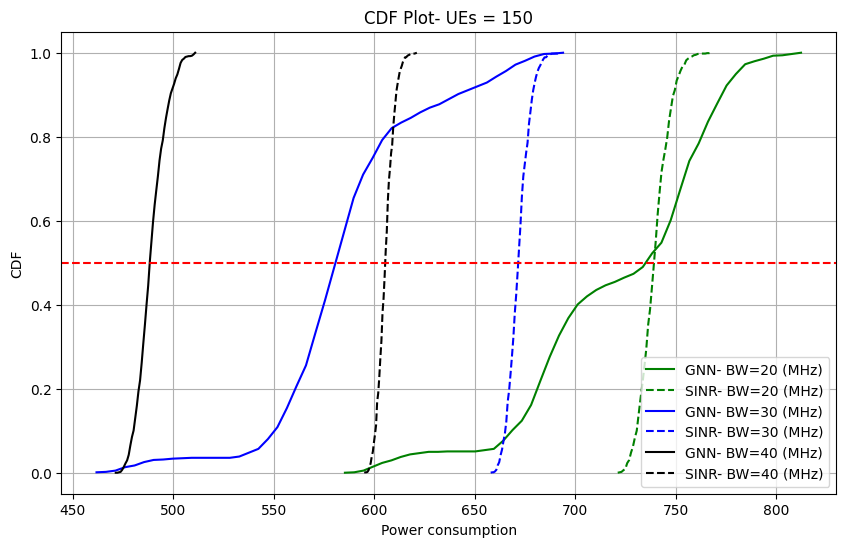

In [96]:
fig = plt.figure(figsize=(10, 6))
BW_ls=[10, 20, 30, 40, 50, 60, 80, 100]

i=1
plt.plot(GNN_bins_ls_20, GNN_cdf_ls_20, 'g', label='GNN- BW={} (MHz)'.format(BW_ls[i]))
plt.plot(SINR_bins_ls_20, SINR_cdf_ls_20, 'g--', label='SINR- BW={} (MHz)'.format(BW_ls[i]))
i=2
plt.plot(GNN_bins_ls_30, GNN_cdf_ls_30, 'b', label='GNN- BW={} (MHz)'.format(BW_ls[i]))
plt.plot(SINR_bins_ls_30, SINR_cdf_ls_30, 'b--', label='SINR- BW={} (MHz)'.format(BW_ls[i]))
i=3
plt.plot(GNN_bins_ls_40, GNN_cdf_ls_40, 'k', label='GNN- BW={} (MHz)'.format(BW_ls[i]))
plt.plot(SINR_bins_ls_40, SINR_cdf_ls_40, 'k--', label='SINR- BW={} (MHz)'.format(BW_ls[i]))
plt.axhline(y=0.5, color='r', linestyle='--')


plt.grid()
plt.legend()
plt.title('CDF Plot- UEs = 150')
plt.xlabel('Power consumption')     
plt.ylabel('CDF') 
plt.show()


# Save EPS

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


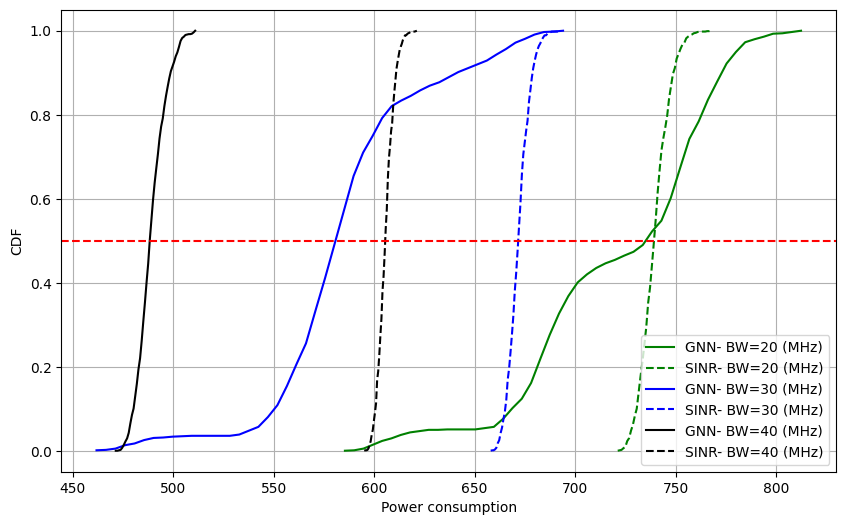

In [101]:
fig = plt.figure(figsize=(10, 6))
BW_ls=[10, 20, 30, 40, 50, 60, 80, 100]

i=1
plt.plot(GNN_bins_ls_20, GNN_cdf_ls_20, 'g', label='GNN- BW={} (MHz)'.format(BW_ls[i]))
plt.plot(SINR_bins_ls_20, SINR_cdf_ls_20, 'g--', label='SINR- BW={} (MHz)'.format(BW_ls[i]))
i=2
plt.plot(GNN_bins_ls_30, GNN_cdf_ls_30, 'b', label='GNN- BW={} (MHz)'.format(BW_ls[i]))
plt.plot(SINR_bins_ls_30, SINR_cdf_ls_30, 'b--', label='SINR- BW={} (MHz)'.format(BW_ls[i]))
i=3
plt.plot(GNN_bins_ls_40, GNN_cdf_ls_40, 'k', label='GNN- BW={} (MHz)'.format(BW_ls[i]))
plt.plot(SINR_bins_ls_40, SINR_cdf_ls_40, 'k--', label='SINR- BW={} (MHz)'.format(BW_ls[i]))
plt.axhline(y=0.5, color='r', linestyle='--')


plt.grid()
plt.legend()
# plt.title('CDF Plot- UEs = 150')
plt.xlabel('Power consumption')     
plt.ylabel('CDF') 
fig.savefig('CDF_150.eps', format='eps', dpi=1000)
fig.savefig("CDF_150.pdf")
plt.show()


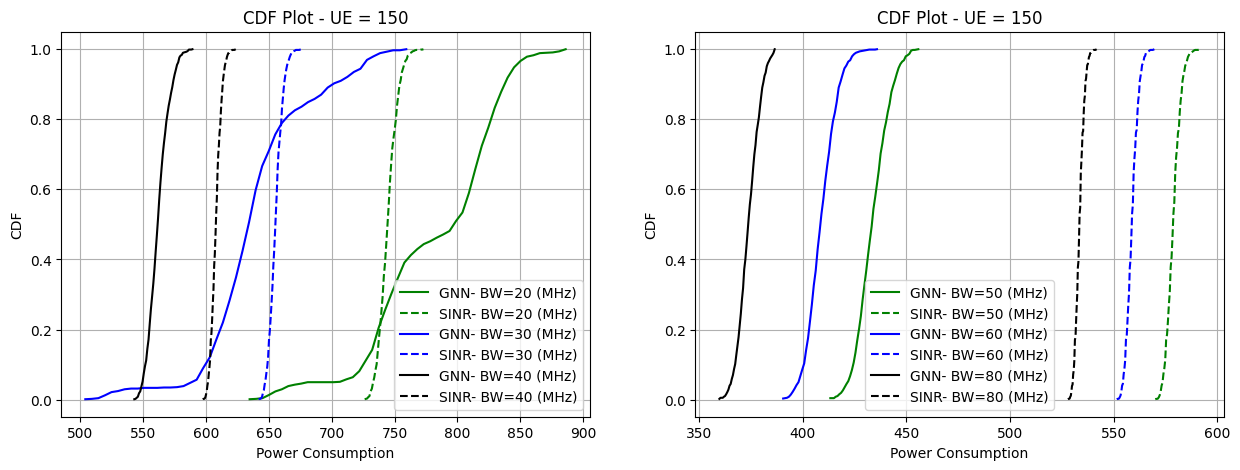

In [132]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

i=1
ax1.plot(GNN_cdf_ls[i]['bins'][1:], GNN_cdf_ls[i]['cdf'], 'g', label='GNN- BW={} (MHz)'.format(BW_ls[i]))
ax1.plot(SINR_cdf_ls[i]['bins'][1:], SINR_cdf_ls[i]['cdf'], 'g--', label='SINR- BW={} (MHz)'.format(BW_ls[i]))
i=2
ax1.plot(GNN_cdf_ls[i]['bins'][1:], GNN_cdf_ls[i]['cdf'], 'b', label='GNN- BW={} (MHz)'.format(BW_ls[i]))
ax1.plot(SINR_cdf_ls[i]['bins'][1:], SINR_cdf_ls[i]['cdf'], 'b--', label='SINR- BW={} (MHz)'.format(BW_ls[i]))
i=3
ax1.plot(GNN_cdf_ls[i]['bins'][1:], GNN_cdf_ls[i]['cdf'], 'k', label='GNN- BW={} (MHz)'.format(BW_ls[i]))
ax1.plot(SINR_cdf_ls[i]['bins'][1:], SINR_cdf_ls[i]['cdf'], 'k--', label='SINR- BW={} (MHz)'.format(BW_ls[i]))
ax1.grid()
ax1.legend()
ax1.set_xlabel('Power Consumption')
ax1.set_ylabel('CDF')
ax1.title.set_text('CDF Plot - UE = 150')



i=4
ax2.plot(GNN_cdf_ls[i]['bins'][1:], GNN_cdf_ls[i]['cdf'], 'g', label='GNN- BW={} (MHz)'.format(BW_ls[i]))
ax2.plot(SINR_cdf_ls[i]['bins'][1:], SINR_cdf_ls[i]['cdf'], 'g--', label='SINR- BW={} (MHz)'.format(BW_ls[i]))
i=5
ax2.plot(GNN_cdf_ls[i]['bins'][1:], GNN_cdf_ls[i]['cdf'], 'b', label='GNN- BW={} (MHz)'.format(BW_ls[i]))
ax2.plot(SINR_cdf_ls[i]['bins'][1:], SINR_cdf_ls[i]['cdf'], 'b--', label='SINR- BW={} (MHz)'.format(BW_ls[i]))
i=6
ax2.plot(GNN_cdf_ls[i]['bins'][1:], GNN_cdf_ls[i]['cdf'], 'k', label='GNN- BW={} (MHz)'.format(BW_ls[i]))
ax2.plot(SINR_cdf_ls[i]['bins'][1:], SINR_cdf_ls[i]['cdf'], 'k--', label='SINR- BW={} (MHz)'.format(BW_ls[i]))
ax2.grid()
ax2.legend()
ax2.set_xlabel('Power Consumption')
ax2.set_ylabel('CDF')
ax2.title.set_text('CDF Plot - UE = 150')



In [70]:
Max_PRB

111

In [75]:
def PWR_consmption(PrB_avg,Max_PRB, coefs, intercepts):
    
    frames= torch.div(PrB_avg,Max_PRB)
    partial_percentage = torch.fmod(frames,1)*100
    full_OFDM_frame_nom = frames-torch.fmod(frames,1)

    poly_features_test = torch.tensor([[x.item() , x.item()**2] for x in partial_percentage], dtype= torch.float32, device= device)
    partial_frame_power = torch.matmul(coefs[0],torch.t(poly_features_test))+intercepts*torch.where(partial_percentage > 0, 1, 0)
    full_frame_power = Max_power_per_OFDM_frame *full_OFDM_frame_nom 
    Net_Consumption_power = full_frame_power+ partial_frame_power
    
    return Net_Consumption_power

79


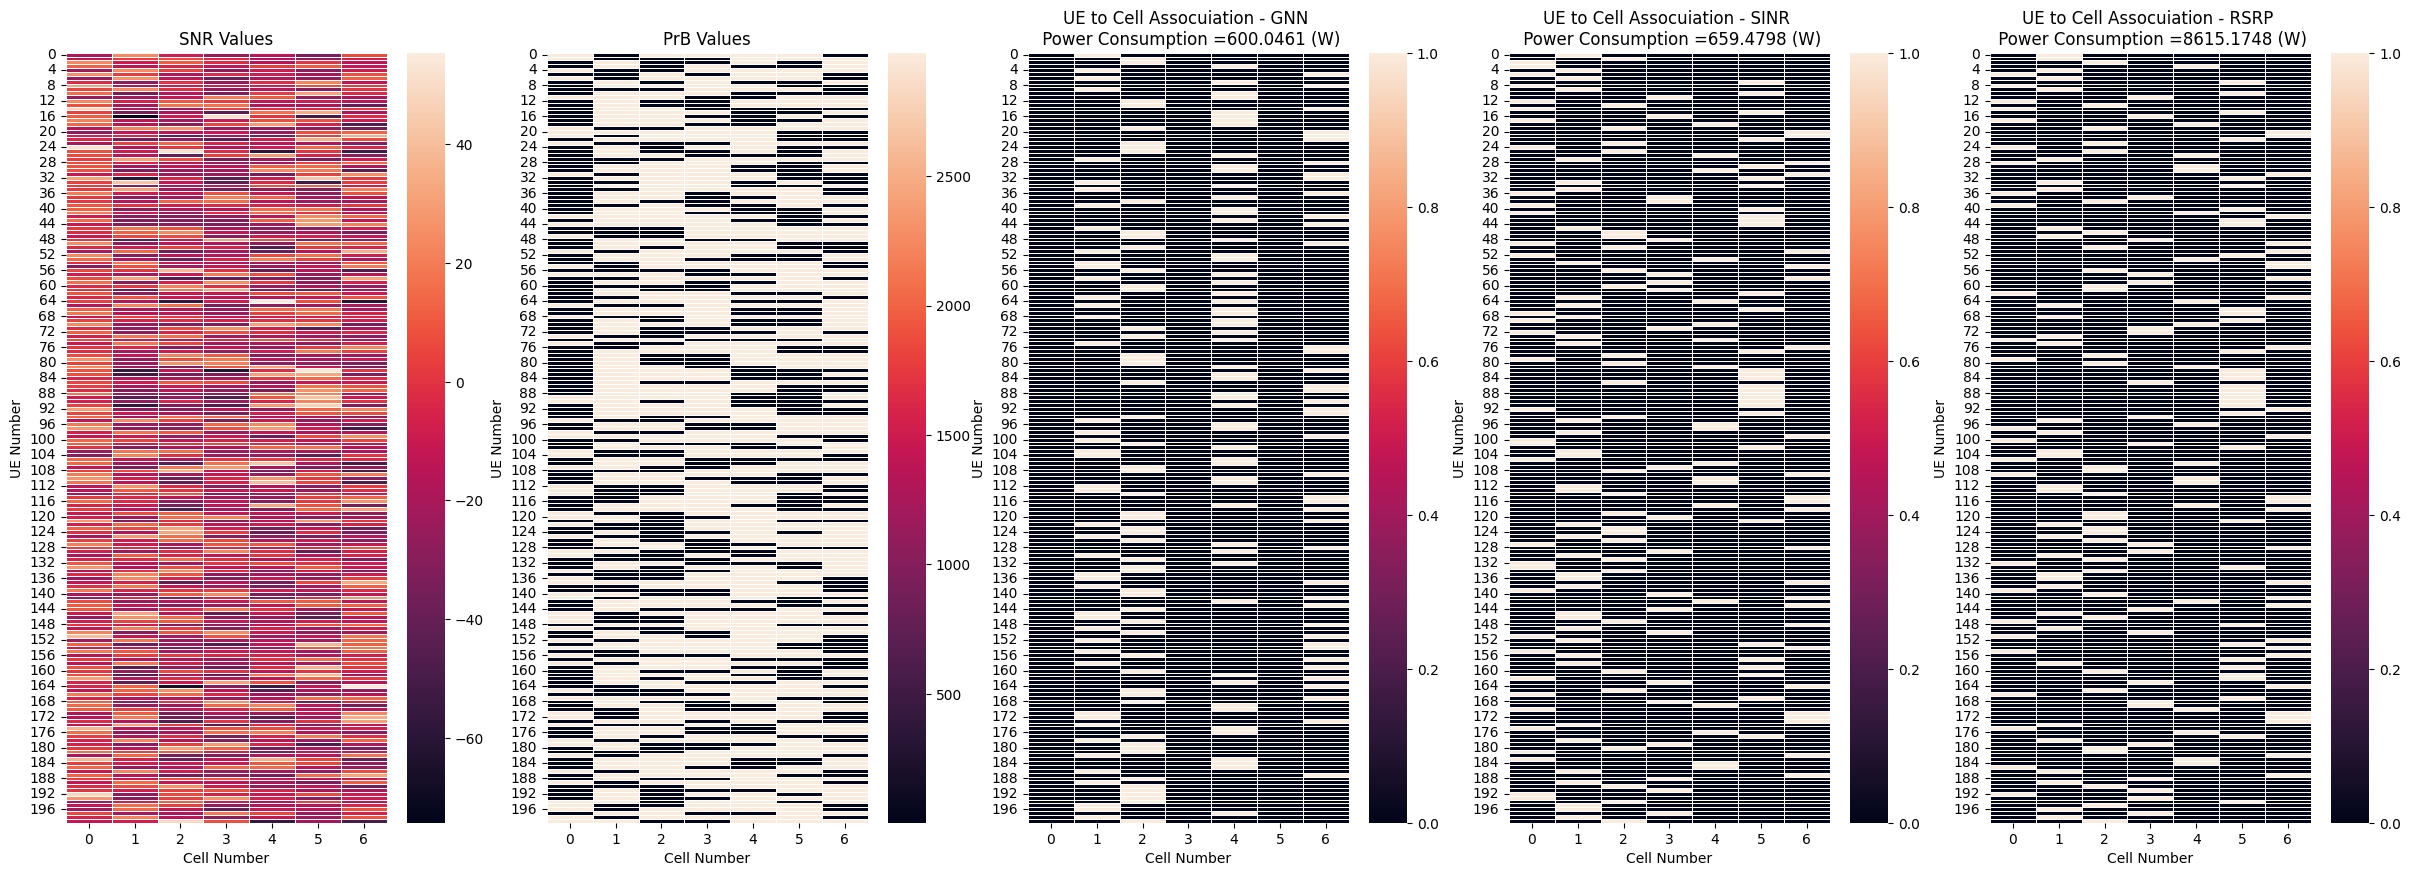

GNN:  PrB Distribution: tensor([  0.,  60., 105.,   0., 112.,   0.,  75.]), ====>> Total PrB: 352.0, ====>> Total PWR: 600.0461, ====>> PRB Norm 1: 352.0, ====>> PRB Norm 2: 181.0911407470703, ====>> Cells off: 3.0000
RSRP: PrB Distribution: tensor([3006.,   43.,   41.,   29.,   26.,   44., 3008.]), ====>> Total PrB: 6197.0, ====>> Total PWR: 8615.1748, ====>> PRB Norm 1: 6197.0, ====>> PRB Norm 2: 4253.361328125, ====>> Cells off: 0.0000
SINR: PrB Distribution: tensor([41., 46., 37., 23., 22., 34., 26.]), ====>> Total PrB: 229.0, ====>> Total PWR: 659.4798, ====>> PRB Norm 1: 229.0, ====>> PRB Norm 2: 89.50418853759766, ====>> Cells off: 0.0000


In [76]:
import torch_geometric
import networkx as nx
from torch_geometric.data import Data
import seaborn as sns
BS_nom = 7
UE_nom=200
device= 'cpu'

sample_nom =np.random.randint(200)
print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()
data_test=list(enumerate(test_loader))[sample_nom][1]
out_test = GNN_homo_model(data_test)  # Perform a single forward pass.


out_test= out_test.to('cpu')

T_GNN= torch.zeros((UE_nom,BS_nom))
L_GNN= torch.argmax(out_test, dim=1)
for l in range(len(L_GNN)):
    T_GNN[l,L_GNN[l].item()] = 1
T_RSRP = data_test['UE_Ass_rsrp_mtx']
T_SINR = data_test['UE_Ass_sinr_mtx']

## Power Consumption
BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
# Power_Cons_GNN = torch.tensor( regr.predict(BS_PRB_GNN.reshape(-1, 1))).sum()
# Power_Cons_RSRP = torch.tensor( regr.predict(BS_PRB_RSRP.reshape(-1, 1))).sum()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)
max_PrB_percentage= 100
poly_features_max = torch.tensor([[x , x**2] for x in [max_PrB_percentage]], dtype= torch.float32, device= device)
Max_power_per_OFDM_frame = torch.matmul(coefs[0],torch.t(poly_features_max))+intercepts
# poly_features_GNN = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_GNN], dtype= torch.float32, device= device)
# Power_Cons_GNN= torch.matmul(coefs[0],torch.t(poly_features_GNN))+intercepts*torch.where(BS_PRB_GNN > 0, 1, 0)

# poly_features_RSRP = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_RSRP], dtype= torch.float32, device= device)
# Power_Cons_RSRP= torch.matmul(coefs[0],torch.t(poly_features_RSRP))+intercepts*torch.where(BS_PRB_RSRP > 0, 1, 0)

# poly_features_SINR = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_SINR], dtype= torch.float32, device= device)
# Power_Cons_SINR= torch.matmul(coefs[0],torch.t(poly_features_SINR))+intercepts*torch.where(BS_PRB_SINR > 0, 1, 0)

Power_Cons_GNN = PWR_consmption(BS_PRB_GNN,Max_PRB, coefs, intercepts)
# Power_Cons_GNN = Power_Cons_GNN_vec.sum()
Power_Cons_RSRP = PWR_consmption(BS_PRB_RSRP,Max_PRB, coefs, intercepts)
# Power_Cons_RSRP = Power_Cons_RSRP_vec.sum()
Power_Cons_SINR = PWR_consmption(BS_PRB_SINR,Max_PRB, coefs, intercepts)
# Power_Cons_SINR = Power_Cons_SINR_vec.sum()

fig = plt.figure(figsize=(30, 10))

ax2 = fig.add_subplot(1, 5, 1)
sns.heatmap(data_test['SINR_mtx'].detach().numpy().transpose() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('SNR Values')


ax1 = fig.add_subplot(1, 5, 2)
sns.heatmap(data_test['UE_PRB_All_cells'].detach().numpy() , linewidth=0.5)
ax1.set_xlabel('Cell Number')
ax1.set_ylabel('UE Number')
ax1.set_title('PrB Values')

ax2 = fig.add_subplot(1, 5, 3)
sns.heatmap(out_test.detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - GNN \n Power Consumption ={:.4f} (W)'.format(Power_Cons_GNN.sum()))

ax2 = fig.add_subplot(1, 5, 4)
sns.heatmap(data_test['UE_Ass_sinr_mtx'].detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - SINR \n Power Consumption ={:.4f} (W)'.format(Power_Cons_SINR.sum()))


ax2 = fig.add_subplot(1, 5, 5)
sns.heatmap(data_test['UE_Ass_rsrp_mtx'].detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - RSRP \n Power Consumption ={:.4f} (W)'.format(Power_Cons_RSRP.sum()))


plt.show()


print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}, ====>> PRB Norm 1: {torch.norm(BS_PRB_GNN, p=1).item()}, ====>> PRB Norm 2: {torch.norm(BS_PRB_GNN, p=2).item()}, ====>> Cells off: {7-torch.count_nonzero(BS_PRB_GNN).item():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}, ====>> PRB Norm 1: {torch.norm(BS_PRB_RSRP, p=1).item()}, ====>> PRB Norm 2: {torch.norm(BS_PRB_RSRP, p=2).item()}, ====>> Cells off: {7-torch.count_nonzero(BS_PRB_RSRP).item():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}, ====>> PRB Norm 1: {torch.norm(BS_PRB_SINR, p=1).item()}, ====>> PRB Norm 2: {torch.norm(BS_PRB_SINR, p=2).item()}, ====>> Cells off: {7-torch.count_nonzero(BS_PRB_SINR).item():.4f}')

# # x = torch.tensor(UE_feature_mtx, dtype=torch.float32) 
# Homodata = Data(x=data_test.x, edge_index=data_test.edge_index)
    
# ## find color map
# edge_index = (T_GNN > 0).nonzero().t()
# row, col = edge_index
# # edge_index
# colors=['red', 'blue', 'green', 'magenta', 'yellow', 'cyan', 'gray']
# color_map_GNN=[]
# color_map_RSRP=[]
# color_map_SINR=[]
# for t in range(UE_nom):
#     color_map_GNN.append(colors[[idx for idx in range(BS_nom) if T_GNN[t,idx]==1][0]])
#     color_map_RSRP.append(colors[[idx for idx in range(BS_nom) if T_RSRP[t,idx]==1][0]])
#     color_map_SINR.append(colors[[idx for idx in range(BS_nom) if T_SINR[t,idx]==1][0]])

    
    
    
# g_GNN = torch_geometric.utils.to_networkx(Homodata, remove_self_loops=True)

# # random_pos = nx.random_layout(graph, seed=42)
# # pos = nx.spring_layout(graph, pos=random_pos)
# pos = nx.spring_layout(g_GNN)


# # larger figure size
# fig = plt.figure(figsize=(30,10))
# ax1 = fig.add_subplot(1, 3, 1)

# # nx.draw_networkx(G,
# #                 pos=nx.spring_layout(G, seed=0),
# #                 with_labels=True,
# #                 node_size=800,
# #                 node_color=data.y,
# #                 cmap="hsv",
# #                 vmin=-2,
# #                 vmax=3,
# #                 width=0.8,
# #                 edge_color="grey",
# #                 font_size=14
# #                 )


# nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_GNN, pos=pos, ax=ax1)
# ax1.set_title('UE Assocuiation - GNN\n Power Consumption ={:.4f} (W)'.format(Power_Cons_GNN.sum()))

# ax2 = fig.add_subplot(1, 3, 2)
# nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_SINR, pos=pos, ax=ax2)
# ax2.set_title('UE Assocuiation - SINR \n Power Consumption ={:.4f} (W)'.format(Power_Cons_SINR.sum()))

# ax3 = fig.add_subplot(1, 3, 3)
# nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_RSRP, pos=pos, ax=ax3)
# ax3.set_title('UE Assocuiation - RSRP \n Power Consumption ={:.4f} (W)'.format(Power_Cons_RSRP.sum()))

# # plt.savefig('figs/NXPlot_TraceConst_HomoGraph_infPrB_v4.png')
# # plt.savefig('figs/NXPlot_TraceConst_HomoGraph_infPrB_v4.pdf')


# plt.show()

# print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
# print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')
# print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')

In [77]:

print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}, ====>> PRB Norm 1: {torch.norm(BS_PRB_GNN, p=1).item()}, ====>> PRB Norm 2: {torch.norm(BS_PRB_GNN, p=2).item()}, ====>> Cells off: {7-torch.count_nonzero(BS_PRB_GNN).item():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}, ====>> PRB Norm 1: {torch.norm(BS_PRB_RSRP, p=1).item()}, ====>> PRB Norm 2: {torch.norm(BS_PRB_RSRP, p=2).item()}, ====>> Cells off: {7-torch.count_nonzero(BS_PRB_RSRP).item():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}, ====>> PRB Norm 1: {torch.norm(BS_PRB_SINR, p=1).item()}, ====>> PRB Norm 2: {torch.norm(BS_PRB_SINR, p=2).item()}, ====>> Cells off: {7-torch.count_nonzero(BS_PRB_SINR).item():.4f}')


GNN:  PrB Distribution: tensor([  0.,  60., 105.,   0., 112.,   0.,  75.]), ====>> Total PrB: 352.0, ====>> Total PWR: 600.0461, ====>> PRB Norm 1: 352.0, ====>> PRB Norm 2: 181.0911407470703, ====>> Cells off: 3.0000
RSRP: PrB Distribution: tensor([3006.,   43.,   41.,   29.,   26.,   44., 3008.]), ====>> Total PrB: 6197.0, ====>> Total PWR: 8615.1748, ====>> PRB Norm 1: 6197.0, ====>> PRB Norm 2: 4253.361328125, ====>> Cells off: 0.0000
SINR: PrB Distribution: tensor([41., 46., 37., 23., 22., 34., 26.]), ====>> Total PrB: 229.0, ====>> Total PWR: 659.4798, ====>> PRB Norm 1: 229.0, ====>> PRB Norm 2: 89.50418853759766, ====>> Cells off: 0.0000


## PWR vs BW

In [79]:
import torch_geometric
import networkx as nx
from torch_geometric.data import Data
import seaborn as sns
BS_nom = 7
device= 'cpu'

sample_nom =np.random.randint(200)
print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)
# data_test_ls = [i for j, i in enumerate(test_loader) if j not in [65,75]]
# data_test_ls = [i for j, i in enumerate(test_loader)]

test_ls = [i for j, i in enumerate(test_loader)]
train_ls = [i for j, i in enumerate(train_loader)]

data_test_ls = test_ls + train_ls


Avg_PWR_GNN=[]
Avg_PWR_RSRP=[]
Avg_PWR_SINR=[]
BW_ls=[40]## MHz
PRB_bw=360# Khz
Max_PRB_ls=[1000*i/PRB_bw for i in BW_ls]


for Max_PRB in Max_PRB_ls:
    GNN_PWR_sample_ls=[]
    RSRP_PWR_sample_ls=[]
    SINR_PWR_sample_ls=[]
    
    PRB_norm1_GNN=[]
    PRB_norm1_SINR=[]
    PRB_norm1_RSRP=[]

    PRB_norm2_GNN=[]
    PRB_norm2_SINR=[]
    PRB_norm2_RSRP=[]

    Cell_off_GNN=[]
    Cell_off_RSRP=[]
    Cell_off_SINR=[]


    for data_test in data_test_ls:
        data_test= data_test.to(device)
        out_test = GNN_homo_model(data_test)  # Perform a single forward pass.

        T_GNN= torch.zeros((UE_nom,BS_nom))
        L_GNN= torch.argmax(out_test, dim=1)
        for l in range(len(L_GNN)):
            T_GNN[l,L_GNN[l].item()] = 1
        T_RSRP = data_test['UE_Ass_rsrp_mtx']
        T_SINR = data_test['UE_Ass_sinr_mtx']

        ## RRBs
        BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
        BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
        BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
        
        PRB_norm1_GNN.append(torch.norm(BS_PRB_GNN, p=1).item())
        PRB_norm1_SINR.append(torch.norm(BS_PRB_SINR, p=1).item())
        PRB_norm1_RSRP.append(torch.norm(BS_PRB_RSRP, p=1).item())
        
        PRB_norm2_GNN.append(torch.norm(BS_PRB_GNN, p=2).item())
        PRB_norm2_SINR.append(torch.norm(BS_PRB_SINR, p=2).item())
        PRB_norm2_RSRP.append(torch.norm(BS_PRB_RSRP, p=2).item())
        
        Cell_off_GNN.append(7-torch.count_nonzero(BS_PRB_GNN).item())
        Cell_off_RSRP.append(7-torch.count_nonzero(BS_PRB_RSRP).item())
        Cell_off_SINR.append(7-torch.count_nonzero(BS_PRB_SINR).item())
        

        Power_Cons_GNN =  PWR_consmption(BS_PRB_GNN, Max_PRB, coefs, intercepts)
        Power_Cons_RSRP = PWR_consmption(BS_PRB_RSRP,Max_PRB, coefs, intercepts)
        Power_Cons_SINR = PWR_consmption(BS_PRB_SINR,Max_PRB, coefs, intercepts)
        GNN_PWR_sample_ls.append(Power_Cons_GNN.sum())
        RSRP_PWR_sample_ls.append(Power_Cons_RSRP.sum())
        SINR_PWR_sample_ls.append(Power_Cons_SINR.sum())





189


In [80]:
print(Avg_PWR_GNN )
print(Avg_PWR_RSRP )
print(Avg_PWR_SINR )

GNN_to_SINR = 100*(Avg_PWR_SINR[0] - Avg_PWR_GNN[0])/Avg_PWR_SINR[0]
GNN_to_RSRP = 100*(Avg_PWR_RSRP[0] - Avg_PWR_GNN[0])/Avg_PWR_RSRP[0]
print(f'GNN to SINR %: {GNN_to_SINR:03f}')
print(f'GNN to RSRP %: {GNN_to_RSRP:03f}')



print(f'GNN: PRB Norm 1: {np.mean(PRB_norm1_GNN):.4f}, ====>> PRB Norm 2: {np.mean(PRB_norm1_GNN):.4f}, ====>> Cells off: {np.mean(Cell_off_GNN):.4f}')
print(f'RSRP: PRB Norm 1: {np.mean(PRB_norm1_RSRP):.4f}, ====>> PRB Norm 2: {np.mean(PRB_norm1_RSRP):.4f}, ====>> Cells off: {np.mean(Cell_off_RSRP):.4f}')
print(f'SINR: PRB Norm 1: {np.mean(PRB_norm1_SINR):.4f}, ====>> PRB Norm 2: {np.mean(PRB_norm2_SINR):.4f}, ====>> Cells off: {np.mean(Cell_off_SINR):.4f}')

[583.4629]
[5078.5596]
[655.4859]
GNN to SINR %: 10.987728
GNN to RSRP %: 88.511252
GNN: PRB Norm 1: 342.4460, ====>> PRB Norm 2: 342.4460, ====>> Cells off: 3.0000
RSRP: PRB Norm 1: 3563.4670, ====>> PRB Norm 2: 3563.4670, ====>> Cells off: 0.0000
SINR: PRB Norm 1: 224.0670, ====>> PRB Norm 2: 86.7441, ====>> Cells off: 0.0000


In [81]:
Max_PRB

111.11111111111111

Text(0.5, 1.0, 'Histogram of PWR Consumption - UEs = 200, BW = 40 MHz')

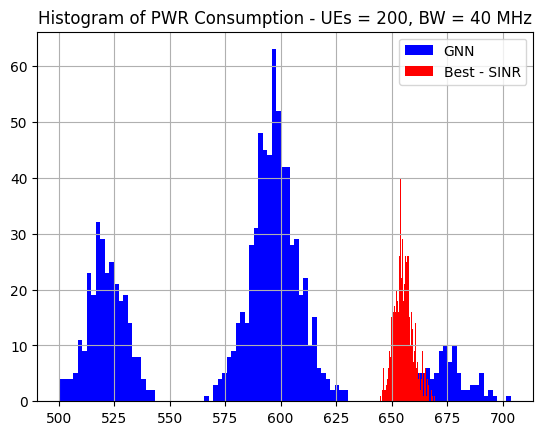

In [84]:
GNN_PWR_sample_ls_np = [i.item() for i in GNN_PWR_sample_ls]
SINR_PWR_sample_ls_np = [i.item() for i in SINR_PWR_sample_ls]

# m= GNN_PWR_sample_ls_np.index(np.max(GNN_PWR_sample_ls_np))
# GNN_PWR_sample_ls_np.pop(m)

hist, bin_edges = np.histogram(GNN_PWR_sample_ls_np, density=True)
_ = plt.hist(GNN_PWR_sample_ls_np, bins= 100, color='blue', label='GNN')  # arguments are passed to np.histogram
_ = plt.hist(SINR_PWR_sample_ls_np, bins= 100, color='red', label='Best - SINR')  # arguments are passed to np.histogram

plt.grid()
plt.legend()
plt.title('Histogram of PWR Consumption - UEs = 200, BW = 40 MHz')

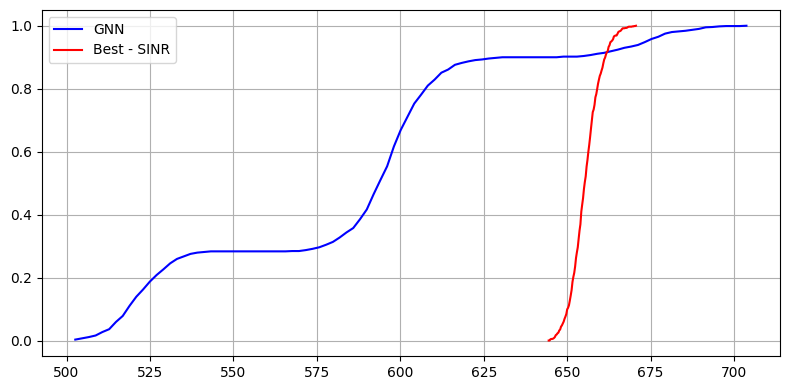

In [86]:
GNN_PWR_sample_ls_np

import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [8,4]
plt.rcParams["figure.autolayout"] = True


data = np.array(GNN_PWR_sample_ls_np)
count, bins = np.histogram(data, bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins[1:], cdf, color='blue', label="GNN")


data = np.array(SINR_PWR_sample_ls_np)
count, bins = np.histogram(data, bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins[1:], cdf, color='red', label="Best - SINR")

plt.grid()
plt.legend()
plt.show()

In [211]:
GNN_50 = [606.233228, 475.511446, 408.407447, 388.463613, 378.463613,  367.632848, 357.271462,  350.290500]
SINR_50 = [653.819602, 558.244501, 512.609581, 501.459045, 494.459045, 490.086426, 481.316849,  476.028453]
RSRP_50 = [5211.42509, 2830.29283, 2034.00970, 1635.35272, 1435.35272, 1236.35216, 1046.25104,  921.460857]
GNN_SINR_50 = [100*(SINR_50[i] - GNN_50[i])/SINR_50[i] for i in range(len(GNN_50))]
GNN_RSRP_50 = [100*(RSRP_50[i] - GNN_50[i])/RSRP_50[i] for i in range(len(GNN_50))]

GNN_100  = [879.96082, 563.17934, 485.56053, 447.90518,  423.63396, 400.67449, 379.02530, 367.32797]
SINR_100 = [831.48633, 655.27073, 591.86930, 558.90465,  538.72764, 525.10324, 507.89197, 497.46654]
RSRP_100 = [9142.0640, 4786.3495, 3343.7126, 2614.6076,  2188.6074, 1883.2025, 1532.0164, 1307.8158]
GNN_SINR_100 = [100*(SINR_100[i] - GNN_100[i])/SINR_100[i] for i in range(len(GNN_100))]
GNN_RSRP_100 = [100*(RSRP_100[i] - GNN_100[i])/RSRP_100[i] for i in range(len(GNN_100))]


GNN_150 = [1509.5008, 783.10451,  608.9727, 503.39162, 446.82404, 422.78721, 399.06423, 382.42976,]
SINR_150 = [1102.6869, 744.91110,  655.4462, 608.09573, 578.80187, 558.90450, 533.61863, 518.22622,]
RSRP_150 = [13471.094, 7164.2254,  4737.845, 3665.8592, 3016.8080, 2591.5162, 2051.3607, 1715.9639,]
GNN_SINR_150 = [100*(SINR_150[i] - GNN_150[i])/SINR_150[i] for i in range(len(GNN_150))]
GNN_RSRP_150 = [100*(RSRP_150[i] - GNN_150[i])/RSRP_150[i] for i in range(len(GNN_150))]


GNN_200  = [1986.70974, 897.93282, 651.2098, 563.46293,  512.73159, 488.66217, 452.02234,423.55314]
SINR_200 = [1473.92356, 827.44330, 715.8387, 655.48583,  617.70678, 591.89410, 558.88482,538.68976]
RSRP_200 =[19237.0219, 9666.5038, 6615.842, 5078.5597,  4129.7561, 3537.8324, 2744.8381,2266.8261]
GNN_SINR_200 = [100*(SINR_200[i] - GNN_200[i])/SINR_200[i] for i in range(len(GNN_200))]
GNN_RSRP_200 = [100*(RSRP_200[i] - GNN_200[i])/RSRP_200[i] for i in range(len(GNN_200))]

In [212]:
# GNN_50 = [606.233228, 505.511446, 408.407447, 388.463613, 378.463613, 367.632848, 357.271462,  350.290500]
# SINR_50 = [653.819602, 558.244501, 524.609581, 507.459045, 500.459045, 490.086426, 481.316849,  476.028453]
# RSRP_50 = [5211.42509, 2830.29283, 2034.00970, 1635.35272, 1435.35272, 1236.35216, 1046.25104,  921.460857]
# GNN_SINR_50 = [  7.278211, 9.446229, 22.150212, 23.449268, 24.449268,24.986119 , 25.772085,  26.413958]
# GNN_RSRP_50 = [  88.36722, 82.13925, 79.921067, 76.245882, 74.245882,70.264714 , 65.852224,  61.985309]


# GNN_100  = [879.96082, 563.17934, 485.56053, 447.90518,  426.63396, 362.67449, 389.02530, 333.32797]
# SINR_100 = [831.48633, 655.27073, 591.86930, 558.90465,  538.72764, 525.10324, 507.89197, 497.46654]
# RSRP_100 = [9142.0640, 4786.3495, 3343.7126, 2614.6076,  2188.6074, 1883.2025, 1532.0164, 1307.8158]
# GNN_SINR_100 = [-5.829859, 14.053946, 17.961527, 19.860180,  20.807115, 30.932727, 23.403926, 32.994895]
# GNN_RSRP_100 = [90.374594, 88.233635, 85.478401, 82.869124,  80.506602, 80.741610, 74.606977, 74.512622]


# GNN_150 = [1509.5008, 783.10451,  638.9727, 503.39162, 433.82404, 408.78721, 374.06423, 352.42976,]
# SINR_150 = [1102.6869, 744.91110,  655.4462, 608.09573, 578.80187, 558.90450, 533.61863, 518.22622,]
# RSRP_150 = [13471.094, 7164.2254,  4737.845, 3665.8592, 3016.8080, 2591.5162, 2051.3607, 1715.9639,]
# GNN_SINR_150 = [-36.89297, -5.127244,  2.513317, 17.218360, 25.047919, 26.859203, 29.900455, 31.993067,]
# GNN_RSRP_150 = [88.794520, 89.069237,  86.51343, 86.26811, 85.619766, 84.225944, 81.765068, 79.461703,]


# GNN_200  = [1986.70974, 897.93282, 651.2098, 583.46293,  512.73159, 495.66217, 462.02234,423.55314]
# SINR_200 = [1473.92356, 827.44330, 715.8387, 655.48583,  617.70678, 591.89410, 558.88482,538.68976]
# RSRP_200 =[19237.0219, 9666.5038, 6615.842, 5078.5597,  4129.7561, 3537.8324, 2744.8381,2266.8261]
# GNN_SINR_200 =[-34.790554, -8.518955, 9.028421, 10.987712,  16.994341, 16.258301, 17.331385,21.373456]
# GNN_RSRP_2000 = [89.672467, 90.710883, 90.15681, 88.511252,  87.584458, 85.989665, 83.167592,81.315146]


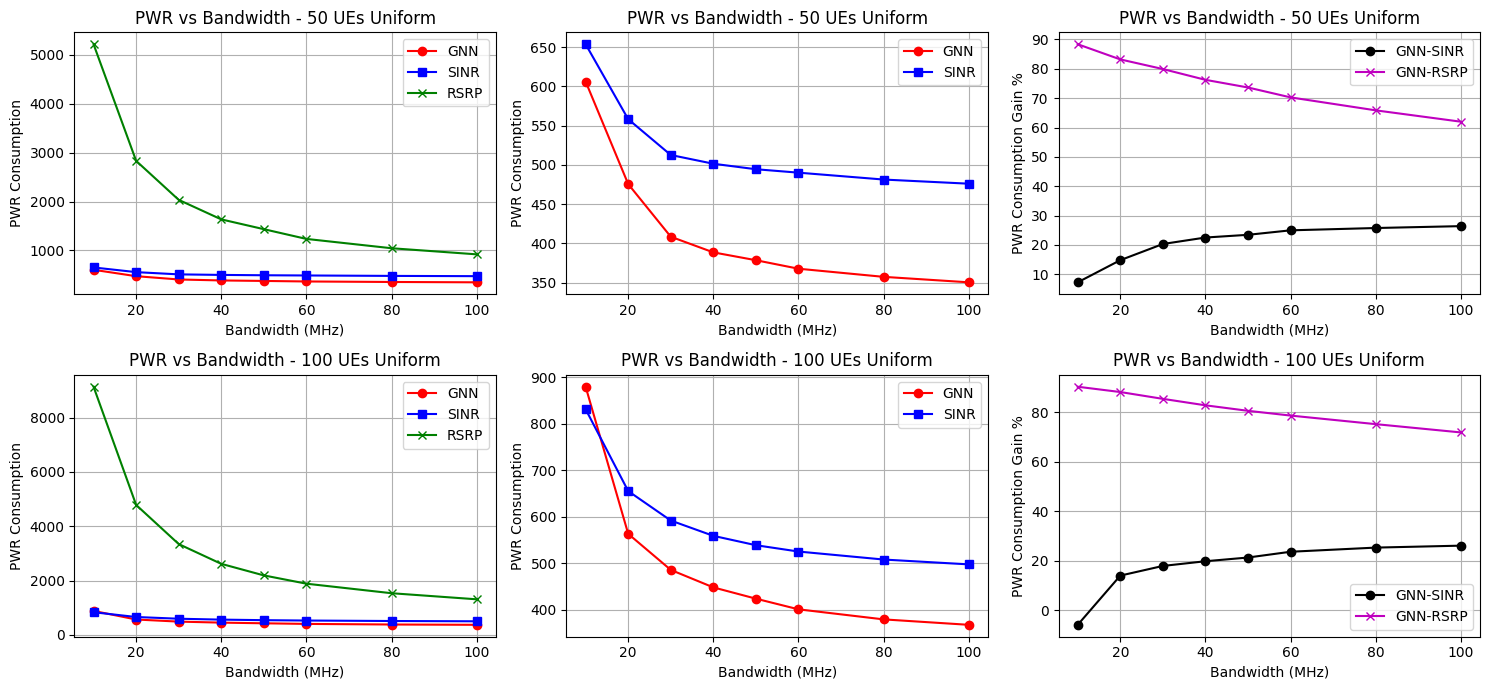

In [213]:
bw=[10, 20, 40]
bw_full=[10, 20, 30, 40, 50, 60, 80, 100]

# GNN_50=[637.97455, 505.51144, 388.46362, 367.63287, 357.2715, 353.373]
# SINR_50=[653.81964, 558.2445, 507.45908, 490.08643, 481.31683, 476.02844]
# RSRP_50=[5211.425, 2830.293,1635.3528, 1236.3522, 1046.2511, 921.4609]

# GNN_SINR_50=[2.423, 9.44, 23.44, 24.98, 25.77, 25.77]
# GNN_RSRP_50=[87.75, 82.13, 76.24, 70.26, 65.85, 61.65]

# GNN_100=[879.9053, 563.17584, 451.87494]
# SINR_100=[831.50134, 655.27515, 558.9046]
# RSRP_100=[9142.166, 4794.247 , 2614.6077]

# GNN_SINR_100=[-5.1, 14.055058, 19.149898]
# GNN_RSRP_100=[90.75, 88.253092, 82.717292]

    
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)

ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)


ax1.plot(bw_full, GNN_50, 'r-o', label='GNN')
ax1.plot(bw_full, SINR_50, 'b-s', label='SINR')
ax1.plot(bw_full, RSRP_50, 'g-x', label='RSRP')
ax1.set_xlabel('Bandwidth (MHz)')
ax1.set_ylabel('PWR Consumption')
ax1.set_title('PWR vs Bandwidth - 50 UEs Uniform')
ax1.legend()
ax1.grid()


ax2.plot(bw_full, GNN_50, 'r-o', label='GNN')
ax2.plot(bw_full, SINR_50, 'b-s', label='SINR')
ax2.set_xlabel('Bandwidth (MHz)')
ax2.set_ylabel('PWR Consumption')
ax2.set_title('PWR vs Bandwidth - 50 UEs Uniform')
ax2.legend()
ax2.grid()


ax3.plot(bw_full, GNN_SINR_50, 'k-o', label='GNN-SINR')
ax3.plot(bw_full, GNN_RSRP_50, 'm-x', label='GNN-RSRP')
ax3.set_xlabel('Bandwidth (MHz)')
ax3.set_ylabel('PWR Consumption Gain %')
ax3.set_title('PWR vs Bandwidth - 50 UEs Uniform')
ax3.legend()
ax3.grid()

ax4.plot(bw_full, GNN_100, 'r-o', label='GNN')
ax4.plot(bw_full, SINR_100, 'b-s', label='SINR')
ax4.plot(bw_full, RSRP_100, 'g-x', label='RSRP')
ax4.set_xlabel('Bandwidth (MHz)')
ax4.set_ylabel('PWR Consumption')
ax4.set_title('PWR vs Bandwidth - 100 UEs Uniform')
ax4.legend()
ax4.grid()
# ax4.set_xlim([10,100])

ax5.plot(bw_full, GNN_100, 'r-o', label='GNN')
ax5.plot(bw_full, SINR_100, 'b-s', label='SINR')
ax5.set_xlabel('Bandwidth (MHz)')
ax5.set_ylabel('PWR Consumption')
ax5.set_title('PWR vs Bandwidth - 100 UEs Uniform')
ax5.legend()
ax5.grid()
# ax5.set_xlim([10,100])

ax6.plot(bw_full, GNN_SINR_100, 'k-o', label='GNN-SINR')
ax6.plot(bw_full, GNN_RSRP_100, 'm-x', label='GNN-RSRP')
ax6.set_xlabel('Bandwidth (MHz)')
ax6.set_ylabel('PWR Consumption Gain %')
ax6.set_title('PWR vs Bandwidth - 100 UEs Uniform')
ax6.legend()
ax6.grid()
# ax6.set_xlim([10,100])




plt.show()

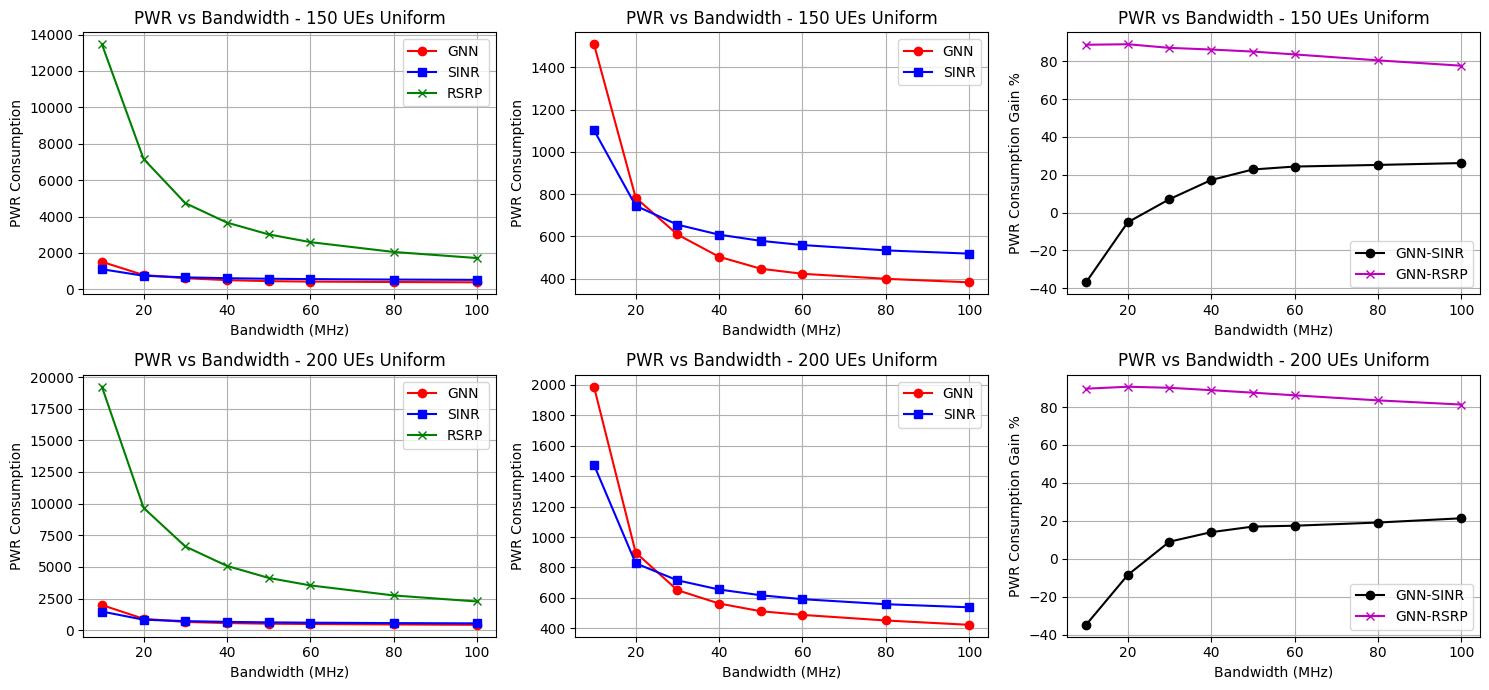

In [214]:
bw=[10, 20, 40]
bw_full=[10, 20, 30, 40, 50, 60, 80, 100]

# GNN_50=[637.97455, 505.51144, 388.46362, 367.63287, 357.2715, 353.373]
# SINR_50=[653.81964, 558.2445, 507.45908, 490.08643, 481.31683, 476.02844]
# RSRP_50=[5211.425, 2830.293,1635.3528, 1236.3522, 1046.2511, 921.4609]

# GNN_SINR_50=[2.423, 9.44, 23.44, 24.98, 25.77, 25.77]
# GNN_RSRP_50=[87.75, 82.13, 76.24, 70.26, 65.85, 61.65]

# GNN_100=[879.9053, 563.17584, 451.87494]
# SINR_100=[831.50134, 655.27515, 558.9046]
# RSRP_100=[9142.166, 4794.247 , 2614.6077]

# GNN_SINR_100=[-5.1, 14.055058, 19.149898]
# GNN_RSRP_100=[90.75, 88.253092, 82.717292]

    
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)

ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)


ax1.plot(bw_full, GNN_150, 'r-o', label='GNN')
ax1.plot(bw_full, SINR_150, 'b-s', label='SINR')
ax1.plot(bw_full, RSRP_150, 'g-x', label='RSRP')
ax1.set_xlabel('Bandwidth (MHz)')
ax1.set_ylabel('PWR Consumption')
ax1.set_title('PWR vs Bandwidth - 150 UEs Uniform')
ax1.legend()
ax1.grid()


ax2.plot(bw_full, GNN_150, 'r-o', label='GNN')
ax2.plot(bw_full, SINR_150, 'b-s', label='SINR')
ax2.set_xlabel('Bandwidth (MHz)')
ax2.set_ylabel('PWR Consumption')
ax2.set_title('PWR vs Bandwidth - 150 UEs Uniform')
ax2.legend()
ax2.grid()


ax3.plot(bw_full, GNN_SINR_150, 'k-o', label='GNN-SINR')
ax3.plot(bw_full, GNN_RSRP_150, 'm-x', label='GNN-RSRP')
ax3.set_xlabel('Bandwidth (MHz)')
ax3.set_ylabel('PWR Consumption Gain %')
ax3.set_title('PWR vs Bandwidth - 150 UEs Uniform')
ax3.legend()
ax3.grid()

ax4.plot(bw_full, GNN_200, 'r-o', label='GNN')
ax4.plot(bw_full, SINR_200, 'b-s', label='SINR')
ax4.plot(bw_full, RSRP_200, 'g-x', label='RSRP')
ax4.set_xlabel('Bandwidth (MHz)')
ax4.set_ylabel('PWR Consumption')
ax4.set_title('PWR vs Bandwidth - 200 UEs Uniform')
ax4.legend()
ax4.grid()
# ax4.set_xlim([10,100])

ax5.plot(bw_full, GNN_200, 'r-o', label='GNN')
ax5.plot(bw_full, SINR_200, 'b-s', label='SINR')
ax5.set_xlabel('Bandwidth (MHz)')
ax5.set_ylabel('PWR Consumption')
ax5.set_title('PWR vs Bandwidth - 200 UEs Uniform')
ax5.legend()
ax5.grid()
# ax5.set_xlim([10,100])

ax6.plot(bw_full, GNN_SINR_200, 'k-o', label='GNN-SINR')
ax6.plot(bw_full, GNN_RSRP_200, 'm-x', label='GNN-RSRP')
ax6.set_xlabel('Bandwidth (MHz)')
ax6.set_ylabel('PWR Consumption Gain %')
ax6.set_title('PWR vs Bandwidth - 200 UEs Uniform')
ax6.legend()
ax6.grid()
# ax6.set_xlim([10,100])




plt.show()

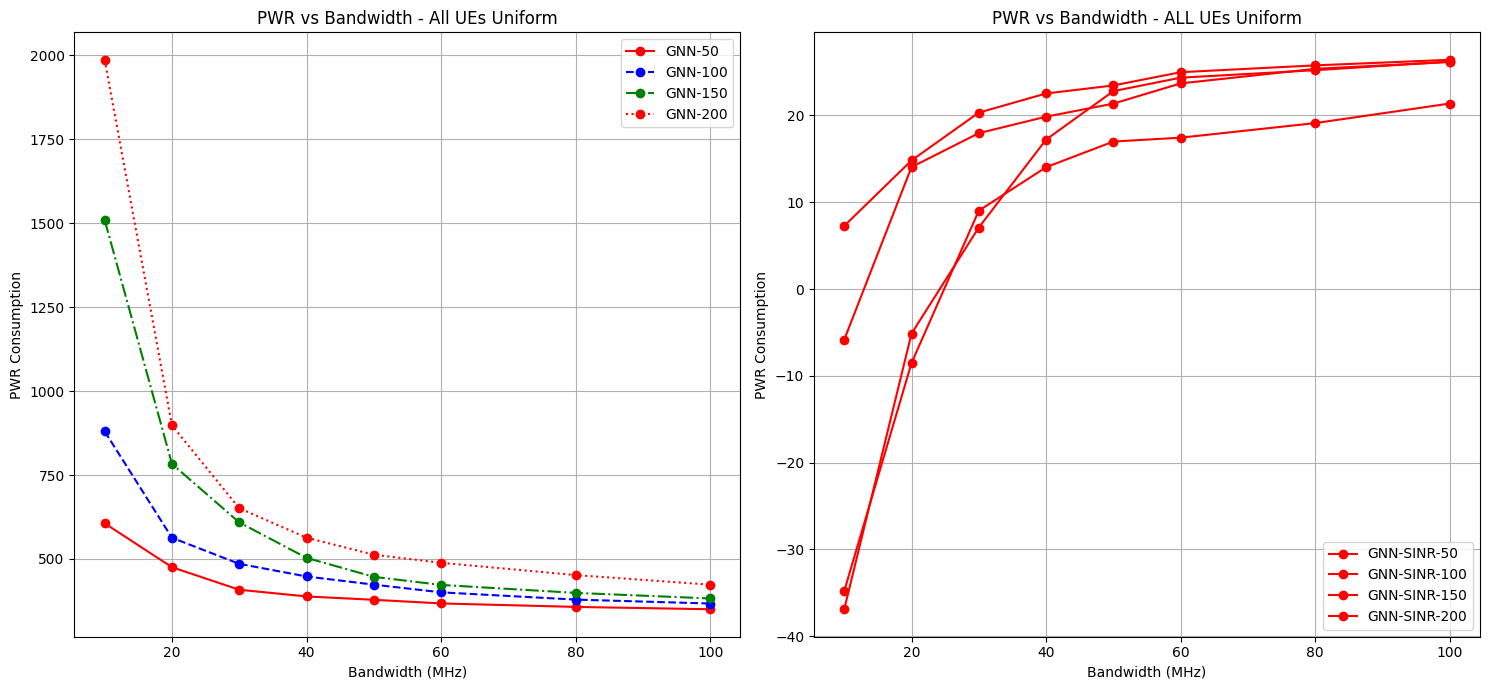

In [215]:
bw=[10, 20, 40]
bw_full=[10, 20, 30, 40, 50, 60, 80, 100]

    
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)



ax1.plot(bw_full, GNN_50, 'r-o', label='GNN-50')
# ax1.plot(bw_full, SINR_50, 'b-s', label='SINR-50')
ax1.plot(bw_full, GNN_100, 'b--o', label='GNN-100')
# ax1.plot(bw_full, SINR_100, 'b--s', label='SINR-100')
ax1.plot(bw_full, GNN_150, 'g-.o', label='GNN-150')
# ax1.plot(bw_full, SINR_150, 'b-.s', label='SINR-150')
ax1.plot(bw_full, GNN_200, 'r:o', label='GNN-200')
# ax1.plot(bw_full, SINR_200, 'b:s', label='SINR-200')
ax1.set_xlabel('Bandwidth (MHz)')
ax1.set_ylabel('PWR Consumption')
ax1.set_title('PWR vs Bandwidth - All UEs Uniform')
ax1.legend()
ax1.grid()


ax2.plot(bw_full, GNN_SINR_50, 'r-o', label='GNN-SINR-50')
ax2.plot(bw_full, GNN_SINR_100, 'r-o', label='GNN-SINR-100')
ax2.plot(bw_full, GNN_SINR_150, 'r-o', label='GNN-SINR-150')
ax2.plot(bw_full, GNN_SINR_200, 'r-o', label='GNN-SINR-200')

ax2.set_xlabel('Bandwidth (MHz)')
ax2.set_ylabel('PWR Consumption')
ax2.set_title('PWR vs Bandwidth - ALL UEs Uniform')
ax2.legend()
ax2.grid()






plt.show()

In [199]:
GNN_50 = [606.233228, 475.511446, 408.407447, 388.463613, 378.463613,  367.632848, 357.271462,  350.290500]
SINR_50 = [653.819602, 558.244501, 512.609581, 501.459045, 494.459045, 490.086426, 481.316849,  476.028453]
RSRP_50 = [5211.42509, 2830.29283, 2034.00970, 1635.35272, 1435.35272, 1236.35216, 1046.25104,  921.460857]
GNN_SINR_50 = [100*(SINR_50[i] - GNN_50[i])/SINR_50[i] for i in range(len(GNN_50))]
GNN_RSRP_50 = [100*(RSRP_50[i] - GNN_50[i])/RSRP_50[i] for i in range(len(GNN_50))]

GNN_100  = [879.96082, 563.17934, 485.56053, 447.90518,  423.63396, 400.67449, 379.02530, 367.32797]
SINR_100 = [831.48633, 655.27073, 591.86930, 558.90465,  538.72764, 525.10324, 507.89197, 497.46654]
RSRP_100 = [9142.0640, 4786.3495, 3343.7126, 2614.6076,  2188.6074, 1883.2025, 1532.0164, 1307.8158]
GNN_SINR_100 = [100*(SINR_100[i] - GNN_100[i])/SINR_100[i] for i in range(len(GNN_100))]
GNN_RSRP_100 = [100*(RSRP_100[i] - GNN_100[i])/RSRP_100[i] for i in range(len(GNN_100))]


GNN_150 = [1509.5008, 783.10451,  608.9727, 503.39162, 446.82404, 422.78721, 399.06423, 382.42976,]
SINR_150 = [1102.6869, 744.91110,  655.4462, 608.09573, 578.80187, 558.90450, 533.61863, 518.22622,]
RSRP_150 = [13471.094, 7164.2254,  4737.845, 3665.8592, 3016.8080, 2591.5162, 2051.3607, 1715.9639,]
GNN_SINR_150 = [100*(SINR_150[i] - GNN_150[i])/SINR_150[i] for i in range(len(GNN_150))]
GNN_RSRP_150 = [100*(RSRP_150[i] - GNN_150[i])/RSRP_150[i] for i in range(len(GNN_150))]


GNN_200  = [1986.70974, 897.93282, 651.2098, 563.46293,  512.73159, 488.66217, 452.02234,423.55314]
SINR_200 = [1473.92356, 827.44330, 715.8387, 655.48583,  617.70678, 591.89410, 558.88482,538.68976]
RSRP_200 =[19237.0219, 9666.5038, 6615.842, 5078.5597,  4129.7561, 3537.8324, 2744.8381,2266.8261]
GNN_SINR_200 = [100*(SINR_200[i] - GNN_200[i])/SINR_200[i] for i in range(len(GNN_200))]
GNN_RSRP_200 = [100*(RSRP_200[i] - GNN_200[i])/RSRP_200[i] for i in range(len(GNN_200))]

In [106]:
GNN_SINR_50

[2.423465, 9.44, 23.44]

## CDF plot

In [198]:
len(train_ls+test_ls)

1000

In [202]:
## UE=100, BW=100 MHz
import torch_geometric
# import networkx as nx
from torch_geometric.data import Data
import seaborn as sns
BS_nom = 7
UE_nom=100
device= 'cpu'

# sample_nom =np.random.randint(200)
# print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)
# data_test_ls = [i for j, i in enumerate(test_loader)]

test_ls = [i for j, i in enumerate(test_loader)]
train_ls = []#[i for j, i in enumerate(train_loader)]
data_test_ls= train_ls+test_ls


BW = 100## MHz
PRB_bw=180# Khz
Max_PRB=1000*BW/PRB_bw

GNN_PWR_sample_ls=[]
RSRP_PWR_sample_ls=[]
SINR_PWR_sample_ls=[]
for data in data_test_ls:
    data_test= data.to('cpu')
    out_test = GNN_homo_model(data_test)  # Perform a single forward pass.

    T_GNN= torch.zeros((UE_nom,BS_nom))
    L_GNN= torch.argmax(out_test, dim=1)
    for l in range(len(L_GNN)):
        T_GNN[l,L_GNN[l].item()] = 1
    T_RSRP = data_test['UE_Ass_rsrp_mtx']
    T_SINR = data_test['UE_Ass_sinr_mtx']

    ## RRBs
    BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
    BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
    BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)



    Power_Cons_GNN =  PWR_consmption(BS_PRB_GNN, Max_PRB, coefs, intercepts)
    Power_Cons_RSRP = PWR_consmption(BS_PRB_RSRP,Max_PRB, coefs, intercepts)
    Power_Cons_SINR = PWR_consmption(BS_PRB_SINR,Max_PRB, coefs, intercepts)
    GNN_PWR_sample_ls.append(Power_Cons_GNN.sum())
    RSRP_PWR_sample_ls.append(Power_Cons_RSRP.sum())
    SINR_PWR_sample_ls.append(Power_Cons_SINR.sum())



In [203]:
GNN_PWR_sample_ls

[tensor(350.5106),
 tensor(349.4283),
 tensor(354.6109),
 tensor(349.2508),
 tensor(348.7368),
 tensor(354.0362),
 tensor(353.1481),
 tensor(351.3041),
 tensor(349.2384),
 tensor(352.0466),
 tensor(352.7551),
 tensor(351.8938),
 tensor(351.3233),
 tensor(351.5180),
 tensor(351.4747),
 tensor(351.3331),
 tensor(350.3570),
 tensor(348.5221),
 tensor(351.2650),
 tensor(353.0032),
 tensor(352.8415),
 tensor(351.2775),
 tensor(355.9670),
 tensor(353.3515),
 tensor(352.3839),
 tensor(348.3239),
 tensor(352.8080),
 tensor(350.7779),
 tensor(351.8580),
 tensor(351.2474),
 tensor(348.9052),
 tensor(349.7628),
 tensor(352.6005),
 tensor(351.6768),
 tensor(351.9977),
 tensor(351.4440),
 tensor(353.1893),
 tensor(351.4835),
 tensor(350.4090),
 tensor(350.7732),
 tensor(349.9814),
 tensor(352.0212),
 tensor(350.5172),
 tensor(350.1534),
 tensor(352.0704),
 tensor(351.0912),
 tensor(353.9378),
 tensor(352.1679),
 tensor(350.1253),
 tensor(348.9065),
 tensor(349.4216),
 tensor(351.7867),
 tensor(349.

Text(0.5, 0, 'Bins')

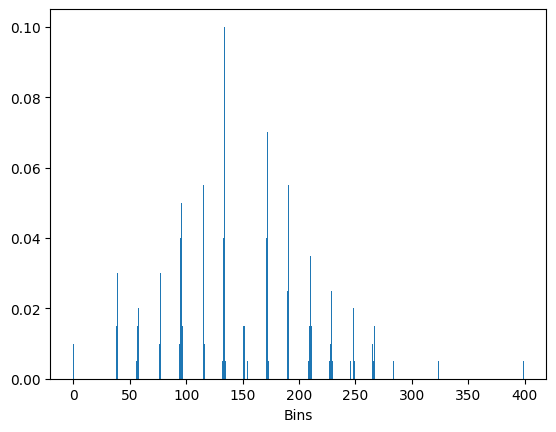

In [204]:
import torch
import matplotlib.pyplot as plt

t = torch.tensor(SINR_PWR_sample_ls)
hist = torch.histc(t, bins = 400)

bins = 400
x = range(bins)
plt.bar(x, hist/200, align='center')
plt.xlabel('Bins')

In [275]:
data_a = torch.histc(torch.tensor(SINR_PWR_sample_ls), bins = 100)
cdf=np.zeros(len(data_a))
for i in list(range(len(data_a))):
    cdf[i]=data_a[0:i+1].sum()


In [283]:
a= torch.nn.functional.normalize(torch.tensor(data_ls), p=2.0, dim = 0)
hist_a = torch.histc(a, bins = b)

# Create some test data
data_a = hist_a.detach().cpu().numpy()
data_a.sort()

# Compute the CDF
cdf=np.zeros(len(data_a))
for i in list(range(len(data_a))):
    cdf[i]=data_a[0:i+1].sum()

NameError: name 'data_ls' is not defined

ValueError: x and y must have same first dimension, but have shapes torch.Size([200]) and (50,)

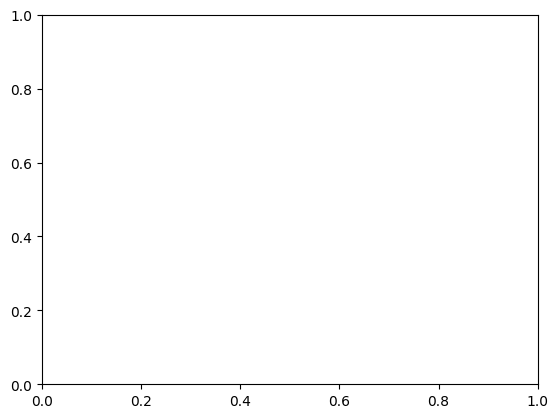

In [284]:
def cdf_data(data_ls, b):
    a= torch.nn.functional.normalize(torch.tensor(data_ls), p=2.0, dim = 0)
    hist_a = torch.histc(a, bins = b)

    # Create some test data
    data_a = hist_a.detach().cpu().numpy()
    data_a.sort()

    # Compute the CDF
    cdf=np.zeros(len(data_a))
    for i in list(range(len(data_a))):
        cdf[i]=data_a[0:i+1].sum()
        
    return a.sort(), cdf
bins=50
a, CY_a = cdf_data(GNN_PWR_sample_ls, bins)
b, CY_b = cdf_data(SINR_PWR_sample_ls, bins)
c, CY_c= cdf_data(RSRP_PWR_sample_ls, bins)
# Plot 
plt.plot(a[0], CY_a/bins, 'r')
plt.plot(b[0], CY_b/bins, 'b')
plt.plot(c[0], CY_c/bins, 'g')

plt.show()




In [263]:
b.sort()

torch.return_types.sort(
values=tensor([0.0705, 0.0705, 0.0705, 0.0705, 0.0705, 0.0705, 0.0705, 0.0705, 0.0705,
        0.0705, 0.0705, 0.0705, 0.0705, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706,
        0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706,
        0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706,
        0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706,
        0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706,
        0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
        0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
        0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
        0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
        0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
        0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
        

In [227]:
100*CY/200

array([ 61. ,  97. ,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,

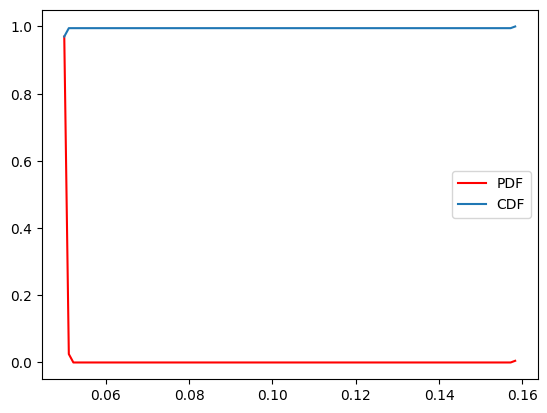

In [179]:
torch.histogram(torch.tensor([1., 2, 1]), bins=4, range=(0., 3.), weight=torch.tensor([1., 2., 4.]))

In [180]:
bins_count

array([0.04897135, 0.05006408, 0.0511568 , 0.05224952, 0.05334225,
       0.05443498, 0.0555277 , 0.05662043, 0.05771315, 0.05880588,
       0.0598986 , 0.06099132, 0.06208405, 0.06317677, 0.0642695 ,
       0.06536222, 0.06645495, 0.06754768, 0.0686404 , 0.06973313,
       0.07082585, 0.07191858, 0.0730113 , 0.07410403, 0.07519675,
       0.07628947, 0.0773822 , 0.07847492, 0.07956765, 0.08066037,
       0.0817531 , 0.08284583, 0.08393855, 0.08503128, 0.086124  ,
       0.08721673, 0.08830945, 0.08940218, 0.0904949 , 0.09158763,
       0.09268035, 0.09377307, 0.0948658 , 0.09595852, 0.09705125,
       0.09814397, 0.0992367 , 0.10032943, 0.10142215, 0.10251488,
       0.1036076 , 0.10470033, 0.10579305, 0.10688578, 0.1079785 ,
       0.10907122, 0.11016395, 0.11125667, 0.1123494 , 0.11344212,
       0.11453485, 0.11562757, 0.1167203 , 0.11781303, 0.11890575,
       0.11999848, 0.1210912 , 0.12218393, 0.12327665, 0.12436938,
       0.1254621 , 0.12655483, 0.12764755, 0.12874028, 0.12983

ValueError: x and y must have same first dimension, but have shapes (201,) and (200,)

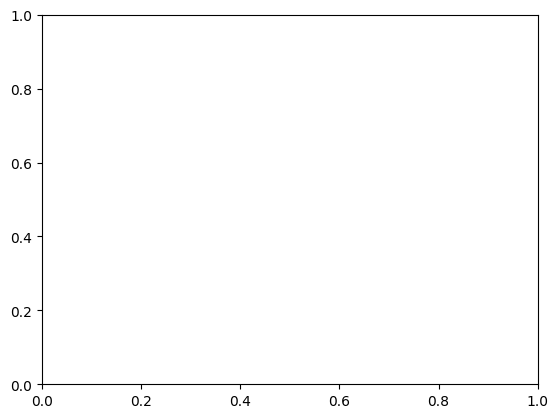

In [175]:
# Create some test data
data = t.detach().cpu().numpy()

# Compute the CDF
CY = np.cumsum(Y * dx)

# Plot both
plt.plot(X, CY, 'r--')

plt.show()


In [171]:
Y.shape

(200,)

AttributeError: Polygon.set() got an unexpected keyword argument 'normed'

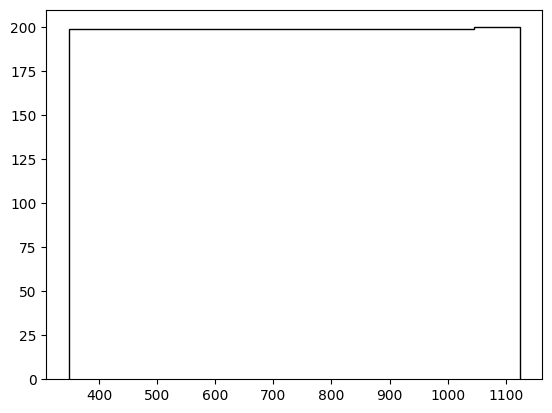

In [162]:
plt.hist(t.detach().cpu().numpy() , normed=True, cumulative=True, label='CDF',
         histtype='step', alpha=0.8, color='k')

In [ ]:
## lets see the histograam of SINR in each cell
## Plot histogram:
bins = np.linspace(math.ceil(np.min(l)), 
                   math.floor(np.max(l)),
                   100) # fixed number of bins
# bins = np.array([-6,-3, 6, 27])
plt.hist(l, bins=bins, alpha=0.5)


plt.show()

In [139]:
BW_ls[5:12]

[100, 125, 150, 175, 200, 300, 400]

In [673]:
data_test['SINR_mtx'][:,18]

tensor([ -0.1488, -29.4961, -37.8402, -18.3057,  -5.8017, -21.8119,  -4.1502])

In [672]:
data_test['UE_PRB_All_cells'][18,:]

tensor([   5., 2977., 2977., 2977., 2977., 2977.,   13.])

In [687]:
data_test['UE_Ass_rsrp_mtx'][18,:]
data_test

DataBatch(x=[50, 21], edge_index=[2, 994], SINR_mtx=[7, 50], UE_PRB_All_cells=[50, 7], UE_Ass_rsrp_mtx=[50, 7], UE_Ass_sinr_mtx=[50, 7], Conn_mtx=[50, 7], Cell_Edge_id=[12], batch=[50], ptr=[2])

In [695]:
ue_nom=33
print(f'SINR Values:       {data_test.SINR_mtx[:,ue_nom]}')
print(f'PRB Allocation:    {data_test.UE_PRB_All_cells[ue_nom,:]}')
print(f'RSRP Associationn: {data_test.UE_Ass_rsrp_mtx[ue_nom,:]}')

SINR Values:       tensor([ -1.8491, -12.4875, -10.0514, -20.1251,  -7.3989, -10.3302,  -5.6758])
PRB Allocation:    tensor([   8., 2977., 2977., 2977., 2977., 2977., 2977.])
RSRP Associationn: tensor([0., 0., 0., 0., 0., 0., 1.])


51


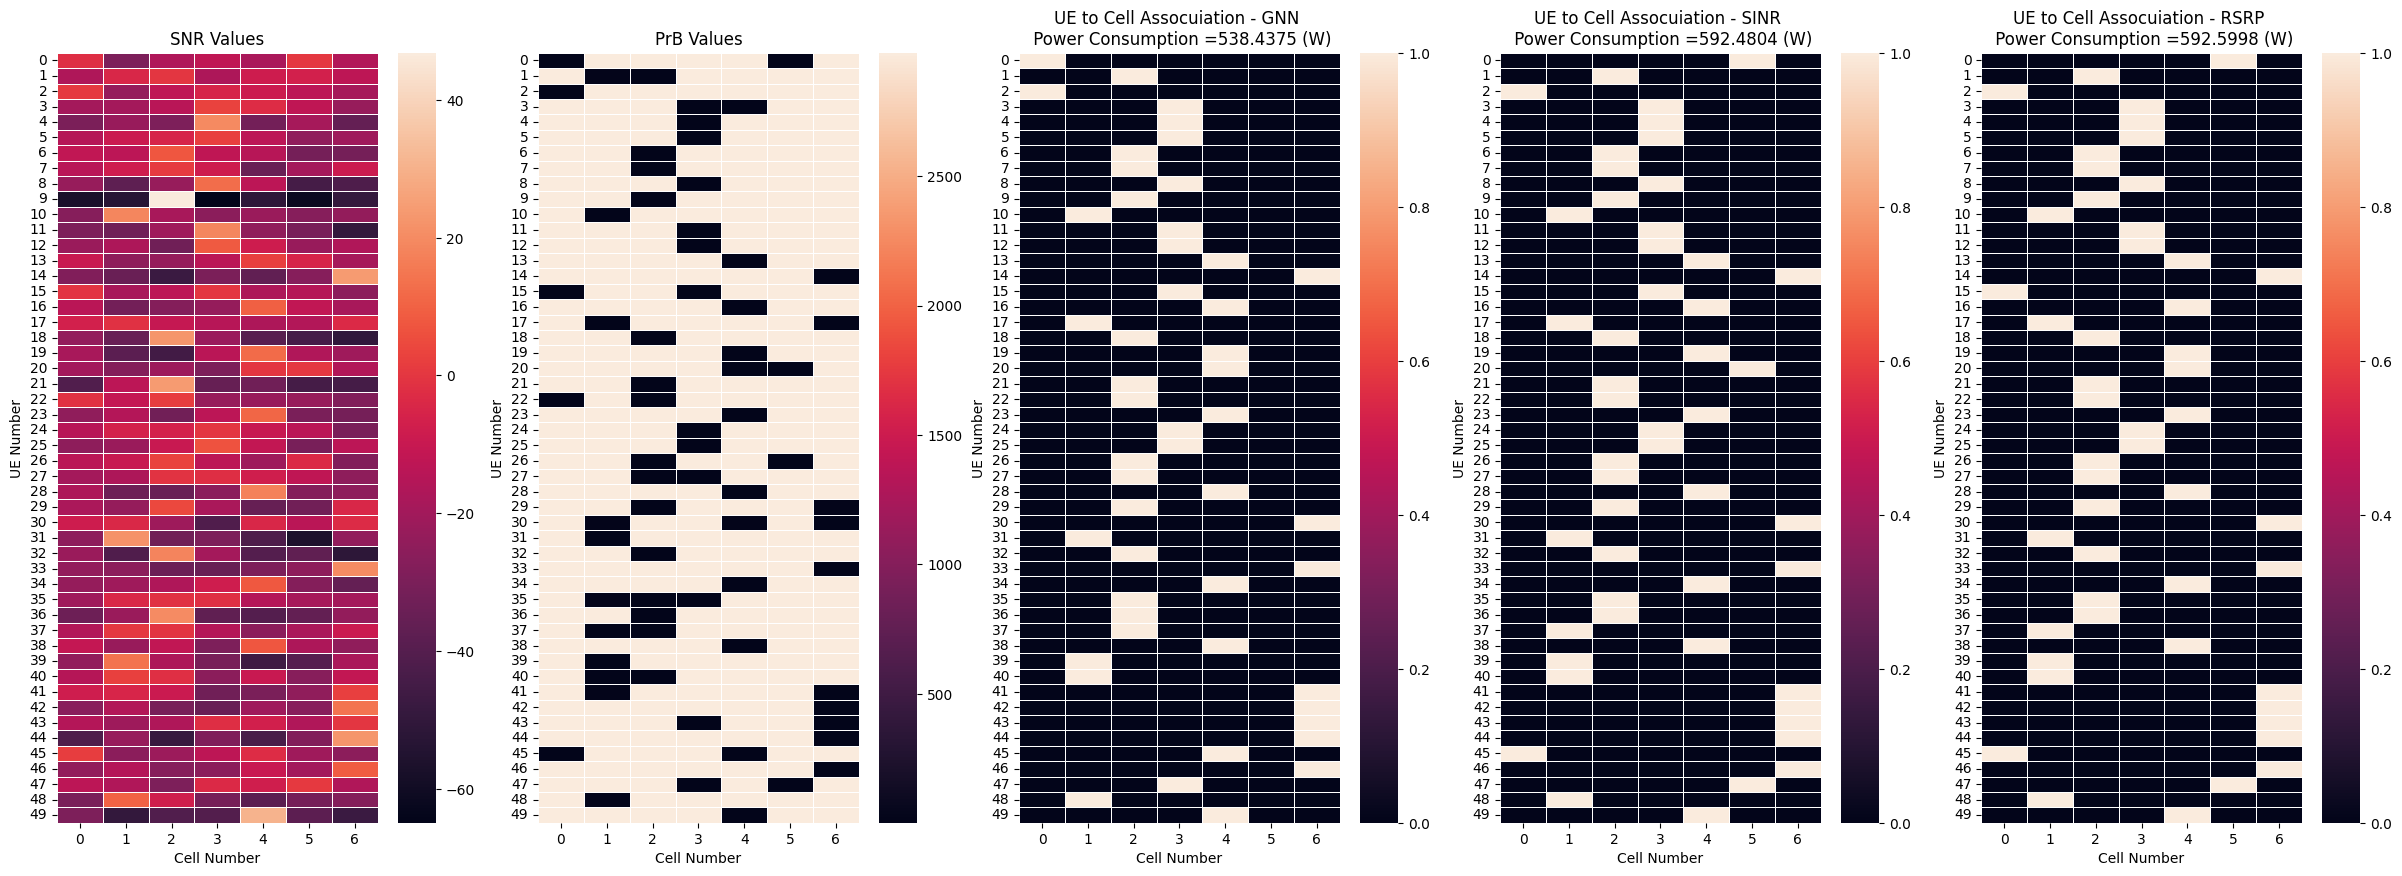

GNN:  PrB Distribution: tensor([12., 13., 42., 33., 27.,  0., 22.]), ====>> Total PrB: 149.0, ====>> Total PWR: 538.4375
RSRP: PrB Distribution: tensor([13., 18., 37., 18., 19.,  9., 22.]), ====>> Total PrB: 136.0, ====>> Total PWR: 592.5998
SINR: PrB Distribution: tensor([ 8., 18., 37., 23., 14., 14., 22.]), ====>> Total PrB: 136.0, ====>> Total PWR: 592.4804


In [72]:

import seaborn as sns
BS_nom = 7
UE_nom=50
device= 'cpu'

sample_nom = np.random.randint(200)
print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()
data_test=list(enumerate(test_loader))[sample_nom][1]
out_test = GNN_homo_model(data_test)  # Perform a single forward pass.


out_test= out_test.to('cpu')

T_GNN= torch.zeros((UE_nom,BS_nom))
L_GNN= torch.argmax(out_test, dim=1)
for l in range(len(L_GNN)):
    T_GNN[l,L_GNN[l].item()] = 1
T_RSRP = data_test['UE_Ass_rsrp_mtx']
T_SINR = data_test['UE_Ass_sinr_mtx']

## Power Consumption
BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
# Power_Cons_GNN = torch.tensor( regr.predict(BS_PRB_GNN.reshape(-1, 1))).sum()
# Power_Cons_RSRP = torch.tensor( regr.predict(BS_PRB_RSRP.reshape(-1, 1))).sum()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)

poly_features_GNN = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_GNN], dtype= torch.float32, device= device)
Power_Cons_GNN= torch.matmul(coefs[0],torch.t(poly_features_GNN))+intercepts*torch.where(BS_PRB_GNN > 0, 1, 0)

poly_features_RSRP = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_RSRP], dtype= torch.float32, device= device)
Power_Cons_RSRP= torch.matmul(coefs[0],torch.t(poly_features_RSRP))+intercepts*torch.where(BS_PRB_RSRP > 0, 1, 0)

poly_features_SINR = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_SINR], dtype= torch.float32, device= device)
Power_Cons_SINR= torch.matmul(coefs[0],torch.t(poly_features_SINR))+intercepts*torch.where(BS_PRB_SINR > 0, 1, 0)




fig = plt.figure(figsize=(30, 10))

ax2 = fig.add_subplot(1, 5, 1)
sns.heatmap(data_test['SINR_mtx'].detach().numpy().transpose() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('SNR Values')


ax1 = fig.add_subplot(1, 5, 2)
sns.heatmap(data_test['UE_PRB_All_cells'].detach().numpy() , linewidth=0.5)
ax1.set_xlabel('Cell Number')
ax1.set_ylabel('UE Number')
ax1.set_title('PrB Values')

ax2 = fig.add_subplot(1, 5, 3)
sns.heatmap(out_test.detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - GNN \n Power Consumption ={:.4f} (W)'.format(Power_Cons_GNN.sum()))

ax2 = fig.add_subplot(1, 5, 4)
sns.heatmap(data_test['UE_Ass_sinr_mtx'].detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - SINR \n Power Consumption ={:.4f} (W)'.format(Power_Cons_SINR.sum()))


ax2 = fig.add_subplot(1, 5, 5)
sns.heatmap(data_test['UE_Ass_rsrp_mtx'].detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - RSRP \n Power Consumption ={:.4f} (W)'.format(Power_Cons_RSRP.sum()))


plt.show()


print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')

In [71]:
print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')

GNN:  PrB Distribution: tensor([12., 13., 42., 33., 27.,  0., 22.]), ====>> Total PrB: 149.0, ====>> Total PWR: 538.4375
RSRP: PrB Distribution: tensor([13., 18., 37., 18., 19.,  9., 22.]), ====>> Total PrB: 136.0, ====>> Total PWR: 592.5998
SINR: PrB Distribution: tensor([ 8., 18., 37., 23., 14., 14., 22.]), ====>> Total PrB: 136.0, ====>> Total PWR: 592.4804


In [140]:
print(BS_PRB_GNN.sum())
print(BS_PRB_RSRP.sum())
print(BS_PRB_SINR.sum())

tensor(129.)
tensor(129.)
tensor(129.)


## Extereme test

6


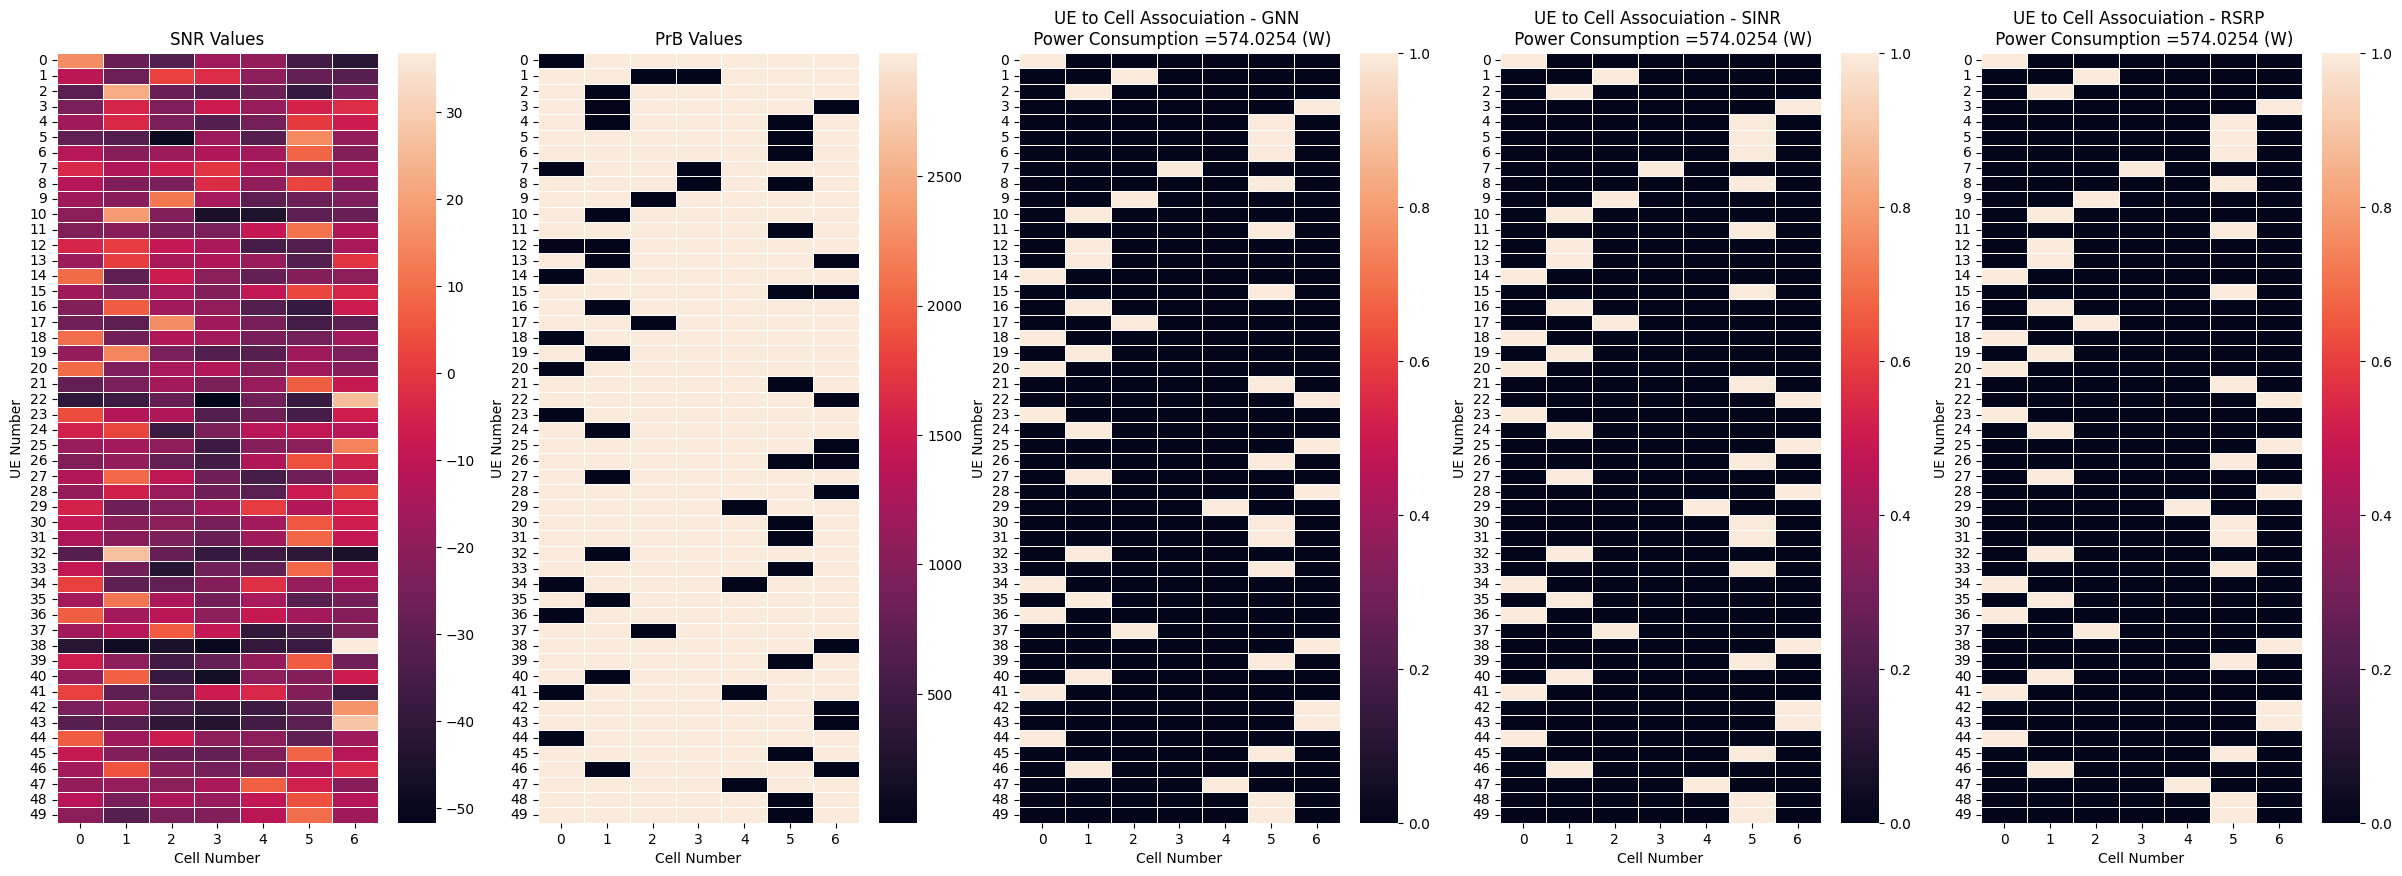

GNN:  PrB Distribution: tensor([21., 26.,  7.,  5.,  6., 37., 16.]), ====>> Total PrB: 118.0, ====>> Total PWR: 574.0254
RSRP: PrB Distribution: tensor([21., 26.,  7.,  5.,  6., 37., 16.]), ====>> Total PrB: 118.0, ====>> Total PWR: 574.0254
SINR: PrB Distribution: tensor([21., 26.,  7.,  5.,  6., 37., 16.]), ====>> Total PrB: 118.0, ====>> Total PWR: 574.0254


In [109]:

import seaborn as sns
BS_nom = 7
UE_nom=50
device= 'cpu'

sample_nom = np.random.randint(50)
print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()
data_test=list(enumerate(Extereme_test_loader))[sample_nom][1]
out_test = GNN_homo_model(data_test)  # Perform a single forward pass.


out_test= out_test.to('cpu')

T_GNN= torch.zeros((UE_nom,BS_nom))
L_GNN= torch.argmax(out_test, dim=1)
for l in range(len(L_GNN)):
    T_GNN[l,L_GNN[l].item()] = 1
T_RSRP = data_test['UE_Ass_rsrp_mtx']
T_SINR = data_test['UE_Ass_sinr_mtx']

## Power Consumption
BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
# Power_Cons_GNN = torch.tensor( regr.predict(BS_PRB_GNN.reshape(-1, 1))).sum()
# Power_Cons_RSRP = torch.tensor( regr.predict(BS_PRB_RSRP.reshape(-1, 1))).sum()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)

poly_features_GNN = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_GNN], dtype= torch.float32, device= device)
Power_Cons_GNN= torch.matmul(coefs[0],torch.t(poly_features_GNN))+intercepts*torch.where(BS_PRB_GNN > 0, 1, 0)

poly_features_RSRP = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_RSRP], dtype= torch.float32, device= device)
Power_Cons_RSRP= torch.matmul(coefs[0],torch.t(poly_features_RSRP))+intercepts*torch.where(BS_PRB_RSRP > 0, 1, 0)

poly_features_SINR = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_SINR], dtype= torch.float32, device= device)
Power_Cons_SINR= torch.matmul(coefs[0],torch.t(poly_features_SINR))+intercepts*torch.where(BS_PRB_SINR > 0, 1, 0)




fig = plt.figure(figsize=(30, 10))

ax2 = fig.add_subplot(1, 5, 1)
sns.heatmap(data_test['SINR_mtx'].detach().numpy().transpose() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('SNR Values')


ax1 = fig.add_subplot(1, 5, 2)
sns.heatmap(data_test['UE_PRB_All_cells'].detach().numpy() , linewidth=0.5)
ax1.set_xlabel('Cell Number')
ax1.set_ylabel('UE Number')
ax1.set_title('PrB Values')

ax2 = fig.add_subplot(1, 5, 3)
sns.heatmap(out_test.detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - GNN \n Power Consumption ={:.4f} (W)'.format(Power_Cons_GNN.sum()))

ax2 = fig.add_subplot(1, 5, 4)
sns.heatmap(data_test['UE_Ass_sinr_mtx'].detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - SINR \n Power Consumption ={:.4f} (W)'.format(Power_Cons_SINR.sum()))


ax2 = fig.add_subplot(1, 5, 5)
sns.heatmap(data_test['UE_Ass_rsrp_mtx'].detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - RSRP \n Power Consumption ={:.4f} (W)'.format(Power_Cons_RSRP.sum()))


plt.show()


print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')

In [292]:
torch.nonzero(BS_PRB_GNN, as_tuple=True)

(tensor([0, 1, 2, 4, 5, 6]),)

In [294]:
intercepts*torch.where(BS_PRB_GNN > 0, 1, 0)

tensor([65., 65., 65.,  0., 65., 65., 65.], dtype=torch.float16)

## Check the difference



In [128]:
sns.heatmap(out_test.detach().numpy()- data_test['UE_Ass_sinr_mtx'].detach().numpy().transpose())

ValueError: operands could not be broadcast together with shapes (50,7) (7,50) 

In [513]:
data_test

DataBatch(x=[50, 21], edge_index=[2, 652], SINR_mtx=[7, 50], UE_PRB_All_cells=[50, 7], UE_Ass_rsrp_mtx=[7, 50], batch=[50], ptr=[2])

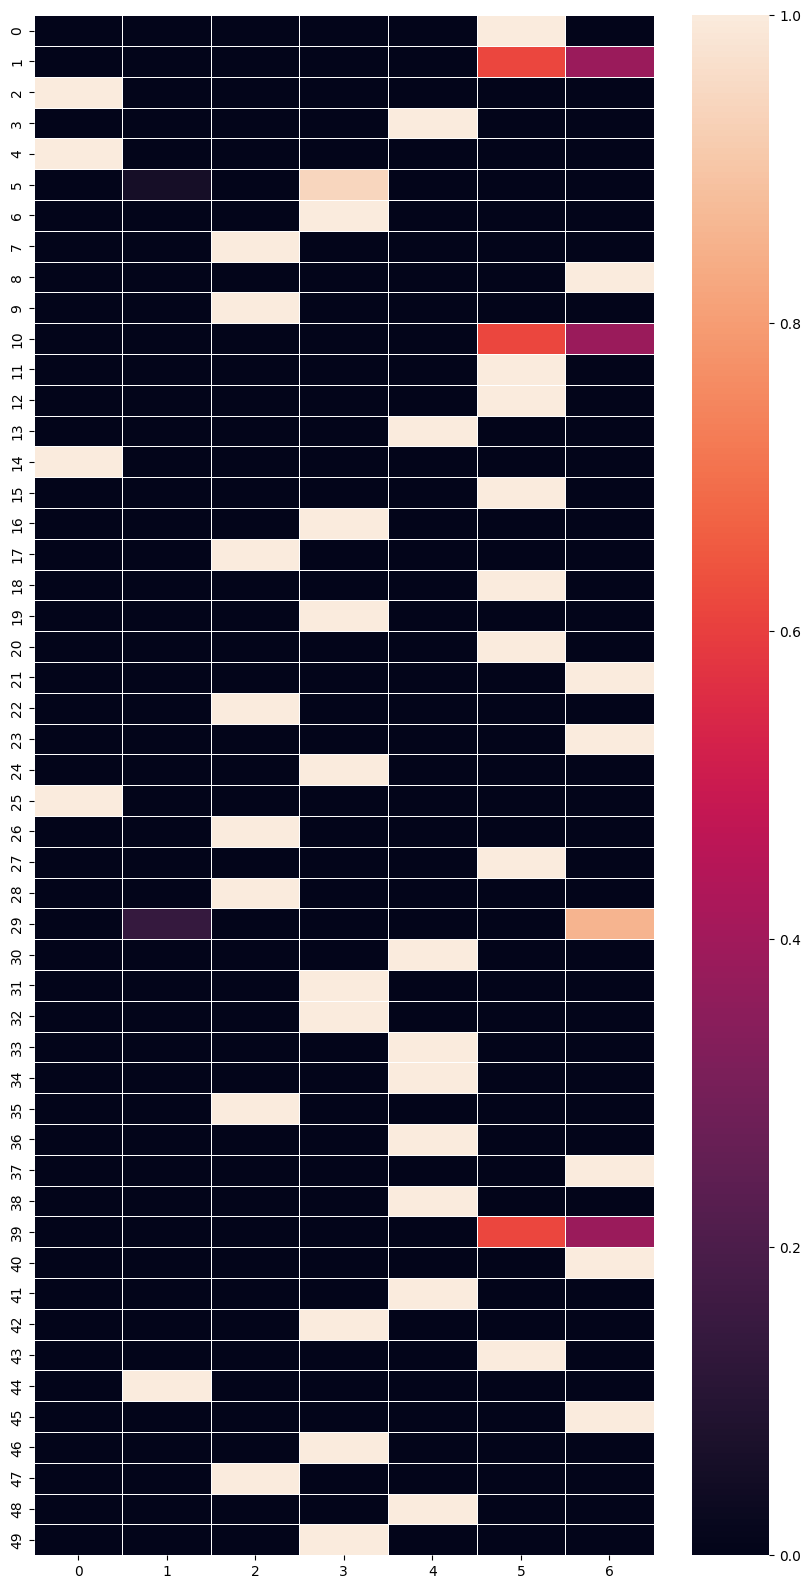

In [66]:
import seaborn as sns
fig = plt.figure(figsize=(10, 20))
Tensor_a= sns.heatmap(out_test.detach().numpy() , linewidth=0.5)
plt.show()

In [145]:
torch.stack(loss_ls).mean().item()

87.77828216552734

In [270]:
out_test

tensor([[2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.91

In [74]:
data_test['UE_PRB_All_cells']

tensor([[ 4., 13., 13., 13., 13., 13., 13.],
        [13.,  8., 10., 13., 13., 13., 13.],
        [ 7., 13., 13., 13., 13., 13., 13.],
        [13., 13., 13., 13., 13., 13.,  3.],
        [13., 13.,  5.,  8., 13., 13., 13.],
        [13.,  8., 13., 13., 13., 13., 13.],
        [ 7., 13., 13., 13.,  8., 13., 13.],
        [13., 13., 13., 13.,  7., 13., 13.],
        [13., 13., 13., 13.,  4., 10., 13.],
        [13., 13., 13., 13.,  3., 13., 13.],
        [13., 13., 13., 13., 13., 13.,  3.],
        [13., 13., 13.,  8., 13., 13., 13.],
        [13., 13., 13.,  3., 13., 13., 13.],
        [13., 13., 13., 13., 13., 13.,  2.],
        [13., 13.,  2., 13., 13., 13., 13.],
        [13., 13., 13., 13.,  1., 13., 13.],
        [13., 13., 13., 13.,  4., 13., 13.],
        [13.,  3., 13., 13., 13., 13., 13.],
        [13., 13.,  4., 13., 13., 13., 13.],
        [13., 13., 13.,  3., 13., 13., 13.],
        [13., 13., 13.,  5., 13., 13., 13.],
        [13., 13., 13.,  3., 13., 13., 13.],
        [ 

In [206]:
torch.norm(F.relu((out_test*data_test['UE_PRB_All_cells']).sum(dim=0)-100*torch.ones(7)),2)

tensor(461.9993, grad_fn=<NormBackward1>)

In [84]:
torch.matmul(out_test['UE'][11],data['UE_PRB_All_cells'][11])

TypeError: new(): invalid data type 'str'

In [359]:
data['UE_PRB_All_cells']

tensor([[13., 13., 13., 13., 13.,  3., 13.],
        [13.,  2., 13., 13., 13., 13., 13.],
        [ 8.,  8., 13., 13., 13., 13., 13.],
        [10., 13., 13.,  7., 13., 13., 13.],
        [13., 13., 13., 13.,  3., 13., 13.],
        [13., 13., 13., 13.,  3., 13., 13.],
        [ 4., 13., 13., 13., 13., 13., 13.],
        [13.,  7.,  8., 13., 13., 13., 13.],
        [ 2., 13., 13., 13., 13., 13., 13.],
        [13., 13., 13., 13., 13., 13.,  5.],
        [13., 13., 13., 13., 13., 13.,  2.],
        [13., 13., 13.,  1., 13., 13., 13.],
        [13., 13., 13., 13., 13., 13.,  3.],
        [13., 13., 13., 13., 13.,  1., 13.],
        [ 3., 13., 13., 13., 13., 13., 13.],
        [ 5., 13., 13., 13., 13., 13., 13.],
        [13., 13., 13., 13., 13., 13., 13.],
        [13.,  1., 13., 13., 13., 13., 13.],
        [13., 13., 13., 13.,  2., 13., 13.],
        [13., 13., 13., 13.,  5., 13., 13.],
        [ 5., 13., 13., 13., 13., 13., 13.],
        [13., 13.,  3., 13., 13., 13., 13.],
        [1

In [125]:
torch.diag(torch.matmul(out_test,torch.t(data['UE_PRB_All_cells'])))

tensor([ 2., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13.,  4., 13.,  3.,
         3., 13., 13.,  7., 13., 13.,  7.,  8., 13., 13., 13., 10., 13., 13.,
        13., 13., 13., 13., 13., 13., 13., 13., 13., 13.,  3., 13., 13., 13.,
        13., 13., 13.,  3., 13., 13.,  2., 13.], grad_fn=<DiagBackward0>)

## Color network X graph

tensor([50., 63., 76., 18., 19., 11., 31.])

tensor(705.4165)

In [114]:
poly_features_test = poly.fit_transform(BS_PRB_GNN.numpy().reshape(1, -1))
y_predicted_test = poly_reg_model.predict(poly_features_test)
y_predicted_test

ValueError: X has 36 features, but LinearRegression is expecting 3 features as input.

51


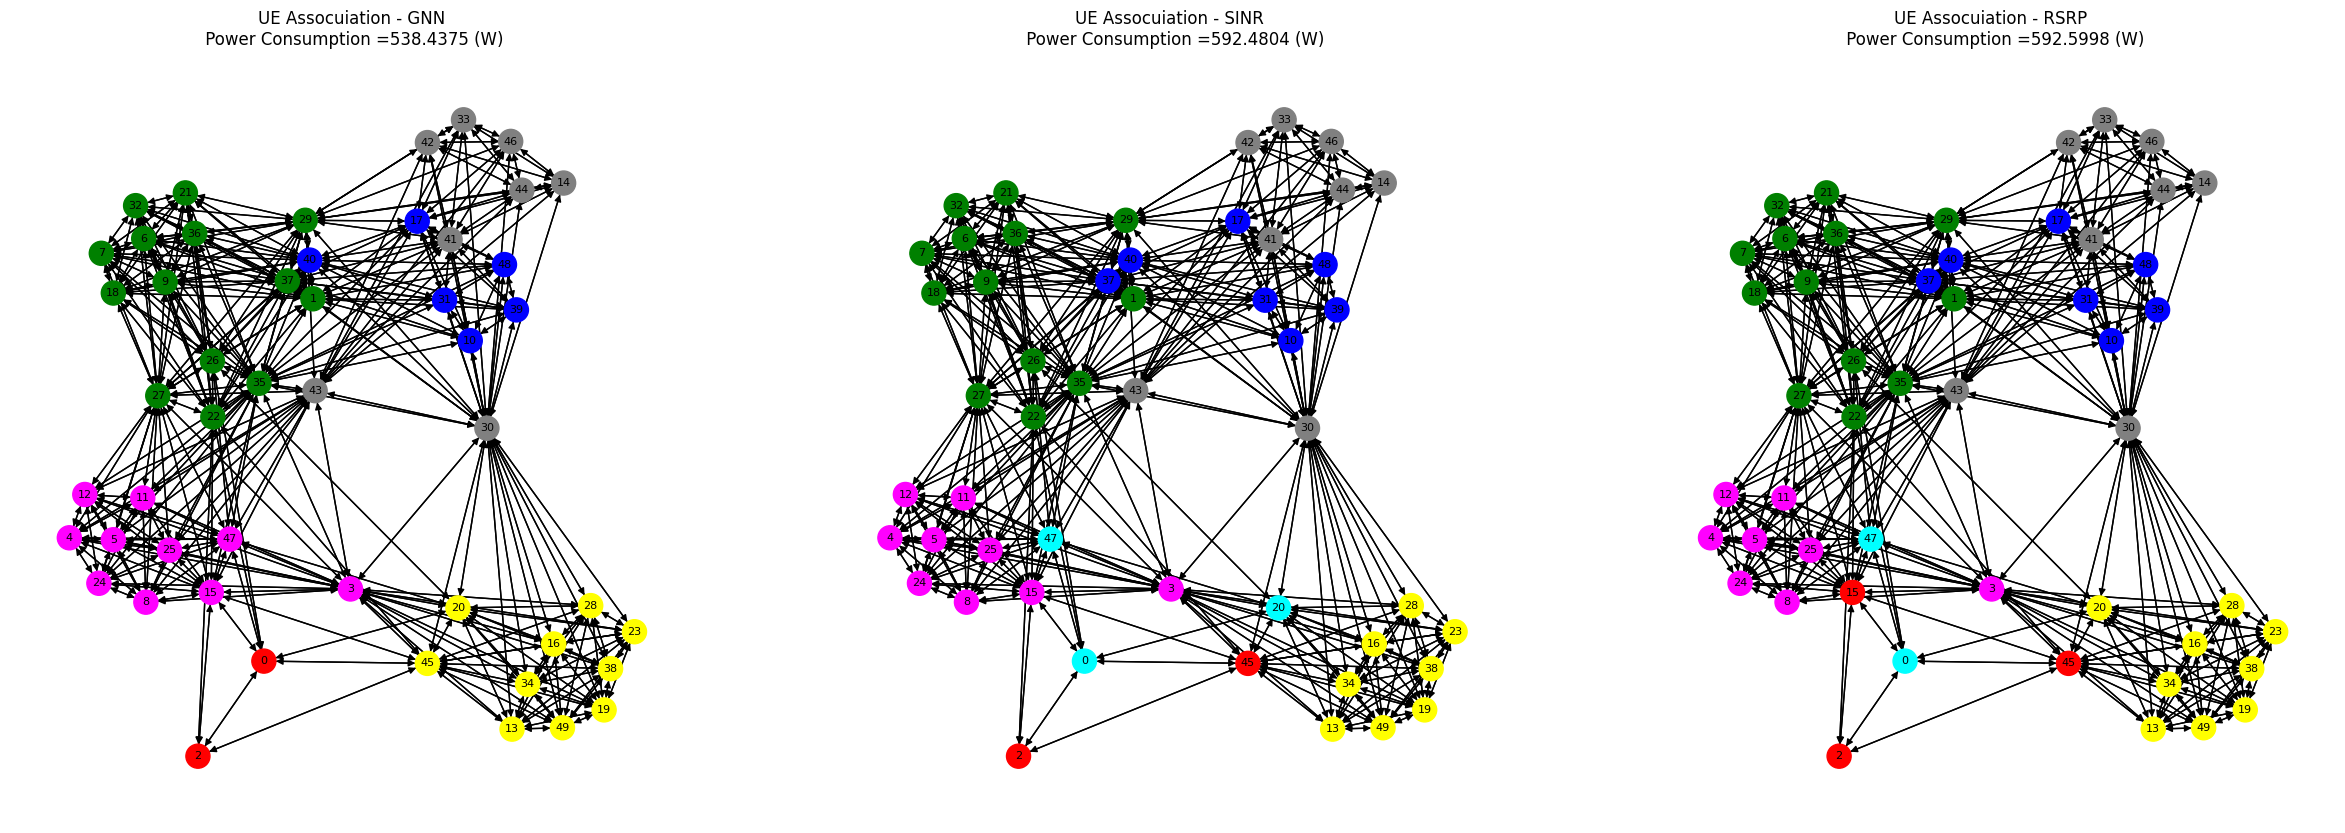

GNN:  PrB Distribution: tensor([12., 13., 42., 33., 27.,  0., 22.]), ====>> Total PrB: 149.0, ====>> Total PWR: 538.4375
RSRP: PrB Distribution: tensor([13., 18., 37., 18., 19.,  9., 22.]), ====>> Total PrB: 136.0, ====>> Total PWR: 592.5998
SINR: PrB Distribution: tensor([ 8., 18., 37., 23., 14., 14., 22.]), ====>> Total PrB: 136.0, ====>> Total PWR: 592.4804


In [73]:
import torch_geometric
import networkx as nx
from torch_geometric.data import Data


import seaborn as sns
BS_nom = 7
UE_nom=50
device= 'cpu'

sample_nom =51# np.random.randint(135)
print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()
data_test=list(enumerate(test_loader))[sample_nom][1]
out_test = GNN_homo_model(data_test)  # Perform a single forward pass.


out_test= out_test.to('cpu')

T_GNN= torch.zeros((UE_nom,BS_nom))
L_GNN= torch.argmax(out_test, dim=1)
for l in range(len(L_GNN)):
    T_GNN[l,L_GNN[l].item()] = 1
T_RSRP = data_test['UE_Ass_rsrp_mtx']
T_SINR = data_test['UE_Ass_sinr_mtx']

## Power Consumption
BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
# Power_Cons_GNN = torch.tensor( regr.predict(BS_PRB_GNN.reshape(-1, 1))).sum()
# Power_Cons_RSRP = torch.tensor( regr.predict(BS_PRB_RSRP.reshape(-1, 1))).sum()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)

poly_features_GNN = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_GNN], dtype= torch.float32, device= device)
Power_Cons_GNN= torch.matmul(coefs[0],torch.t(poly_features_GNN))+intercepts*torch.where(BS_PRB_GNN > 0, 1, 0)

poly_features_RSRP = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_RSRP], dtype= torch.float32, device= device)
Power_Cons_RSRP= torch.matmul(coefs[0],torch.t(poly_features_RSRP))+intercepts*torch.where(BS_PRB_RSRP > 0, 1, 0)

poly_features_SINR = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_SINR], dtype= torch.float32, device= device)
Power_Cons_SINR= torch.matmul(coefs[0],torch.t(poly_features_SINR))+intercepts*torch.where(BS_PRB_SINR > 0, 1, 0)


# sample=130
# adj_t= data_set_processed['Adj_mtx'][sample]
# edge_index = torch.tensor(adj_t.nonzero())
# UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample],  data_set_processed['UE_aggPRB_norm'][sample]), axis=1)

# x = torch.tensor(UE_feature_mtx, dtype=torch.float32) 
Homodata = Data(x=data_test.x, edge_index=data_test.edge_index)
    
## find color map
edge_index = (T_GNN > 0).nonzero().t()
row, col = edge_index
# edge_index
colors=['red', 'blue', 'green', 'magenta', 'yellow', 'cyan', 'gray']
color_map_GNN=[]
color_map_RSRP=[]
color_map_SINR=[]
for t in range(50):
    color_map_GNN.append(colors[[idx for idx in range(BS_nom) if T_GNN[t,idx]==1][0]])
    color_map_RSRP.append(colors[[idx for idx in range(BS_nom) if T_RSRP[t,idx]==1][0]])
    color_map_SINR.append(colors[[idx for idx in range(BS_nom) if T_SINR[t,idx]==1][0]])

    
    
    
g_GNN = torch_geometric.utils.to_networkx(Homodata, remove_self_loops=True)

# random_pos = nx.random_layout(graph, seed=42)
# pos = nx.spring_layout(graph, pos=random_pos)
pos = nx.spring_layout(g_GNN)


# larger figure size
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(1, 3, 1)

# nx.draw_networkx(G,
#                 pos=nx.spring_layout(G, seed=0),
#                 with_labels=True,
#                 node_size=800,
#                 node_color=data.y,
#                 cmap="hsv",
#                 vmin=-2,
#                 vmax=3,
#                 width=0.8,
#                 edge_color="grey",
#                 font_size=14
#                 )


nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_GNN, pos=pos, ax=ax1)
ax1.set_title('UE Assocuiation - GNN\n Power Consumption ={:.4f} (W)'.format(Power_Cons_GNN.sum()))

ax2 = fig.add_subplot(1, 3, 2)
nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_SINR, pos=pos, ax=ax2)
ax2.set_title('UE Assocuiation - SINR \n Power Consumption ={:.4f} (W)'.format(Power_Cons_SINR.sum()))

ax3 = fig.add_subplot(1, 3, 3)
nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_RSRP, pos=pos, ax=ax3)
ax3.set_title('UE Assocuiation - RSRP \n Power Consumption ={:.4f} (W)'.format(Power_Cons_RSRP.sum()))

# plt.savefig('figs/NXPlot_TraceConst_HomoGraph_infPrB_v4.png')
# plt.savefig('figs/NXPlot_TraceConst_HomoGraph_infPrB_v4.pdf')


plt.show()

print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')

In [182]:
print(BS_PRB_GNN)
print(BS_PRB_RSRP)
print(BS_PRB_SINR)

tensor([31., 17.,  9., 16., 15., 17., 29.])
tensor([19., 17., 22., 16., 15., 17., 29.])
tensor([23., 17., 17., 16., 15., 17., 29.])


## Extereme Example

16


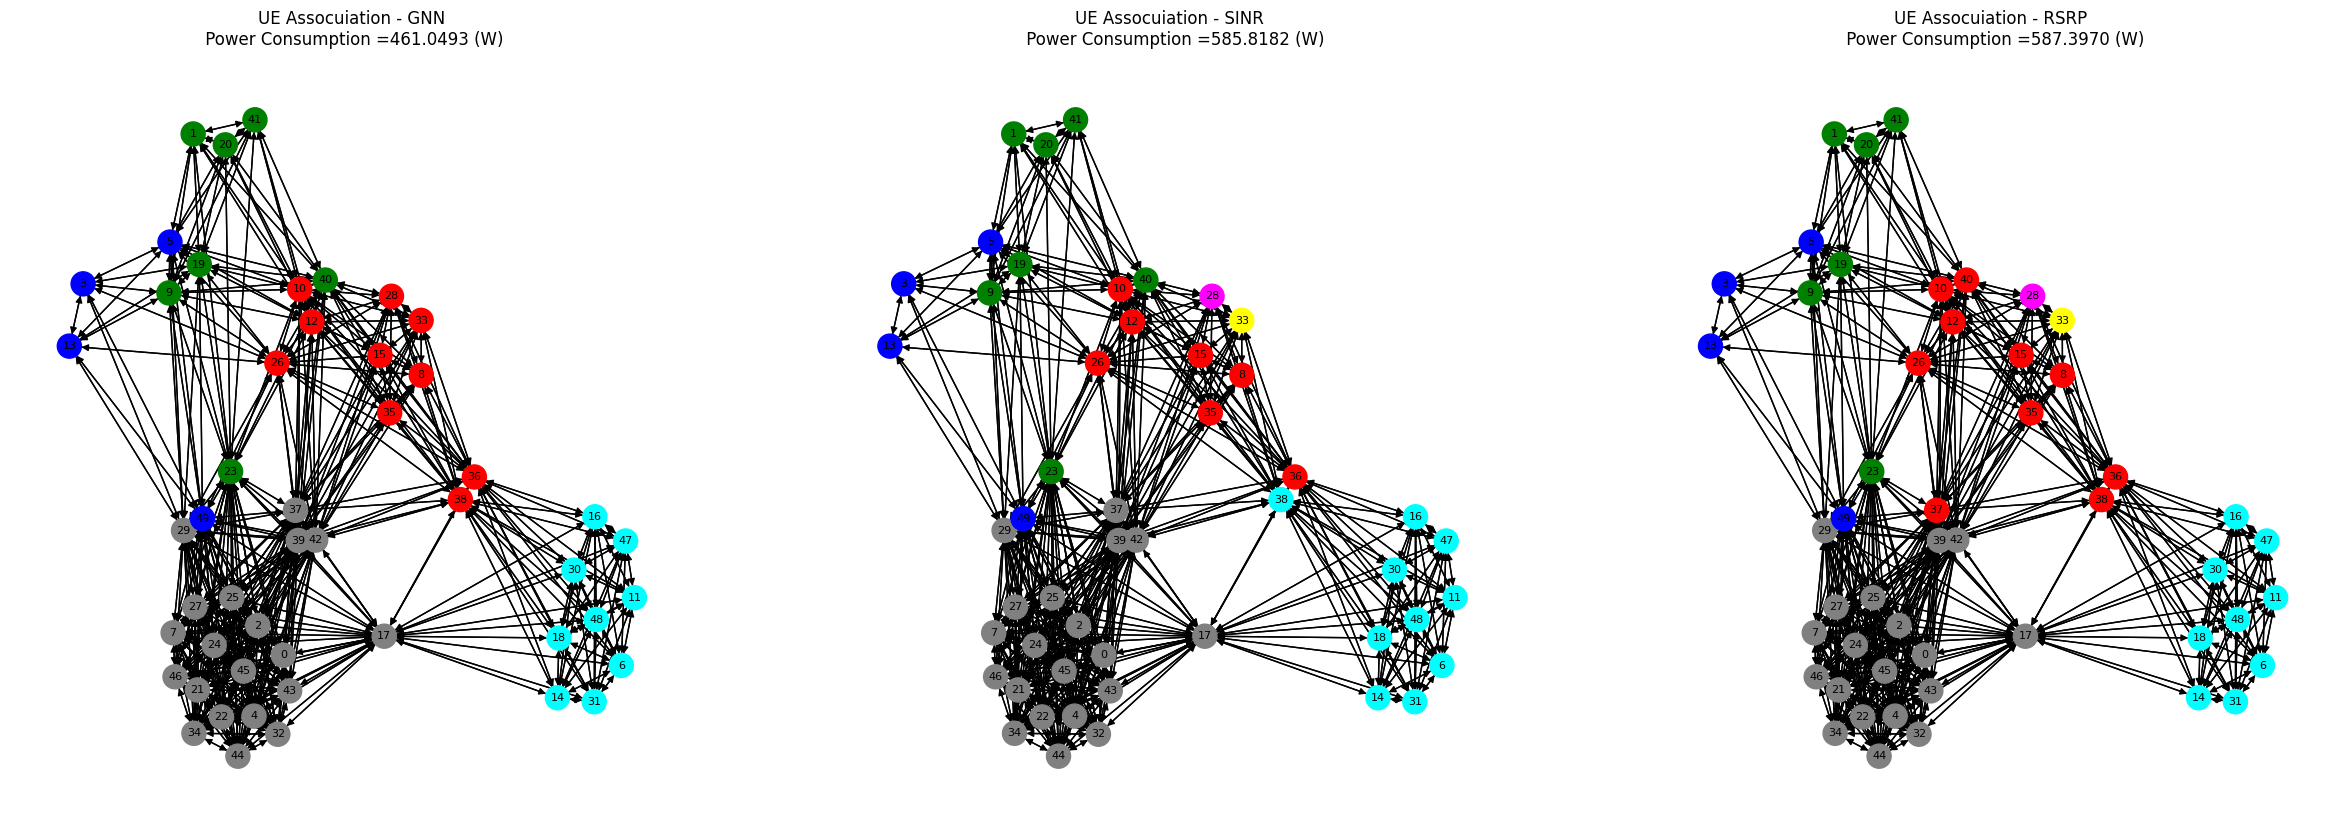

GNN:  PrB Distribution: tensor([47.,  7., 23.,  0.,  0., 17., 45.]), ====>> Total PrB: 139.0, ====>> Total PWR: 461.0493
RSRP: PrB Distribution: tensor([39.,  7., 19.,  5.,  5., 17., 41.]), ====>> Total PrB: 133.0, ====>> Total PWR: 587.3970
SINR: PrB Distribution: tensor([21.,  7., 23.,  5.,  5., 25., 45.]), ====>> Total PrB: 131.0, ====>> Total PWR: 585.8182


In [341]:
import torch_geometric
import networkx as nx
from torch_geometric.data import Data

import seaborn as sns
BS_nom = 7
UE_nom=50
device= 'cpu'

sample_nom =16# np.random.randint(50)
print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()
data_test=list(enumerate(Extereme_test_loader))[sample_nom][1]
out_test = GNN_homo_model(data_test)  # Perform a single forward pass.


out_test= out_test.to('cpu')

T_GNN= torch.zeros((UE_nom,BS_nom))
L_GNN= torch.argmax(out_test, dim=1)
for l in range(len(L_GNN)):
    T_GNN[l,L_GNN[l].item()] = 1
T_RSRP = data_test['UE_Ass_rsrp_mtx']
T_SINR = data_test['UE_Ass_sinr_mtx']

## Power Consumption
BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
# Power_Cons_GNN = torch.tensor( regr.predict(BS_PRB_GNN.reshape(-1, 1))).sum()
# Power_Cons_RSRP = torch.tensor( regr.predict(BS_PRB_RSRP.reshape(-1, 1))).sum()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)

poly_features_GNN = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_GNN], dtype= torch.float32, device= device)
Power_Cons_GNN= torch.matmul(coefs[0],torch.t(poly_features_GNN))+intercepts*torch.where(BS_PRB_GNN > 0, 1, 0)

poly_features_RSRP = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_RSRP], dtype= torch.float32, device= device)
Power_Cons_RSRP= torch.matmul(coefs[0],torch.t(poly_features_RSRP))+intercepts*torch.where(BS_PRB_RSRP > 0, 1, 0)

poly_features_SINR = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_SINR], dtype= torch.float32, device= device)
Power_Cons_SINR= torch.matmul(coefs[0],torch.t(poly_features_SINR))+intercepts*torch.where(BS_PRB_SINR > 0, 1, 0)



# sample=130
# adj_t= data_set_processed['Adj_mtx'][sample]
# edge_index = torch.tensor(adj_t.nonzero())
# UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample],  data_set_processed['UE_aggPRB_norm'][sample]), axis=1)

# x = torch.tensor(UE_feature_mtx, dtype=torch.float32) 
Homodata = Data(x=data_test.x, edge_index=data_test.edge_index)
    
## find color map
edge_index = (T_GNN > 0).nonzero().t()
row, col = edge_index
# edge_index
colors=['red', 'blue', 'green', 'magenta', 'yellow', 'cyan', 'gray']
color_map_GNN=[]
color_map_RSRP=[]
color_map_SINR=[]
for t in range(50):
    color_map_GNN.append(colors[[idx for idx in range(BS_nom) if T_GNN[t,idx]==1][0]])
    color_map_RSRP.append(colors[[idx for idx in range(BS_nom) if T_RSRP[t,idx]==1][0]])
    color_map_SINR.append(colors[[idx for idx in range(BS_nom) if T_SINR[t,idx]==1][0]])

    
    
    
g_GNN = torch_geometric.utils.to_networkx(Homodata, remove_self_loops=True)

# random_pos = nx.random_layout(graph, seed=42)
# pos = nx.spring_layout(graph, pos=random_pos)
pos = nx.spring_layout(g_GNN)


# larger figure size
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(1, 3, 1)

# nx.draw_networkx(G,
#                 pos=nx.spring_layout(G, seed=0),
#                 with_labels=True,
#                 node_size=800,
#                 node_color=data.y,
#                 cmap="hsv",
#                 vmin=-2,
#                 vmax=3,
#                 width=0.8,
#                 edge_color="grey",
#                 font_size=14
#                 )


nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_GNN, pos=pos, ax=ax1)
ax1.set_title('UE Assocuiation - GNN\n Power Consumption ={:.4f} (W)'.format(Power_Cons_GNN.sum()))

ax2 = fig.add_subplot(1, 3, 2)
nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_SINR, pos=pos, ax=ax2)
ax2.set_title('UE Assocuiation - SINR \n Power Consumption ={:.4f} (W)'.format(Power_Cons_SINR.sum()))

ax3 = fig.add_subplot(1, 3, 3)
nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_RSRP, pos=pos, ax=ax3)
ax3.set_title('UE Assocuiation - RSRP \n Power Consumption ={:.4f} (W)'.format(Power_Cons_RSRP.sum()))

# plt.savefig('figs/NXPlot_TraceConst_HomoGraph_infPrB_v4.png')
# plt.savefig('figs/NXPlot_TraceConst_HomoGraph_infPrB_v4.pdf')


plt.show()

print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')

In [342]:
(587.3970-461.0493)/587.3970

0.21509762562628004

In [165]:
print(data_test['SINR_mtx'].t()[sample1])
print(data_test['SINR_mtx'].t()[sample2])

tensor([ -4.9107,  -3.9557,  -8.5593,  -2.9378, -13.2502, -29.1873, -26.2687])
tensor([-20.9543, -21.3873, -21.7782,   2.3277,  -4.0355,  -7.4943, -26.4149])


In [166]:
print(data_test['UE_PRB_All_cells'][sample1])
print(data_test['UE_PRB_All_cells'][sample2])

tensor([  13.,   10., 2977.,    8., 2977., 2977., 2977.])
tensor([2977., 2977., 2977.,    3.,   13., 2977., 2977.])


In [85]:
print(data_test.x[sample1])
print(data_test.x[sample2])

tensor([1.8056e-04, 2.3166e-04, 2.2412e-04, 2.0856e-04, 2.0033e-04, 2.1185e-04,
        2.2659e-04, 1.8428e-04, 1.3937e-04, 9.8362e-05, 1.0890e-04, 1.2126e-04,
        1.6145e-04, 2.7670e-04, 3.6539e-04, 1.9923e-01, 1.9923e-01, 1.9923e-01,
        6.9973e-04, 1.9923e-01, 1.9923e-01, 2.3166e-04])
tensor([1.8760e-04, 2.3160e-04, 2.2965e-04, 2.1281e-04, 1.9048e-04, 1.9504e-04,
        2.1786e-04, 1.8340e-04, 1.7890e-04, 1.5910e-04, 1.2135e-04, 1.4646e-04,
        2.3043e-04, 2.3681e-04, 6.9953e-04, 1.9917e-01, 1.9917e-01, 1.9917e-01,
        4.9899e-04, 1.9917e-01, 1.9917e-01, 2.3160e-04])


## Animation

In [ ]:
def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)
fig = plt.figure(figsize=(12, 12))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

In [80]:
Power_Cons_GNN.sum()

568.3777847290039

In [107]:
poly_features_GNN

array([[1.000e+00, 2.200e+01, 8.000e+00, 3.200e+01, 3.900e+01, 2.900e+01,
        1.000e+00, 1.100e+01, 4.840e+02, 1.760e+02, 7.040e+02, 8.580e+02,
        6.380e+02, 2.200e+01, 2.420e+02, 6.400e+01, 2.560e+02, 3.120e+02,
        2.320e+02, 8.000e+00, 8.800e+01, 1.024e+03, 1.248e+03, 9.280e+02,
        3.200e+01, 3.520e+02, 1.521e+03, 1.131e+03, 3.900e+01, 4.290e+02,
        8.410e+02, 2.900e+01, 3.190e+02, 1.000e+00, 1.100e+01, 1.210e+02]])

In [81]:
## Power Consumption
BS_PRB_GNN = (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)

BS_PRB_GNN


tensor([23.,  8., 20., 10., 25., 18.,  7.])

In [126]:
poly = PolynomialFeatures(degree=2, include_bias=True)
x_ = np.array([i[0] for i in x])
poly_features = poly.fit_transform(x_.reshape(-1,1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)
y_predicted = poly_reg_model.predict(poly_features)



poly_features_GNN = poly.fit_transform(np.array([i.item() for i in BS_PRB_GNN]).reshape(1, -1))
Power_Cons_GNN = poly_reg_model.predict(poly_features_GNN)
# Power_Cons_GNN = torch.tensor( regr.predict(BS_PRB_GNN.reshape(-1, 1))).sum()
# poly_features_RSRP = poly.fit_transform(BS_PRB_RSRP.reshape(1, -1))
# Power_Cons_RSRP = poly_reg_model.predict(poly_features_RSRP)

ValueError: X has 36 features, but LinearRegression is expecting 3 features as input.

In [129]:
np.array([i.item() for i in BS_PRB_GNN]).reshape(1, -1).shape

(1, 7)

In [134]:
poly = PolynomialFeatures(degree=2, include_bias=True)
poly_features_ = poly.fit_transform(np.array([i.item() for i in BS_PRB_GNN]).reshape(1, -1).reshape(-1,1))
poly_reg_model.predict(poly_features_)

array([[ 87.30514526],
       [ 73.37841797],
       [ 96.6796875 ],
       [102.95769501],
       [ 93.91747284],
       [ 66.06401825],
       [ 76.44152069]])

In [103]:
BS_PRB_RSRP

tensor([32., 11., 23.,  7.,  5., 28.,  8.])

In [141]:
BS_PRB_RSRP.sum()

NameError: name 'BS_PRB_RSRP' is not defined

In [150]:
import torch
BS_PRB_RSRP = torch.tensor([28., 29., 32., 28., 44., 28., 21.])
BS_PRB_GNN = torch.tensor([ 8., 42., 19., 28., 52., 30., 52.])
# torch.norm(BS_PRB_RSRP, p=2)
BS_PRB_GNN.sum()

tensor(231.)

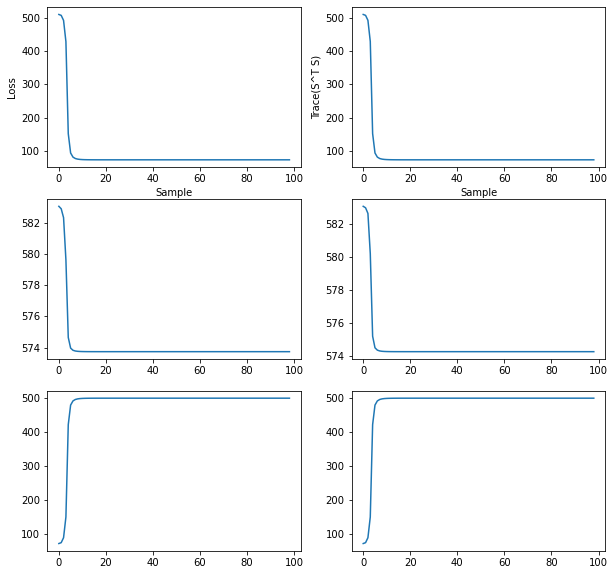

In [220]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)

ax1.plot(train_loss_list, label='data 1')
ax2.plot(test_loss_list, label='data 2')
ax3.plot(train_Avg_PrB_list, label='data 1')
ax4.plot(test_Avg_PrB_list, label='data 2')

ax5.plot(train_Reg_list, label='data 1')
ax6.plot(test_Reg_list, label='data 2')

ax1.set_xlabel('Sample')
ax1.set_ylabel('Loss')
# ax1.set_title('first data set')
# ax1.legend()
ax2.set_xlabel('Sample')
ax2.set_ylabel('Trace(S^T S)')
# ax2.set_title('second data set')
# ax2.legend()

plt.show()

In [308]:
data=list(enumerate(train_loader))[10][1]
GNN_homo_model = GNN(hidden_channels=200, out_channels=7)
GNN_hetro_model = to_hetero(GNN_homo_model, data.metadata(), aggr='sum')
lambda_ = 10
# GNN_hetro_model.eval()
GNN_hetro_model.train()
out = GNN_hetro_model(data.x_dict, data.edge_index_dict)  # Perform a single forward pass.
l, b, c, = Linear_combinaton_PRB(out, data, lambda_)
l
# param_grad = list(GNN_hetro_model.parameters())[0].grad[1][0:3]
# param_grad
# GNN_hetro_model.train()
# for data in loader:  # Iterate in batches over the training dataset.
# #         out = model(Graph_data.x, Graph_data.edge_index, Graph_data.batch, Graph_data.UE_cluster)  # Perform a single forward pass.
#     out = model(data.x_dict, data.edge_index_dict)  # Perform a single forward pass.

#     UE_Ass_tensor = Calc_UE_Association(out)
#     SNR_mtx_tensor = data['SINR_mtx']
#     BS_PRB_Percentage = Calc_BS_PrB_percentage(SNR_mtx_tensor, UE_Ass_tensor, Max_PRB, number_of_BS, MCS_SNR_df)
#     loss = Calc_Energy(BS_PRB_Percentage, regr).sum() ## Energy consumption
#     loss.requires_grad= True
# #         print(loss.item())
#     loss.backward()  # Derive gradients.
#     optimizer.step()  # Update parameters based on gradients.
#     optimizer.zero_grad()  # Clear gradients.
        
        

tensor(657.5682, grad_fn=<AddBackward0>)

In [147]:
for name, param in GNN_hetro_model.named_parameters():
  print(name, param.requires_grad)

conv1.UE__to__BS.lin_l.weight True
conv1.UE__to__BS.lin_l.bias True
conv1.UE__to__BS.lin_r.weight True
conv1.BS__rev_to__UE.lin_l.weight True
conv1.BS__rev_to__UE.lin_l.bias True
conv1.BS__rev_to__UE.lin_r.weight True
conv2.UE__to__BS.lin_l.weight True
conv2.UE__to__BS.lin_l.bias True
conv2.UE__to__BS.lin_r.weight True
conv2.BS__rev_to__UE.lin_l.weight True
conv2.BS__rev_to__UE.lin_l.bias True
conv2.BS__rev_to__UE.lin_r.weight True
conv3.UE__to__BS.lin_l.weight True
conv3.UE__to__BS.lin_l.bias True
conv3.UE__to__BS.lin_r.weight True
conv3.BS__rev_to__UE.lin_l.weight True
conv3.BS__rev_to__UE.lin_l.bias True
conv3.BS__rev_to__UE.lin_r.weight True
lin.UE.weight True
lin.UE.bias True
lin.BS.weight True
lin.BS.bias True


In [306]:
test(test_loader, GNN_hetro_model)

In [309]:
torch.stack(a).mean().item()

58.02411651611328

In [465]:

for name, param in GNN_hetro_model.state_dict().items():
    print(name)


conv1.UE__to__BS.lin_l.weight
conv1.UE__to__BS.lin_l.bias
conv1.UE__to__BS.lin_r.weight
conv1.BS__rev_to__UE.lin_l.weight
conv1.BS__rev_to__UE.lin_l.bias
conv1.BS__rev_to__UE.lin_r.weight
conv2.UE__to__BS.lin_l.weight
conv2.UE__to__BS.lin_l.bias
conv2.UE__to__BS.lin_r.weight
conv2.BS__rev_to__UE.lin_l.weight
conv2.BS__rev_to__UE.lin_l.bias
conv2.BS__rev_to__UE.lin_r.weight
conv3.UE__to__BS.lin_l.weight
conv3.UE__to__BS.lin_l.bias
conv3.UE__to__BS.lin_r.weight
conv3.BS__rev_to__UE.lin_l.weight
conv3.BS__rev_to__UE.lin_l.bias
conv3.BS__rev_to__UE.lin_r.weight
lin.UE.weight
lin.UE.bias
lin.BS.weight
lin.BS.bias


In [289]:

# torch.mean(torch.stack(train_acc))
train_acc[:, ~torch.stack(train_acc).isnan().any(dim=0).any(dim=0), :]

TypeError: list indices must be integers or slices, not tuple

TypeError: list indices must be integers or slices, not tuple

In [299]:
data=list(enumerate(train_loader))[19][1]

out = GNN_hetro_model(data.x_dict, data.edge_index_dict)  # Perform a single forward pass.
# out['UE']
loss_val = torch.diag(torch.matmul(out['UE'],torch.t(data['UE_PRB_All_cells'])))+lambda_ *torch.norm(out['UE'], p=1, dim=1)
loss_val
# UE_Ass_tensor = Calc_UE_Association(out)
# SNR_mtx_tensor = data['SINR_mtx']
# BS_PRB_Percentage = Calc_BS_PrB_percentage(SNR_mtx_tensor, UE_Ass_tensor, Max_PRB, number_of_BS, MCS_SNR_df)
# loss = Calc_Energy(BS_PRB_Percentage, regr).sum() ## Energy consumption
# loss

tensor([47.1634, 43.1453, 44.3414, 43.3580, 45.6963, 48.6174, 46.0163, 43.1545,
        44.4057, 43.6456, 44.7160, 46.5044, 43.6362, 44.5758, 43.6768, 44.3713,
        47.3655, 42.6582, 42.8120, 48.6716, 44.3819, 43.6792, 46.1568, 43.3427,
        45.6415, 48.6367, 43.2028, 44.7247, 45.1845, 44.4167, 44.1568, 44.6390,
        44.5951, 46.1604, 45.5023, 48.6524, 45.2104, 44.4120, 43.2090, 44.7925,
        43.5225, 47.1941, 43.3536, 43.6654, 44.6518, 45.2241, 44.1838, 45.9820,
        43.1458, 43.3452], grad_fn=<AddBackward0>)

In [300]:
torch.norm(out['UE'], p=1, dim=1)

tensor([3.4762, 3.4743, 3.4741, 3.4749, 3.4762, 3.4727, 3.4751, 3.4726, 3.4743,
        3.4749, 3.4776, 3.4753, 3.4734, 3.4741, 3.4736, 3.4763, 3.4754, 3.4762,
        3.4741, 3.4765, 3.4773, 3.4744, 3.4760, 3.4741, 3.4741, 3.4741, 3.4749,
        3.4781, 3.4732, 3.4739, 3.4733, 3.4738, 3.4763, 3.4763, 3.4761, 3.4752,
        3.4752, 3.4734, 3.4753, 3.4759, 3.4773, 3.4777, 3.4748, 3.4782, 3.4762,
        3.4758, 3.4753, 3.4735, 3.4759, 3.4731], grad_fn=<NormBackward1>)

In [301]:
data

HeteroDataBatch(
  SINR_mtx=[7, 50],
  UE_PRB_All_cells=[50, 7],
  UE={
    node_id=[50],
    x=[50, 14],
    batch=[50],
    ptr=[2]
  },
  BS={
    node_id=[7],
    x=[7, 4],
    batch=[7],
    ptr=[2]
  },
  (UE, to, BS)={
    edge_index=[2, 350],
    edge_attr=[350]
  },
  (BS, rev_to, UE)={
    edge_index=[2, 350],
    edge_attr=[350]
  }
)

In [302]:
sum(out['UE'][0])

tensor(3.4762, grad_fn=<AddBackward0>)

In [303]:
# sample_G = Training_list_graph[19][1] #Graph_list[1]

# with torch.no_grad():  # Initialize lazy modules.
#     out = GNN_hetro_model(sample_G.x_dict, data.edge_index_dict)
    
# UE_Ass_tensor = Calc_UE_Association(out)
# SNR_mtx_tensor = sample_G['SINR_mtx']

# SNR_blkdg = torch.empty((0,0),dtype=torch.int64)
# a= torch.split(SNR_mtx_tensor,7, dim=0)
# for i in a:
#     SNR_blkdg= torch.block_diag(SNR_blkdg, i)
# #         print(SNR_blkdg*UE_Ass_tensor)
        
        
# BS_PRB_Percentage = Calc_BS_PrB_percentage(SNR_mtx_tensor, UE_Ass_tensor, Max_PRB, number_of_BS, MCS_SNR_df, batch_size)
# Energy_consumption = Calc_Energy(BS_PRB_Percentage, regr)
# Energy_consumption

In [306]:
data

HeteroDataBatch(
  SINR_mtx=[7, 50],
  UE_PRB_All_cells=[50, 7],
  UE={
    node_id=[50],
    x=[50, 14],
    batch=[50],
    ptr=[2]
  },
  BS={
    node_id=[7],
    x=[7, 4],
    batch=[7],
    ptr=[2]
  },
  (UE, to, BS)={
    edge_index=[2, 350],
    edge_attr=[350]
  },
  (BS, rev_to, UE)={
    edge_index=[2, 350],
    edge_attr=[350]
  }
)

In [278]:
test_acc

[tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan,

NameError: name 'loss' is not defined

In [865]:
cal_Energy(BS_PRB_Percentage, regr)

array([[ 69.52630615],
       [ 69.52630615],
       [ 69.52630615],
       [ 69.52630615],
       [ 69.52630615],
       [515.15270543],
       [ 69.52630615]])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()

def train():
    model.train()

    for Graph_data in train_loader:  # Iterate in batches over the training dataset.
#         out = model(Graph_data.x, Graph_data.edge_index, Graph_data.batch, Graph_data.UE_cluster)  # Perform a single forward pass.
        out = model(Graph_data, batch_size)  # Perform a single forward pass.
#         print([out, Graph_data.y])
#         print(Graph_data.y)
        loss = criterion(out, Graph_data.y)  # Compute the loss.
#         print(loss)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    for Graph_data in loader:  # Iterate in batches over the training/test dataset.
#         out = model(Graph_data.x, Graph_data.edge_index, Graph_data.batch, Graph_data.UE_cluster)
        out = model(Graph_data, batch_size)
        loss = criterion(out, Graph_data.y)  # Compute the loss.
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         correct += int((pred == Graph_data.y).sum())  # Check against ground-truth labels.
    return loss  


train_acc_list =[]
test_acc_list = []
for epoch in range(1, 100):
    train()
    
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_acc_list.append(train_acc.item())
    test_acc_list.append(test_acc.item())
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

In [ ]:
from torch.nn import Linear
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, avg_pool

# def _create_cluster_vector_ (UE_cluster, batch, batch_size):
    
#     tuples = [(UE_cluster[i].item(), batch[i].item() ) for i in range(batch.shape[0])]
#     unique_tuples_list = list(set(tuples))
#     labels_dict= {i:unique_tuples_list[i] for i in range(len(unique_tuples_list))}
#     c=[]
#     for i in tuples:
#         c.append([k for k in labels_dict.keys() if labels_dict[k] == i][0])

#     cluster = torch.tensor(c)
    
#     return cluster

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, nom_nodes, num_outputs, batch_size):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(num_node_features, 1)
        self.double()



    def forward(self, Graph, batch_size):
        x, edge_index, batch= Graph.x, Graph.edge_index, Graph.batch, 
#         cluster = _create_cluster_vector_ (Graph.UE_cluster, batch, batch_size)
        # 1. Obtain node embeddings 
#         print(x.shape)
#         x=x.float()
#         print('=== conv1 ===')
        x = self.conv1(x, edge_index)
#         print(x.shape)
        x = x.relu()
#         print(' Relu ----')
#         print(x.shape)
#         print('=== conv2 ===')
        x = self.conv2(x, edge_index)
#         print(x.shape)
#         print(' Relu ----')
        x = x.relu()
#         print(x.shape)
#         print('=== conv3 ===')
        x = self.conv3(x, edge_index)
#         print(x.shape)
        
        # 2. Readout layer
#         x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        data_sample_batch = avg_pool(cluster, Graph)  # [batch_size, hidden_channels]
#         print(data_sample_batch)


        # 3. Apply a final classifier
        x = F.dropout(data_sample_batch.x, p=0.5, training=self.training)
#         print(x.shape)
#         x=x.float()
        x = self.lin(x)
#         print(x.shape)
        
        return x

model = GCN(num_node_features=14, hidden_channels=32, nom_nodes=50, num_outputs=9, batch_size= batch_size)
print(model)

# Test

In [544]:
from torch_geometric.data import download_url, extract_zip

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movies_path = './ml-latest-small/movies.csv'
ratings_path = './ml-latest-small/ratings.csv'

Extracting .\ml-latest-small.zip


In [545]:
# Load the entire movie data frame into memory:
movies_df = pd.read_csv(movies_path, index_col='movieId')

# Split genres and convert into indicator variables:
genres = movies_df['genres'].str.get_dummies('|')
print(genres[["Action", "Adventure", "Drama", "Horror"]].head())
# Use genres as movie input features:
movie_feat = torch.from_numpy(genres.values).to(torch.float)
assert movie_feat.size() == (9742, 20)  # 20 genres in total.

         Action  Adventure  Drama  Horror
movieId                                  
1        0       1          0      0     
2        0       1          0      0     
3        0       0          0      0     
4        0       0          1      0     
5        0       0          0      0     


In [546]:
# Load the entire ratings data frame into memory:
ratings_df = pd.read_csv(ratings_path)

# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()
# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())
# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)
# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
assert edge_index_user_to_movie.size() == (2, 100836)
print()
print("Final edge indices pointing from users to movies:")
print("=================================================")
print(edge_index_user_to_movie)

Mapping of user IDs to consecutive values:
   userId  mappedID
0  1       0       
1  2       1       
2  3       2       
3  4       3       
4  5       4       

Mapping of movie IDs to consecutive values:
   movieId  mappedID
0  1        0       
1  3        1       
2  6        2       
3  47       3       
4  50       4       

Final edge indices pointing from users to movies:
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    1,    2,  ..., 3121, 1392, 2873]])


In [550]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))
# Add the node features and edge indices:
data["movie"].x = movie_feat
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie
# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)


In [554]:
movie_feat.shape

torch.Size([9742, 20])

In [556]:
torch.arange(len(movies_df))

tensor([   0,    1,    2,  ..., 9739, 9740, 9741])

In [559]:
edge_index_user_to_movie

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    1,    2,  ..., 3121, 1392, 2873]])